
Loaded: genre.csv
Shape: (2210, 4)

--- First 5 rows ---
       Music_Id                        Title  Duration  \
0  MT0000291374       What a Wonderful World     139.0   
1  MT0001577585              Country Comfort     282.0   
2  MT0008469560                       Lately     244.0   
3  MT0030326044  I'm So Lonesome I Could Cry     159.0   
4  MT0005204984               U Got the Look     227.0   

                                              Genres  
0  Jazz,Vocal Jazz,Traditional Pop,Early Pop/Rock...  
1                                           Pop/Rock  
2                      Soul,Pop-Soul,Smooth Soul,R&B  
3                             Outlaw Country,Country  
4  Dance-Rock,R&B,Contemporary Pop/Rock,Contempor...  

--- df.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Music_Id  2210 non-null   object 
 1   Title     2210 n

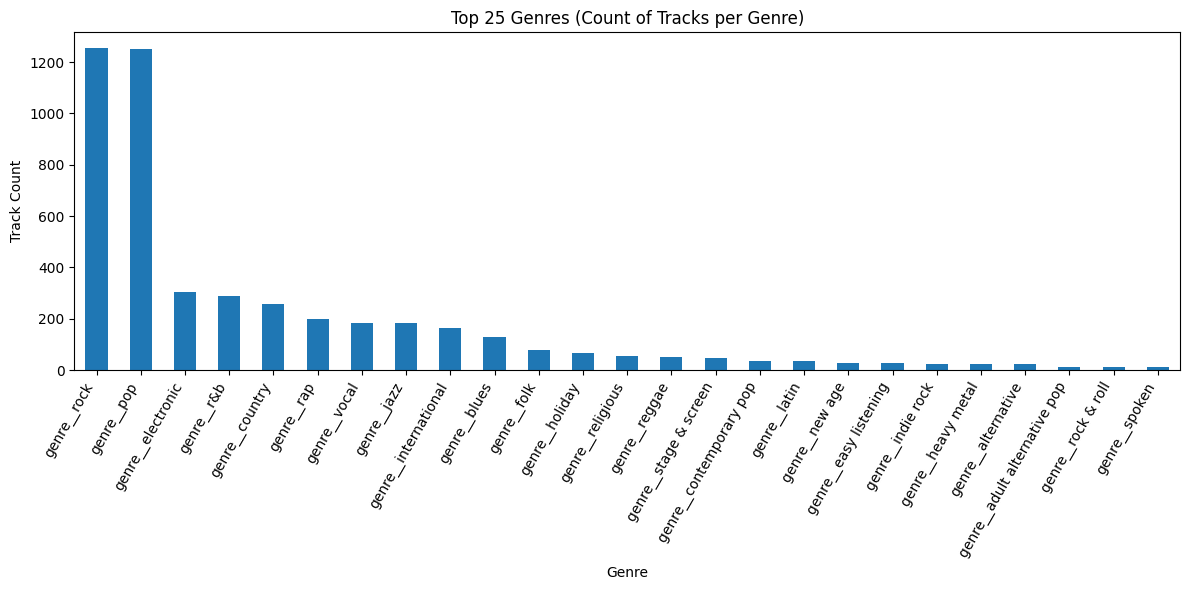


Saved processed genre CSV to: genre_processed.csv
Saved shape: (2184, 163)
Saved genre label classes to: genre_label_classes.json

Done.


In [ ]:
# Genre EDA + Preprocessing
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

GENRE_CSV_PATH = "genre.csv"
OUTPUT_PROCESSED_CSV = "genre_processed.csv"
OUTPUT_LABELS_JSON = "genre_label_classes.json"  # saves the genre label list used by the encoder


# 1) Load the CSV
# -------------------------
df = pd.read_csv(GENRE_CSV_PATH)
print(f"\nLoaded: {GENRE_CSV_PATH}")
print(f"Shape: {df.shape}")

# -------------------------
# 2) Inspect the first few rows
# -------------------------
print("\n--- First 5 rows ---")
print(df.head())

# -------------------------
# 3) Basic information, statistics, description
# -------------------------
print("\n--- df.info() ---")
df.info()

print("\n--- Numeric describe() ---")
print(df.describe(include=[np.number]).T)

print("\n--- Non-numeric describe() ---")
print(df.describe(include=["object"]).T)

# -------------------------
# 4) Check missing or inconsistent genre labels
# -------------------------
if "Genres" not in df.columns:
    raise ValueError(
        f'Column "Genres" not found. Available columns: {list(df.columns)}'
    )

print("\n--- Missing values (per column) ---")
print(df.isna().sum().sort_values(ascending=False))

print("\n--- Missing/empty Genres checks ---")
missing_genres = df["Genres"].isna().sum()
empty_string_genres = (df["Genres"].astype(str).str.strip() == "").sum()
print(f"Null in Genres: {missing_genres}")
print(f'Empty-string Genres (after strip): {empty_string_genres}')

# Quick look at raw genre strings that may be inconsistent (case/spacing)
print("\n--- Sample raw Genres values (first 20 non-null) ---")
print(df.loc[df["Genres"].notna(), "Genres"].head(20).to_string(index=False))

# -------------------------
# 5) Check unique values for each column
# -------------------------
print("\n--- Unique value count per column (nunique) ---")
print(df.nunique(dropna=True).sort_values(ascending=False))

print("\n--- Example unique values (up to 15 per column) ---")
for col in df.columns:
    uniques = df[col].dropna().unique()
    preview = uniques[:15]
    print(f"\nColumn: {col}")
    print(f"  Unique count: {len(uniques)}")
    print(f"  Sample uniques: {preview}")

# -------------------------
# 6) Identify categorical and numerical columns
# -------------------------
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\n--- Column Types ---")
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# -------------------------
# 7) Drop rows with null values in 'Genres', print number of data points after
# -------------------------
before = len(df)
df = df[df["Genres"].notna()].copy()
after = len(df)
print("\n--- Dropping null Genres ---")
print(f"Rows before: {before}")
print(f"Rows after : {after}")
print(f"Data points remaining: {after}")

# Also drop rows where Genres becomes empty after stripping
df["Genres"] = df["Genres"].astype(str)
df["Genres_stripped"] = df["Genres"].str.strip()
before2 = len(df)
df = df[df["Genres_stripped"] != ""].copy()
after2 = len(df)
print("\n--- Dropping empty-string Genres (after strip) ---")
print(f"Rows before: {before2}")
print(f"Rows after : {after2}")
print(f"Data points remaining: {after2}")

# -------------------------
# 8) Encode Genres (multi-label encoding) + print few encodings
#    (Handles multi-genre like: "Pop, Rock" or "Pop;Rock" or "Pop|Rock")
# -------------------------

# A robust splitter: splits on commas/semicolons/pipes/slashes
SPLIT_PATTERN = r"[,\;/\|]+"

def normalize_genre_token(token: str) -> str:
    # Basic cleanup for inconsistencies:
    # - strip spaces
    # - collapse internal multiple spaces
    # - normalize casing (choose one: lower() is common for consistency)
    t = token.strip()
    t = re.sub(r"\s+", " ", t)
    t = t.lower()
    return t

def parse_genres_cell(cell: str):
    # Turn a string cell into a list of cleaned genre labels
    parts = re.split(SPLIT_PATTERN, str(cell))
    parts = [normalize_genre_token(p) for p in parts if normalize_genre_token(p)]
    # de-duplicate while preserving order
    seen = set()
    out = []
    for p in parts:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

df["Genres_list"] = df["Genres_stripped"].apply(parse_genres_cell)

# Check for weird cases: empty lists after parsing
empty_lists = (df["Genres_list"].apply(len) == 0).sum()
print("\n--- After parsing Genres into list ---")
print(f"Rows with empty Genres_list: {empty_lists}")
if empty_lists > 0:
    print("Examples of problematic rows:")
    print(df.loc[df["Genres_list"].apply(len) == 0, ["Genres"]].head(10))

# MultiLabelBinarizer encoding
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["Genres_list"])

print("\n--- Multi-label classes (genres) learned by encoder ---")
print(f"Number of unique genres: {len(mlb.classes_)}")
print("First 30 classes:", mlb.classes_[:30])

encoded_df = pd.DataFrame(Y, columns=[f"genre__{g}" for g in mlb.classes_], index=df.index)

# Show a few encoded rows
print("\n--- Encoded sample (first 5 rows) ---")
preview_cols = ["Genres", "Genres_list"] + list(encoded_df.columns[:10])  # show first 10 genre columns
print(pd.concat([df[["Genres", "Genres_list"]], encoded_df], axis=1)[preview_cols].head(5))

# -------------------------
# 9) Visualize genre distribution
#    (Counts how many tracks contain each genre)
# -------------------------
genre_counts = encoded_df.sum(axis=0).sort_values(ascending=False)

print("\n--- Top 20 genres by count ---")
print(genre_counts.head(20))

plt.figure(figsize=(12, 6))
genre_counts.head(25).plot(kind="bar")
plt.title("Top 25 Genres (Count of Tracks per Genre)")
plt.xlabel("Genre")
plt.ylabel("Track Count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# -------------------------
# 10) Save processed genre labels
#     - Save CSV with original columns + parsed list + one-hot columns
#     - Save label classes list for reproducibility
# -------------------------
processed = df.drop(columns=["Genres_stripped"]).copy()
processed = pd.concat([processed, encoded_df], axis=1)

os.makedirs(os.path.dirname(OUTPUT_PROCESSED_CSV) or ".", exist_ok=True)
processed.to_csv(OUTPUT_PROCESSED_CSV, index=False)
print(f"\nSaved processed genre CSV to: {OUTPUT_PROCESSED_CSV}")
print(f"Saved shape: {processed.shape}")

with open(OUTPUT_LABELS_JSON, "w", encoding="utf-8") as f:
    json.dump({"classes": mlb.classes_.tolist()}, f, ensure_ascii=False, indent=2)
print(f"Saved genre label classes to: {OUTPUT_LABELS_JSON}")

print("\nDone.")


Found 3554 audio files in: Audio
First 10 files:
 - Audio\A001.mp3
 - Audio\A002.mp3
 - Audio\A003.mp3
 - Audio\A004.mp3
 - Audio\A005.mp3
 - Audio\A010.mp3
 - Audio\A011.mp3
 - Audio\A013.mp3
 - Audio\A014.mp3
 - Audio\A017.mp3

Fixed frames for CNN-VAE padding/truncation: 2585 frames
(Chunk=60s, SR=22050, Hop=512)


Processing audio:   0%|          | 0/3554 [00:00<?, ?it/s]

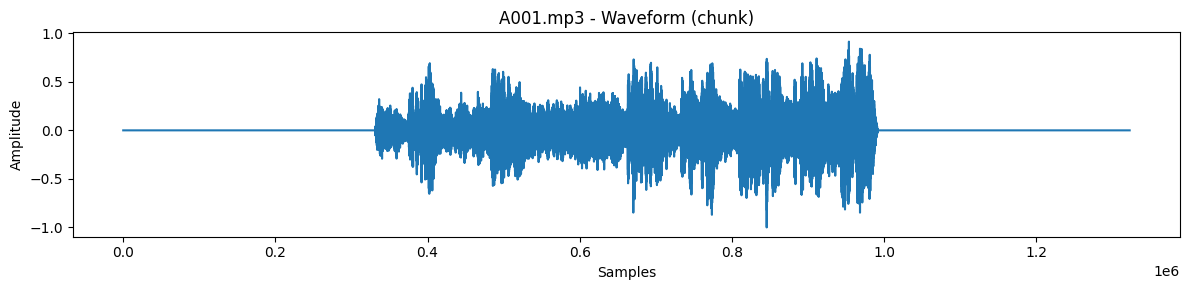

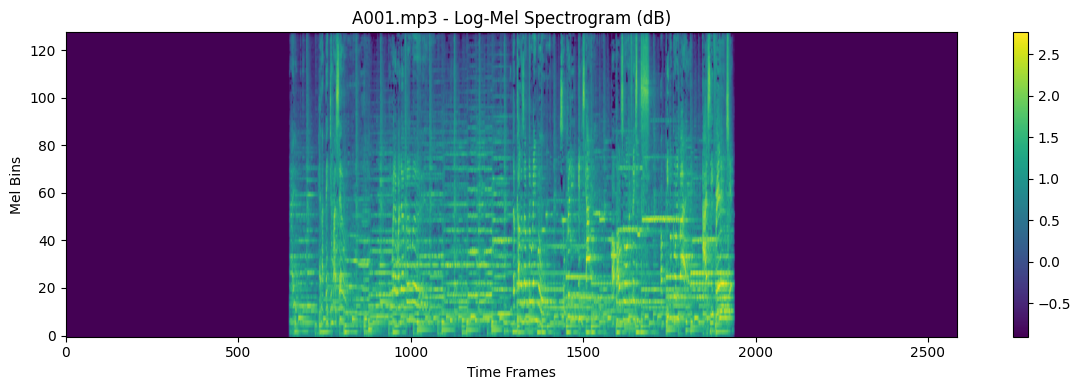

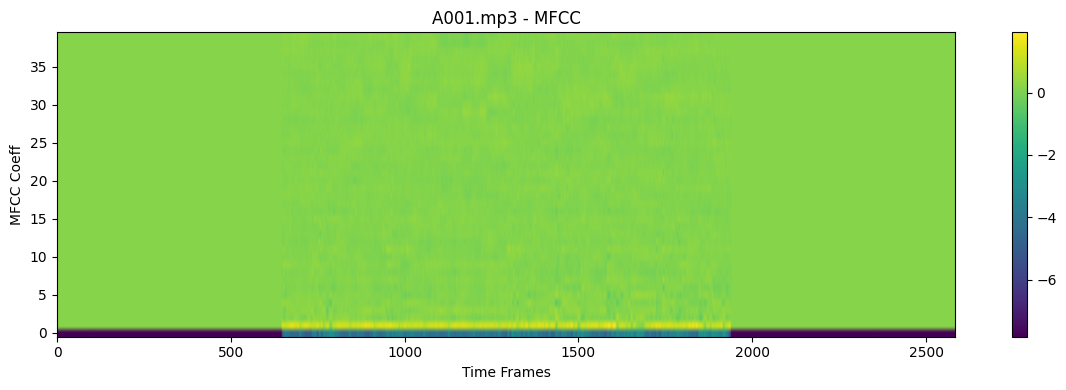

Processing audio:   0%|          | 1/3554 [00:01<1:19:43,  1.35s/it]

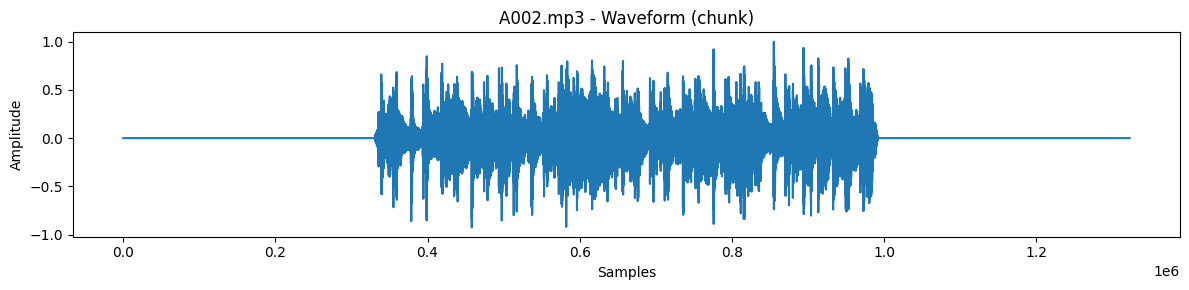

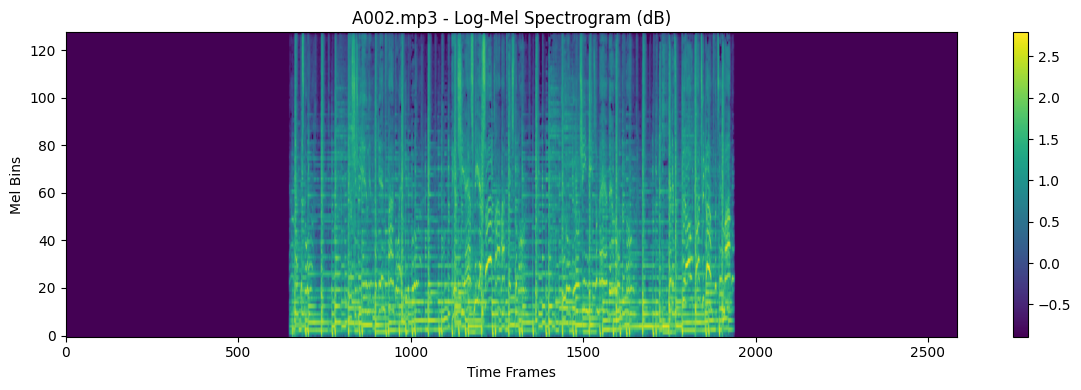

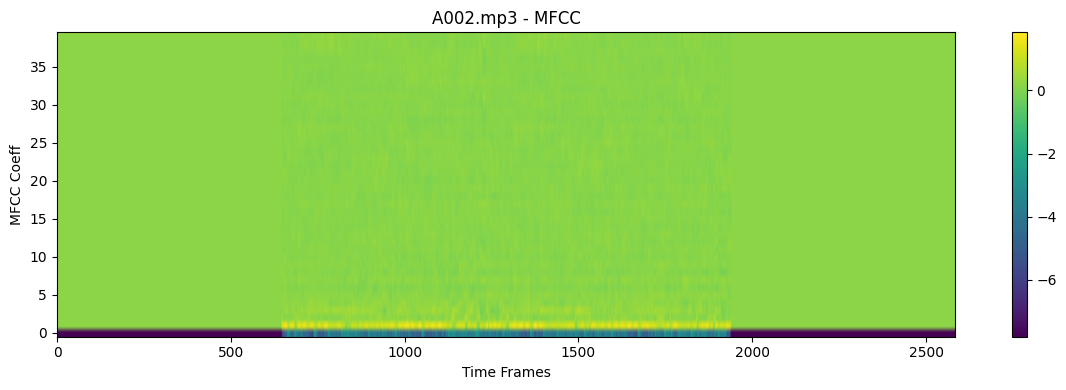

Processing audio: 100%|██████████| 3554/3554 [05:08<00:00, 11.51it/s]



Saved metadata CSV: Audio_Features\audio_metadata.csv

===== Summary =====
Total files found    : 3554
Successfully processed: 3554
Skipped/Failed       : 0

--- Duration stats (seconds) ---
count    3554.000000
mean       29.855085
std         0.905436
min         4.778656
25%        29.952000
50%        30.060000
75%        30.060000
max        30.819501
Name: duration_sec, dtype: float64

--- Original sample rate (top values) ---
orig_sr
32000    2476
22050     853
44100     221
16000       4
Name: count, dtype: int64

--- Channels (top values) ---
channels
2    3548
1       6
Name: count, dtype: int64

--- Processing status counts ---
process_status
ok    3554
Name: count, dtype: int64


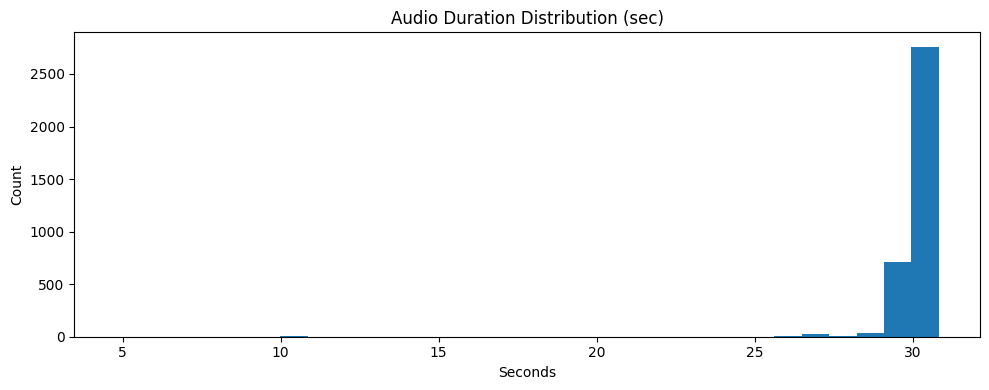

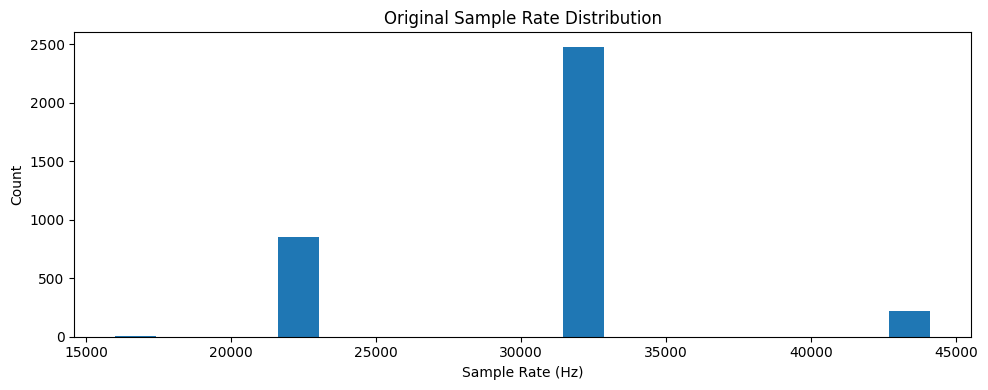


Saved config JSON: Audio_Features\audio_feature_config.json

Done, Audio features are saved in: Audio_Features
Tip: In your VAE/CNN-VAE, you can load per-track arrays from these .npz files.


In [ ]:
# ==========================================
# Audio EDA + Preprocessing + Feature Saving
# ==========================================
# What this script does (end-to-end):
# 1) Load audio files from Data/Audio
# 2) Verify properties (duration, sample rate, channels)
# 3) Handle missing/corrupted files (skip + log)
# 4) (Optional) Chunk: take ONE 60s sample per track (recommended for ~212s avg length)
# 5) Resample to fixed SR
# 6) Trim silence + normalize amplitude
# 7) Extract features: MFCC + Mel-spectrogram (log-mel)
# 8) Visualize waveform + spectrogram + MFCC (for a few examples)
# 9) Standardize features (per-sample z-score)
# 10) Pad/trim time dimension to fixed frames (good for CNN-VAE)
# 11) Save features to disk + save metadata CSV

import os
import glob
import json
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio libs (install if needed):
# pip install librosa soundfile tqdm
import librosa
import soundfile as sf
from tqdm import tqdm

# -------------------------
# CONFIG
# -------------------------
AUDIO_DIR = "Audio"
OUT_DIR = "Audio_Features"
META_OUT_CSV = os.path.join(OUT_DIR, "audio_metadata.csv")
CONFIG_OUT_JSON = os.path.join(OUT_DIR, "audio_feature_config.json")

TARGET_SR = 22050             # fixed sampling rate
CHUNK_SEC = 60                # one 60s chunk per track (as you said)
USE_RANDOM_CHUNK = True       # if track > 60s, take random 60s; else pad
RANDOM_SEED = 42

TRIM_SILENCE = True
TOP_DB = 30                   # higher => more aggressive trimming

# Feature params
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
N_MFCC = 40

# Visualization: how many examples to plot
NUM_PLOTS = 2

# Accept common audio extensions
EXTS = ("*.wav", "*.mp3", "*.flac", "*.m4a", "*.ogg", "*.aac")

# -------------------------
# Helpers
# -------------------------
np.random.seed(RANDOM_SEED)

def list_audio_files(audio_dir: str):
    files = []
    for ext in EXTS:
        files.extend(glob.glob(os.path.join(audio_dir, ext)))
    files = sorted(files)
    return files

def safe_audio_info(path: str):
    """
    Get duration, sample rate, channels without fully loading audio.
    Uses soundfile.info when possible; if it fails, fallback to librosa.
    """
    try:
        info = sf.info(path)
        sr = int(info.samplerate)
        channels = int(info.channels)
        # duration in seconds
        duration = float(info.frames) / float(info.samplerate) if info.frames > 0 else np.nan
        return duration, sr, channels, "ok"
    except Exception:
        try:
            duration = float(librosa.get_duration(path=path))
            # sample rate / channels unknown without load
            return duration, np.nan, np.nan, "ok_librosa_duration_only"
        except Exception:
            return np.nan, np.nan, np.nan, "corrupted"

def choose_offset(duration: float, chunk_sec: float, use_random: bool):
    """
    If duration > chunk_sec, choose an offset so that [offset, offset+chunk_sec] is valid.
    """
    if not np.isfinite(duration) or duration <= chunk_sec:
        return 0.0
    max_offset = max(0.0, duration - chunk_sec)
    if use_random and max_offset > 0:
        return float(np.random.uniform(0, max_offset))
    return 0.0

def load_and_preprocess(path: str, target_sr: int, chunk_sec: float):
    """
    Loads one chunk, resamples, trims silence, normalizes amplitude.
    Returns (y, sr) where sr == target_sr.
    """
    # Try to get duration quickly (helps picking chunk offset)
    duration, _, _, status = safe_audio_info(path)
    if status == "corrupted":
        raise RuntimeError("Corrupted audio (info read failed).")

    offset = choose_offset(duration, chunk_sec, USE_RANDOM_CHUNK)

    # Load exactly one chunk (or shorter if file shorter)
    # librosa.load -> mono by default; for channel stats we handle separately via sf.info above
    y, sr = librosa.load(path, sr=target_sr, mono=True, offset=offset, duration=chunk_sec)

    # If file shorter than chunk_sec, pad with zeros to reach exact length
    target_len = int(chunk_sec * target_sr)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode="constant")

    # Trim silence
    if TRIM_SILENCE:
        yt, _ = librosa.effects.trim(y, top_db=TOP_DB)
        # Keep length fixed after trimming by centering/padding or trimming
        if len(yt) >= target_len:
            y = yt[:target_len]
        else:
            # center-pad
            pad_total = target_len - len(yt)
            left = pad_total // 2
            right = pad_total - left
            y = np.pad(yt, (left, right), mode="constant")

    # Normalize amplitude to [-1, 1] by peak
    peak = np.max(np.abs(y))
    if peak > 1e-8:
        y = y / peak

    return y, target_sr

def extract_features(y: np.ndarray, sr: int):
    """
    Extracts:
    - log-mel spectrogram (dB)
    - MFCC (from log-mel)
    Returns (mel_db, mfcc) with shapes:
      mel_db: (N_MELS, T)
      mfcc:   (N_MFCC, T)
    """
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mfcc = librosa.feature.mfcc(S=mel_db, n_mfcc=N_MFCC)

    return mel_db.astype(np.float32), mfcc.astype(np.float32)

def zscore_per_sample(feat: np.ndarray, eps: float = 1e-8):
    """
    Per-sample standardization: (x - mean) / std
    Standardizes the whole matrix (all coefficients + time) for simplicity.
    """
    mu = float(feat.mean())
    sd = float(feat.std()) + eps
    return (feat - mu) / sd

def fix_time_dim(feat: np.ndarray, fixed_frames: int):
    """
    Pad or truncate along time axis to fixed_frames.
    Padding uses 0, which is natural after z-score standardization.
    """
    n_feat, t = feat.shape
    if t == fixed_frames:
        return feat
    if t > fixed_frames:
        return feat[:, :fixed_frames]
    pad_width = fixed_frames - t
    return np.pad(feat, ((0, 0), (0, pad_width)), mode="constant")

def expected_frames(chunk_sec: float, sr: int, hop: int):
    """
    Approx expected frames for STFT-like features.
    Using center=True in librosa can slightly change frame count,
    but this works well for fixed-size padding/truncation.
    """
    # Roughly frames ~ 1 + samples/hop
    return int(1 + np.ceil((chunk_sec * sr) / hop))

def visualize_example(y, sr, mel_db, mfcc, title_prefix="Example"):
    # Waveform
    plt.figure(figsize=(12, 3))
    plt.plot(y)
    plt.title(f"{title_prefix} - Waveform (chunk)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Spectrogram (log-mel)
    plt.figure(figsize=(12, 4))
    plt.imshow(mel_db, aspect="auto", origin="lower")
    plt.title(f"{title_prefix} - Log-Mel Spectrogram (dB)")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Bins")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # MFCC heatmap
    plt.figure(figsize=(12, 4))
    plt.imshow(mfcc, aspect="auto", origin="lower")
    plt.title(f"{title_prefix} - MFCC")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coeff")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# -------------------------
# 0) Setup output folder
# -------------------------
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# 1) Load audio files
# -------------------------
audio_files = list_audio_files(AUDIO_DIR)
print(f"\nFound {len(audio_files)} audio files in: {AUDIO_DIR}")
print("First 10 files:")
for p in audio_files[:10]:
    print(" -", p)

if len(audio_files) == 0:
    raise RuntimeError("No audio files found. Check your Data/Audio path and file extensions.")

# -------------------------
# 2) Verify properties (duration, sample rate, channels)
# 3) Handle missing/corrupted audio files
# 4) Resample + chunking + trim silence + normalize
# 5) Extract features (MFCC + Mel-spectrogram)
# 6) Standardize + pad/trim to fixed dims
# 7) Save features
# -------------------------

fixed_frames = expected_frames(CHUNK_SEC, TARGET_SR, HOP_LENGTH)
print(f"\nFixed frames for CNN-VAE padding/truncation: {fixed_frames} frames")
print(f"(Chunk={CHUNK_SEC}s, SR={TARGET_SR}, Hop={HOP_LENGTH})")

rows = []
processed_count = 0
skipped_count = 0

# For plotting a couple of examples
plot_done = 0

for path in tqdm(audio_files, desc="Processing audio"):
    base = os.path.basename(path)
    stem, _ = os.path.splitext(base)

    # --- EDA info read ---
    duration, orig_sr, channels, info_status = safe_audio_info(path)

    record = {
        "file": base,
        "path": path,
        "duration_sec": duration,
        "orig_sr": orig_sr,
        "channels": channels,
        "info_status": info_status,
        "process_status": None,
        "error": None
    }

    # --- Skip corrupted ---
    if info_status == "corrupted":
        record["process_status"] = "skipped_corrupted"
        record["error"] = "Could not read audio info"
        rows.append(record)
        skipped_count += 1
        continue

    try:
        # --- Load + preprocess (chunk, resample, trim, normalize) ---
        y, sr = load_and_preprocess(path, TARGET_SR, CHUNK_SEC)

        # --- Extract features ---
        mel_db, mfcc = extract_features(y, sr)

        # --- Standardize features (per sample) ---
        mel_db = zscore_per_sample(mel_db)
        mfcc = zscore_per_sample(mfcc)

        # --- Pad/trim features to fixed time dimension ---
        mel_db = fix_time_dim(mel_db, fixed_frames)
        mfcc = fix_time_dim(mfcc, fixed_frames)

        # --- Save features ---
        out_npz = os.path.join(OUT_DIR, f"{stem}.npz")
        np.savez_compressed(
            out_npz,
            mel_db=mel_db.astype(np.float32),
            mfcc=mfcc.astype(np.float32),
            sr=np.int32(sr),
            chunk_sec=np.float32(CHUNK_SEC),
            hop_length=np.int32(HOP_LENGTH),
            n_fft=np.int32(N_FFT),
            n_mels=np.int32(N_MELS),
            n_mfcc=np.int32(N_MFCC),
        )

        record["process_status"] = "ok"
        record["saved_feature_path"] = out_npz
        record["mel_shape"] = str(mel_db.shape)
        record["mfcc_shape"] = str(mfcc.shape)

        processed_count += 1

        # --- Visualize (few examples) ---
        if plot_done < NUM_PLOTS:
            visualize_example(y, sr, mel_db, mfcc, title_prefix=base)
            plot_done += 1

    except Exception as e:
        record["process_status"] = "failed"
        record["error"] = f"{type(e).__name__}: {str(e)}"
        # uncomment the next line if you want full tracebacks printed
        # print(traceback.format_exc())
        skipped_count += 1

    rows.append(record)

# -------------------------
# 8) Save metadata CSV (EDA summary + processing logs)
# -------------------------
meta_df = pd.DataFrame(rows)
meta_df.to_csv(META_OUT_CSV, index=False)
print(f"\nSaved metadata CSV: {META_OUT_CSV}")

# -------------------------
# 9) Print EDA summary
# -------------------------
print("\n===== Summary =====")
print(f"Total files found    : {len(audio_files)}")
print(f"Successfully processed: {processed_count}")
print(f"Skipped/Failed       : {skipped_count}")

print("\n--- Duration stats (seconds) ---")
print(meta_df["duration_sec"].describe())

print("\n--- Original sample rate (top values) ---")
print(meta_df["orig_sr"].value_counts(dropna=True).head(10))

print("\n--- Channels (top values) ---")
print(meta_df["channels"].value_counts(dropna=True).head(10))

print("\n--- Processing status counts ---")
print(meta_df["process_status"].value_counts(dropna=False))

# -------------------------
# 10) Visualize distributions (duration, sample rate, channels)
# -------------------------
plt.figure(figsize=(10, 4))
vals = meta_df["duration_sec"].dropna().values
plt.hist(vals, bins=30)
plt.title("Audio Duration Distribution (sec)")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sr_vals = meta_df["orig_sr"].dropna().values
plt.hist(sr_vals, bins=20)
plt.title("Original Sample Rate Distribution")
plt.xlabel("Sample Rate (Hz)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# -------------------------
# 11) Save preprocessing config (reproducibility)
# -------------------------
config = {
    "audio_dir": AUDIO_DIR,
    "out_dir": OUT_DIR,
    "target_sr": TARGET_SR,
    "chunk_sec": CHUNK_SEC,
    "use_random_chunk": USE_RANDOM_CHUNK,
    "random_seed": RANDOM_SEED,
    "trim_silence": TRIM_SILENCE,
    "top_db": TOP_DB,
    "n_fft": N_FFT,
    "hop_length": HOP_LENGTH,
    "n_mels": N_MELS,
    "n_mfcc": N_MFCC,
    "fixed_frames": fixed_frames,
    "notes": "Features saved per file as .npz with keys: mel_db, mfcc"
}
with open(CONFIG_OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2)
print(f"\nSaved config JSON: {CONFIG_OUT_JSON}")

print("\nDone, Audio features are saved in:", OUT_DIR)
print("Tip: In your VAE/CNN-VAE, you can load per-track arrays from these .npz files.")


Looking for lyrics in: Lyrics
CSV files found: 0
TXT files found: 2568

--- Loading from TXT file(s) ---

Loaded lyrics records: 2568

--- First 5 rows ---
   track_id                                         lyrics_raw        source
0  L001-141  Want to find out where the moon goes\nWhen it ...  L001-141.txt
1  L002-157  Mother, you had me \nBut I never had you\nI wa...  L002-157.txt
2  L004-120  I can't fool myself I don't want nobody else t...  L004-120.txt
3   L005-84  Start spreading the news, I'm leaving today \n...   L005-84.txt
4  L006-135  Nightmare!(now your nightmare comes to life)\n...  L006-135.txt

--- Missing/empty checks ---
Missing lyrics_raw (NaN): 0
Empty lyrics_raw (after strip): 0

Dropped empty lyrics rows: 0
Remaining data points: 2568

Duplicate lyrics (exact raw match): 6
Example duplicates (first 5):
         track_id            source
68           L078          L078.txt
498  MT0001134958  MT0001134958.txt
657  MT0001866808  MT0001866808.txt
669  MT0001927474 

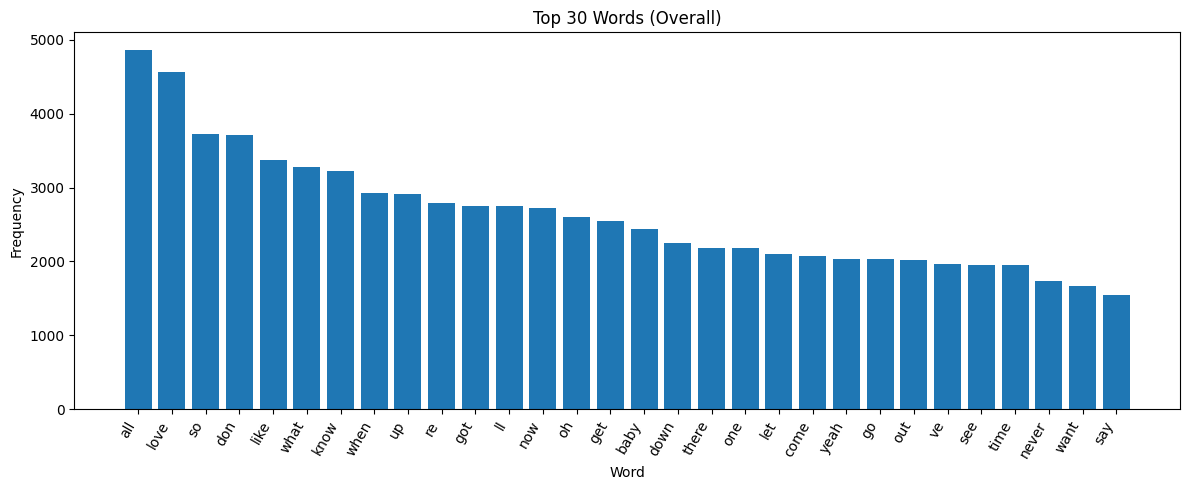


--- Plotting top words (english) ---


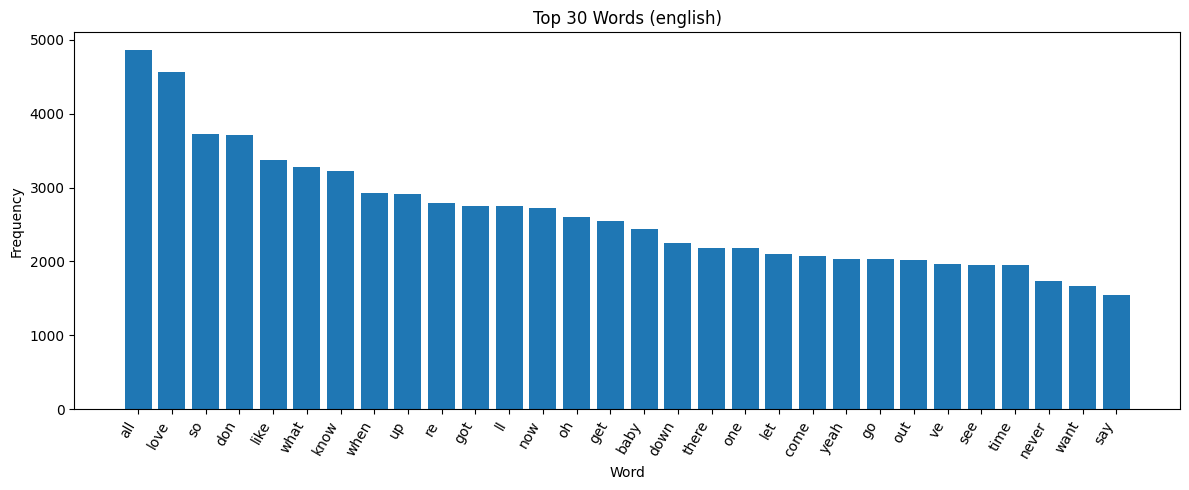


--- Plotting top words (bangla) ---
No tokens to plot for: Top 30 Words (bangla)

--- Plotting top words (mixed) ---
No tokens to plot for: Top 30 Words (mixed)

--- Plotting top words (unknown) ---
No tokens to plot for: Top 30 Words (unknown)

WordCloud library found -> generating wordcloud (overall).


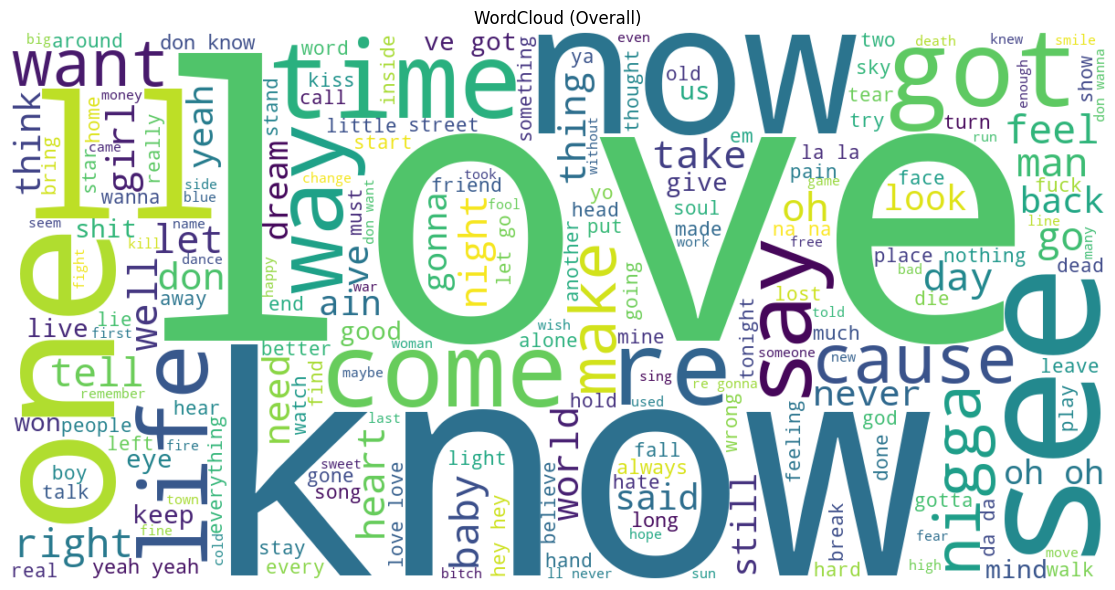

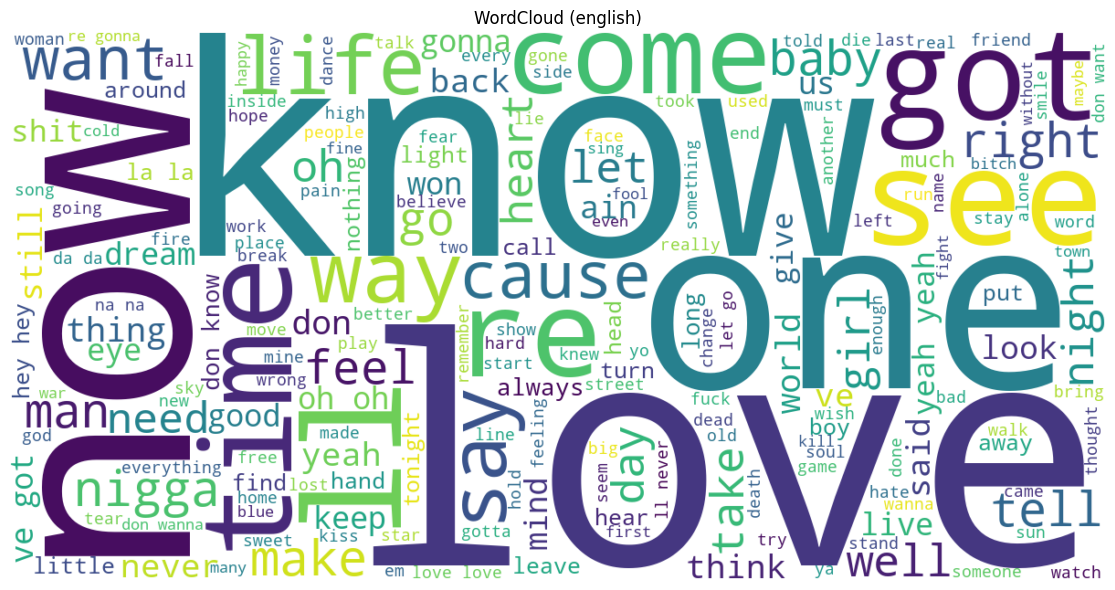


--- Building TF-IDF (baseline) ---
TF-IDF matrix shape: (2568, 5000)
TF-IDF vocab size: 5000
Sample feature names: ['want', 'find', 'out', 'where', 'moon', 'goes', 'when', 'leaves', 'sky', 'night', 'again', 'morning', 'turns', 'gold', 'gonna', 'sleep', 'one', 'eye', 'open', 'keep']
Saved TF-IDF matrix to: Lyrics_Processed\lyrics_tfidf.npz
Saved TF-IDF vectorizer to: Lyrics_Processed\tfidf_vectorizer.joblib

--- Building multilingual SBERT embeddings (optional) ---
Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Encoding 2568 lyric documents...


Batches: 100%|██████████| 81/81 [00:18<00:00,  4.47it/s]


SBERT embeddings shape: (2568, 384)
Saved SBERT embeddings to: Lyrics_Processed\lyrics_sbert_embeddings.npy

Saved cleaned lyrics CSV to: Lyrics_Processed\lyrics_cleaned.csv
Saved shape: (2568, 8)
Saved processing meta JSON to: Lyrics_Processed\lyrics_processing_meta.json

Done, Lyrics preprocessing + representations complete.


In [ ]:
# ==========================================
# Lyrics EDA + Preprocessing + Embeddings
# Path: Data/Lyrics
# ==========================================
# Tasks covered:
# - Load lyrics data (CSV or TXT folder)
# - Check missing/empty/duplicated lyrics
# - Text cleaning (lowercase where applicable, remove punctuation/special chars)
# - Stopword removal
# - Tokenization
# - Representations: TF-IDF (baseline) + multilingual SBERT (if available)
# - Text statistics (word count, vocabulary size)
# - Visualize word distributions (frequency plots + wordcloud if available)
# - Save cleaned text + TF-IDF + embeddings

import os
import re
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# For saving sparse TF-IDF
try:
    from scipy.sparse import save_npz
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# Optional: save vectorizer
try:
    import joblib
    JOBLIB_OK = True
except Exception:
    JOBLIB_OK = False

# -------------------------
# CONFIG
# -------------------------
LYRICS_DIR = "Lyrics"
OUT_DIR = "Lyrics_Processed"

CLEANED_CSV_OUT = os.path.join(OUT_DIR, "lyrics_cleaned.csv")
TFIDF_MATRIX_OUT = os.path.join(OUT_DIR, "lyrics_tfidf.npz")
TFIDF_VECTORIZER_OUT = os.path.join(OUT_DIR, "tfidf_vectorizer.joblib")
SBERT_EMB_OUT = os.path.join(OUT_DIR, "lyrics_sbert_embeddings.npy")
META_JSON_OUT = os.path.join(OUT_DIR, "lyrics_processing_meta.json")

MAX_TFIDF_FEATURES = 5000
NGRAM_RANGE = (1, 2)

# Visualization
TOP_N_WORDS = 30
MAKE_WORDCLOUD = True  # tries if wordcloud is installed (Bangla may need a proper font)

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# 1) Load lyrics data (supports CSV(s) OR TXT files)
# -------------------------
csv_files = sorted(glob.glob(os.path.join(LYRICS_DIR, "*.csv")))
txt_files = sorted(glob.glob(os.path.join(LYRICS_DIR, "*.txt")))

print(f"\nLooking for lyrics in: {LYRICS_DIR}")
print(f"CSV files found: {len(csv_files)}")
print(f"TXT files found: {len(txt_files)}")

def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

records = []

if len(csv_files) > 0:
    print("\n--- Loading from CSV file(s) ---")
    all_dfs = []
    for f in csv_files:
        d = pd.read_csv(f)
        d["__source_file__"] = os.path.basename(f)
        all_dfs.append(d)
        print(f"Loaded {f} shape={d.shape}")
    df_raw = pd.concat(all_dfs, ignore_index=True)

    # Try to guess ID + lyrics columns
    id_col = find_col(df_raw, ["track_id", "song_id", "id", "filename", "file", "path", "title", "name"])
    text_col = find_col(df_raw, ["lyrics", "lyric", "text", "content", "Words"])

    if text_col is None:
        raise ValueError(f"Couldn't find a lyrics column. Columns are: {list(df_raw.columns)}")

    if id_col is None:
        print("No obvious ID column found -> creating 'track_id' from row index.")
        df_raw["track_id"] = [f"row_{i}" for i in range(len(df_raw))]
        id_col = "track_id"

    print(f"\nDetected ID column   : {id_col}")
    print(f"Detected Lyrics column: {text_col}")

    for _, row in df_raw.iterrows():
        records.append({
            "track_id": str(row[id_col]),
            "lyrics_raw": "" if pd.isna(row[text_col]) else str(row[text_col]),
            "source": str(row.get("__source_file__", "csv"))
        })

elif len(txt_files) > 0:
    print("\n--- Loading from TXT file(s) ---")
    for f in txt_files:
        track_id = os.path.splitext(os.path.basename(f))[0]
        try:
            with open(f, "r", encoding="utf-8") as fp:
                text = fp.read()
        except UnicodeDecodeError:
            # fallback
            with open(f, "r", encoding="latin-1") as fp:
                text = fp.read()

        records.append({
            "track_id": track_id,
            "lyrics_raw": text,
            "source": os.path.basename(f)
        })
else:
    raise RuntimeError("No .csv or .txt files found in Data/Lyrics. Put lyrics in CSV or TXT format.")

df = pd.DataFrame(records)
print(f"\nLoaded lyrics records: {len(df)}")
print("\n--- First 5 rows ---")
print(df.head())

# -------------------------
# 2) Check missing, empty, or duplicated lyrics
# -------------------------
print("\n--- Missing/empty checks ---")
df["lyrics_raw"] = df["lyrics_raw"].astype(str)

missing_raw = df["lyrics_raw"].isna().sum()
empty_raw = (df["lyrics_raw"].str.strip() == "").sum()
print(f"Missing lyrics_raw (NaN): {missing_raw}")
print(f"Empty lyrics_raw (after strip): {empty_raw}")

# Remove empty rows (you can keep them if you want, but embeddings/features will be meaningless)
before = len(df)
df = df[df["lyrics_raw"].str.strip() != ""].copy()
after = len(df)
print(f"\nDropped empty lyrics rows: {before - after}")
print(f"Remaining data points: {after}")

# Duplicates (exact raw text duplicates)
dup_count = df.duplicated(subset=["lyrics_raw"]).sum()
print(f"\nDuplicate lyrics (exact raw match): {dup_count}")
if dup_count > 0:
    print("Example duplicates (first 5):")
    print(df[df.duplicated(subset=["lyrics_raw"], keep=False)][["track_id", "source"]].head(5))

# -------------------------
# 3) Detect language (English / Bangla / mixed) (Not Applicable here)
#    (Heuristic: Bengali Unicode range + Latin letters)
# -------------------------
BANGLA_RANGE = re.compile(r"[\u0980-\u09FF]")
LATIN_RANGE = re.compile(r"[A-Za-z]")

def detect_language(text: str) -> str:
    has_bn = bool(BANGLA_RANGE.search(text))
    has_en = bool(LATIN_RANGE.search(text))
    if has_bn and has_en:
        return "mixed"
    if has_bn:
        return "bangla"
    if has_en:
        return "english"
    return "unknown"

df["language"] = df["lyrics_raw"].apply(detect_language)

print("\n--- Language distribution (heuristic) ---")
print(df["language"].value_counts(dropna=False))

# -------------------------
# 4) Text cleaning + 5) Stopword removal + 6) Tokenization
# -------------------------
# Try to use NLTK stopwords if available, else fallback to small built-in lists
EN_STOP = set("""
a an the and or but if then else for to of in on at by from with as is am are was were be been being
i you he she it we they me him her them my your his their our this that these those not no yes
do does did doing have has had having can could should would may might will just than too very
""".split())

try:
    import nltk
    from nltk.corpus import stopwords
    try:
        _ = stopwords.words("english")
        EN_STOP = set(stopwords.words("english"))
        print("\nNLTK English stopwords loaded.")
    except Exception:
        print("\nNLTK found but English stopwords not available (no corpus). Using fallback EN list.")
except Exception:
    print("\nNLTK not installed -> using fallback stopwords lists.")

# Keep only: English letters a-z and spaces
# (digits/punct/special removed)
NON_ALLOWED = re.compile(r"[^a-z\u0980-\u09FF\s]+")

def clean_text(text: str) -> str:
    text = str(text)

    # Lowercase English (Bangla unaffected)
    text = text.lower()

    # Replace non-allowed chars with space
    text = NON_ALLOWED.sub(" ", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Tokenization: capture English words OR Bangla word chunks
TOKEN_PATTERN = re.compile(r"[a-z]+|[\u0980-\u09FF]+")

def tokenize_and_remove_stopwords(cleaned: str):
    tokens = TOKEN_PATTERN.findall(cleaned)
    out = []
    for t in tokens:
        # stopword removal (English + Bangla)
        if t in EN_STOP or t in BN_STOP:
            continue
        # drop 1-char tokens (often noise), keep if you want
        if len(t) <= 1:
            continue
        out.append(t)
    return out

df["lyrics_clean"] = df["lyrics_raw"].apply(clean_text)
df["tokens"] = df["lyrics_clean"].apply(tokenize_and_remove_stopwords)
df["token_count"] = df["tokens"].apply(len)

print("\n--- Cleaned sample (first 3) ---")
for i in range(min(3, len(df))):
    print("\nTrack:", df.iloc[i]["track_id"], "| lang:", df.iloc[i]["language"])
    print("RAW:", df.iloc[i]["lyrics_raw"][:200].replace("\n", " "))
    print("CLEAN:", df.iloc[i]["lyrics_clean"][:200])
    print("TOKENS:", df.iloc[i]["tokens"][:25])

# -------------------------
# 7) Analyze text statistics (word count, vocabulary size)
# -------------------------
all_tokens = [t for toks in df["tokens"] for t in toks]
vocab = set(all_tokens)
print("\n--- Text Statistics ---")
print(f"Total documents: {len(df)}")
print(f"Total tokens (after cleaning+stopwords): {len(all_tokens)}")
print(f"Vocabulary size: {len(vocab)}")
print("\nToken count per doc describe():")
print(df["token_count"].describe())

# -------------------------
# 8) Visualize word distributions
#    - Frequency bar plot (overall + per-language)
#    - Wordcloud if available
# -------------------------
def plot_top_words(tokens_list, title):
    counter = Counter(tokens_list)
    top = counter.most_common(TOP_N_WORDS)
    if len(top) == 0:
        print(f"No tokens to plot for: {title}")
        return
    words, counts = zip(*top)
    plt.figure(figsize=(12, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

print("\n--- Plotting top words (overall) ---")
plot_top_words(all_tokens, f"Top {TOP_N_WORDS} Words (Overall)")

for lang in ["english", "bangla", "mixed", "unknown"]:
    subset_tokens = [t for toks in df[df["language"] == lang]["tokens"] for t in toks]
    print(f"\n--- Plotting top words ({lang}) ---")
    plot_top_words(subset_tokens, f"Top {TOP_N_WORDS} Words ({lang})")

# Wordcloud (optional)
if MAKE_WORDCLOUD:
    try:
        from wordcloud import WordCloud
        print("\nWordCloud library found -> generating wordcloud (overall).")

        text_for_wc = " ".join(all_tokens)
        wc = WordCloud(width=1200, height=600, background_color="white").generate(text_for_wc)
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title("WordCloud (Overall)")
        plt.tight_layout()
        plt.show()

        # Per-language wordclouds (may render Bangla poorly without a Bangla font)
        for lang in ["english", "bangla", "mixed"]:
            subset_tokens = [t for toks in df[df["language"] == lang]["tokens"] for t in toks]
            if len(subset_tokens) == 0:
                continue
            wc_text = " ".join(subset_tokens)
            wc_lang = WordCloud(width=1200, height=600, background_color="white").generate(wc_text)
            plt.figure(figsize=(12, 6))
            plt.imshow(wc_lang, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"WordCloud ({lang})")
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print("\nWordCloud not available or failed to render:", str(e))
        print("Skipping wordclouds; frequency plots already generated.")

# -------------------------
# 9) Generate lyric representations
#    A) TF-IDF vectors (baseline)
# -------------------------
print("\n--- Building TF-IDF (baseline) ---")
# Use cleaned text AFTER stopword removal by joining tokens (more controlled)
df["text_for_models"] = df["tokens"].apply(lambda toks: " ".join(toks))

vectorizer = TfidfVectorizer(
    max_features=MAX_TFIDF_FEATURES,
    ngram_range=NGRAM_RANGE,
    token_pattern=r"(?u)\b[a-z\u0980-\u09FF]{2,}\b"  # supports Bangla+English tokens
)

tfidf = vectorizer.fit_transform(df["text_for_models"].values)

print("TF-IDF matrix shape:", tfidf.shape)
print("TF-IDF vocab size:", len(vectorizer.vocabulary_))
print("Sample feature names:", list(vectorizer.vocabulary_.keys())[:20])

# Save TF-IDF
if SCIPY_OK:
    save_npz(TFIDF_MATRIX_OUT, tfidf)
    print("Saved TF-IDF matrix to:", TFIDF_MATRIX_OUT)
else:
    print("scipy not available -> cannot save .npz TF-IDF matrix. Install scipy to enable this.")

if JOBLIB_OK:
    joblib.dump(vectorizer, TFIDF_VECTORIZER_OUT)
    print("Saved TF-IDF vectorizer to:", TFIDF_VECTORIZER_OUT)
else:
    print("joblib not available -> cannot save vectorizer. Install joblib to enable this.")

# -------------------------
# 9) Generate lyric representations
#    B) Pretrained embeddings (multilingual SBERT) - optional
# -------------------------
print("\n--- Building multilingual SBERT embeddings (optional) ---")
SBERT_OK = True
try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    SBERT_OK = False
    print("sentence-transformers not installed. To enable SBERT embeddings:")
    print("  pip install sentence-transformers")
    print("Skipping SBERT.")

if SBERT_OK:
    try:
        model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        print("Loading model:", model_name)
        sbert = SentenceTransformer(model_name)

        texts = df["lyrics_clean"].tolist()  # you can also use df["text_for_models"]
        print(f"Encoding {len(texts)} lyric documents...")

        emb = sbert.encode(texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
        print("SBERT embeddings shape:", emb.shape)

        np.save(SBERT_EMB_OUT, emb.astype(np.float32))
        print("Saved SBERT embeddings to:", SBERT_EMB_OUT)

    except Exception as e:
        print("SBERT embedding step failed:", str(e))
        print("This can happen if the model can't download in your environment.")
        print("TF-IDF baseline is still saved and usable.")

# -------------------------
# 10) Save cleaned text + metadata
# -------------------------
# Save tokens as a string (CSV-friendly)
df_to_save = df.drop(columns=["tokens"]).copy()
df_to_save["tokens_str"] = df["tokens"].apply(lambda toks: " ".join(toks))

df_to_save.to_csv(CLEANED_CSV_OUT, index=False)
print("\nSaved cleaned lyrics CSV to:", CLEANED_CSV_OUT)
print("Saved shape:", df_to_save.shape)

meta = {
    "lyrics_dir": LYRICS_DIR,
    "out_dir": OUT_DIR,
    "tfidf_max_features": MAX_TFIDF_FEATURES,
    "tfidf_ngram_range": NGRAM_RANGE,
    "top_n_words_visualized": TOP_N_WORDS,
    "num_docs_saved": int(len(df_to_save)),
    "language_counts": df["language"].value_counts().to_dict(),
}
with open(META_JSON_OUT, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Saved processing meta JSON to:", META_JSON_OUT)

print("\nDone, Lyrics preprocessing + representations complete.")

Device: cpu

Found 3554 feature files in: Audio_Features
Loaded lyrics metadata: 2568 track_id -> language mappings

--- Feature matrix built ---
X shape: (3554, 80)
Tracks used: 3554
Skipped files: 0

Sample track IDs: ['A001', 'A002', 'A003', 'A004', 'A005']
Language counts (if available):
english    2083
unknown    1471
Name: count, dtype: int64

Standardized X: mean ~ 0.0 std ~ 1.0
Saved scaler params to: Results/EasyTask\scaler_params.npz

===== Training VAE =====
Epoch 001 | loss=0.9706 | recon=0.9460 | kl=0.0246
Epoch 005 | loss=0.7519 | recon=0.6385 | kl=0.1134
Epoch 010 | loss=0.7155 | recon=0.6034 | kl=0.1121
Epoch 015 | loss=0.7068 | recon=0.5913 | kl=0.1155
Epoch 020 | loss=0.7027 | recon=0.5807 | kl=0.1220
Epoch 025 | loss=0.6994 | recon=0.5772 | kl=0.1222
Epoch 030 | loss=0.6955 | recon=0.5731 | kl=0.1223
Epoch 035 | loss=0.6951 | recon=0.5692 | kl=0.1259
Epoch 040 | loss=0.6945 | recon=0.5696 | kl=0.1248
Saved VAE model to: Results/EasyTask\vae_mlp.pth

Latent Z (VAE) sh

c:\Users\T2510603\Downloads\Data\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



2D embedding computed using: UMAP


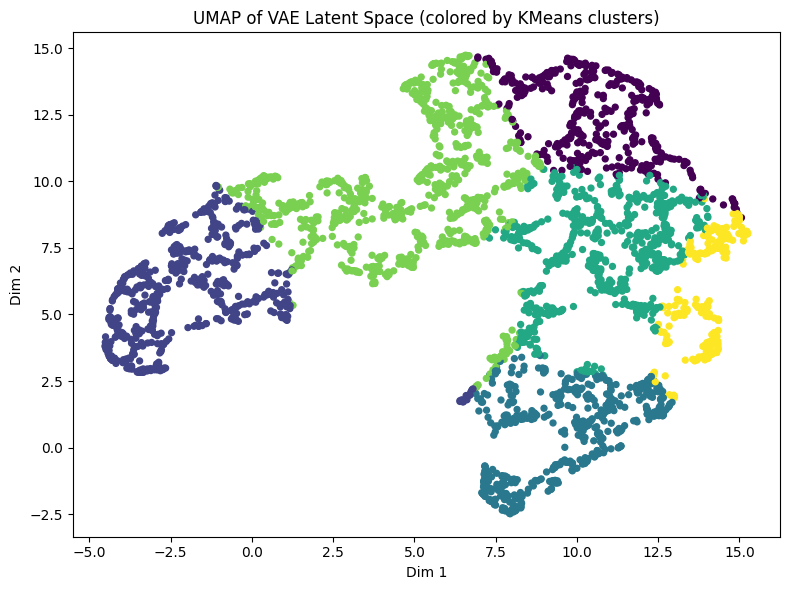

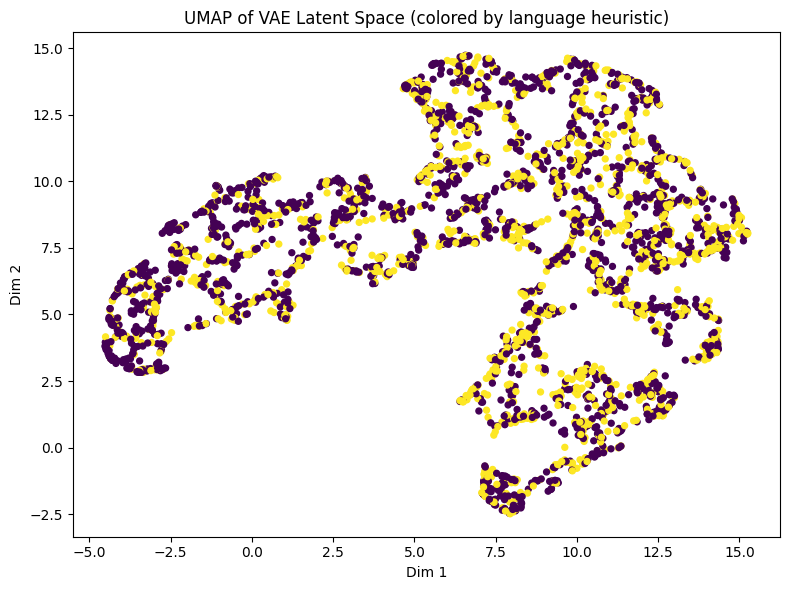


Saved cluster assignments to: Results/EasyTask\cluster_assignments.csv

Sample assignments:
  track_id language  cluster_vae  cluster_pca
0     A001  unknown            3            4
1     A002  unknown            4            2
2     A003  unknown            3            0
3     A004  unknown            3            4
4     A005  unknown            4            2
5     A010  unknown            1            3
6     A011  unknown            4            2
7     A013  unknown            4            2
8     A014  unknown            1            3
9     A017  unknown            2            1

DONE Easy task complete.
Outputs saved in: Results/EasyTask


In [ ]:
# ==========================================================
# EASY TASK: Basic VAE -> K-Means clustering + Visualization
# + Baseline: PCA + K-Means
# Metrics: Silhouette Score, Calinski–Harabasz Index
# ==========================================================

# This easy pipeline uses AUDIO MFCC summary vectors (mean+std across time)
# to keep input dimension small for a basic MLP-VAE.

import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# PyTorch (VAE)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# UMAP
UMAP_OK = True
try:
    import umap
except Exception:
    UMAP_OK = False

# t-SNE fallback
from sklearn.manifold import TSNE

# -------------------------
# CONFIG
# -------------------------
AUDIO_FEATURE_DIR = "Audio_Features"               # where .npz features were saved
LYRICS_CSV = "Lyrics_Processed/lyrics_cleaned.csv" # for language metadata (optional)
OUT_DIR = "Results/EasyTask"
os.makedirs(OUT_DIR, exist_ok=True)

USE_FEATURE = "mfcc"         # "mfcc" recommended for easy task
VECTORIZE = "mean_std"       # "mean_std" => [mean(mfcc), std(mfcc)] -> 2*N_MFCC dims
RANDOM_SEED = 42
SAMPLE_SIZE = None           # set e.g. 200 for a small dataset; None = use all
BATCH_SIZE = 32
EPOCHS = 40
LR = 1e-3
LATENT_DIM = 16              # VAE latent dimension
HIDDEN_DIMS = [128, 64]      # encoder/decoder hidden sizes
K_CLUSTERS = 6               # choose based on your dataset; you can tune later
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Device:", DEVICE)

# -------------------------
# 1) Load audio feature files
# -------------------------
npz_files = sorted(glob.glob(os.path.join(AUDIO_FEATURE_DIR, "*.npz")))
print(f"\nFound {len(npz_files)} feature files in: {AUDIO_FEATURE_DIR}")
if len(npz_files) == 0:
    raise RuntimeError("No .npz files found. Make sure you generated audio features first.")

if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(npz_files):
    npz_files = random.sample(npz_files, SAMPLE_SIZE)
    npz_files = sorted(npz_files)
    print(f"Using a random subset: {len(npz_files)} files")

# -------------------------
# 2) Optional: load lyrics language metadata for analysis/plots
# -------------------------
lang_map = {}
if os.path.exists(LYRICS_CSV):
    lyr = pd.read_csv(LYRICS_CSV)
    if "track_id" in lyr.columns and "language" in lyr.columns:
        # Map track_id -> language
        lang_map = dict(zip(lyr["track_id"].astype(str), lyr["language"].astype(str)))
        print(f"Loaded lyrics metadata: {len(lang_map)} track_id -> language mappings")
    else:
        print("Lyrics CSV found but missing columns track_id/language -> skipping language merge.")
else:
    print("Lyrics CSV not found -> language metadata will be skipped.")

def stem_from_path(p):
    return os.path.splitext(os.path.basename(p))[0]

# -------------------------
# 3) Build feature vectors (MFCC mean+std across time)
# -------------------------
X_list = []
ids = []
langs = []
skipped = 0

for fp in npz_files:
    tid = stem_from_path(fp)
    try:
        d = np.load(fp, allow_pickle=True)
        if USE_FEATURE not in d:
            raise KeyError(f"'{USE_FEATURE}' not found in {fp}. Available keys: {list(d.keys())}")

        feat = d[USE_FEATURE]  # e.g. mfcc: (N_MFCC, T)
        if feat.ndim != 2:
            raise ValueError(f"Expected 2D feature (C,T). Got shape: {feat.shape}")

        if VECTORIZE == "mean_std":
            mu = feat.mean(axis=1)              # (C,)
            sd = feat.std(axis=1)               # (C,)
            vec = np.concatenate([mu, sd], axis=0)  # (2C,)
        else:
            # fallback: flatten (NOT recommended for easy task if too large)
            vec = feat.reshape(-1)

        X_list.append(vec.astype(np.float32))
        ids.append(tid)
        langs.append(lang_map.get(tid, "unknown"))

    except Exception as e:
        skipped += 1
        print(f"Skipping {fp} بسبب error: {type(e).__name__}: {e}")

X = np.vstack(X_list)
print("\n--- Feature matrix built ---")
print("X shape:", X.shape)
print("Tracks used:", len(ids))
print("Skipped files:", skipped)

# Quick check
print("\nSample track IDs:", ids[:5])
print("Language counts (if available):")
print(pd.Series(langs).value_counts())

# -------------------------
# 4) Standardize input features (important for VAE + PCA)
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nStandardized X: mean ~", X_scaled.mean().round(4), "std ~", X_scaled.std().round(4))

# Save scaler params (for reproducibility)
np.savez(os.path.join(OUT_DIR, "scaler_params.npz"),
         mean=scaler.mean_.astype(np.float32),
         scale=scaler.scale_.astype(np.float32))
print("Saved scaler params to:", os.path.join(OUT_DIR, "scaler_params.npz"))

# ==========================================================
# 5) Basic VAE (MLP) Implementation
# ==========================================================
class NumpyDataset(Dataset):
    def __init__(self, X_np):
        self.X = torch.from_numpy(X_np.astype(np.float32))
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx]

class MLPVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        # Encoder
        enc_layers = []
        prev = input_dim
        for h in hidden_dims:
            enc_layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        self.encoder = nn.Sequential(*enc_layers)
        self.fc_mu = nn.Linear(prev, latent_dim)
        self.fc_logvar = nn.Linear(prev, latent_dim)

        # Decoder (mirror)
        dec_layers = []
        prev = latent_dim
        for h in reversed(hidden_dims):
            dec_layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        dec_layers += [nn.Linear(prev, input_dim)]
        self.decoder = nn.Sequential(*dec_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction (MSE) + KL
    recon = torch.mean((x_hat - x) ** 2)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl

# -------------------------
# 6) Train VAE
# -------------------------
input_dim = X_scaled.shape[1]
vae = MLPVAE(input_dim, HIDDEN_DIMS, LATENT_DIM).to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

ds = NumpyDataset(X_scaled)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

print("\n===== Training VAE =====")
vae.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    for xb in dl:
        xb = xb.to(DEVICE)
        x_hat, mu, logvar = vae(xb)
        loss, recon, kl = vae_loss(xb, x_hat, mu, logvar)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * xb.size(0)
        total_recon += recon.item() * xb.size(0)
        total_kl += kl.item() * xb.size(0)

    n = len(ds)
    if epoch == 1 or epoch % 5 == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch:03d} | loss={total_loss/n:.4f} | recon={total_recon/n:.4f} | kl={total_kl/n:.4f}")

# Save model
torch.save(vae.state_dict(), os.path.join(OUT_DIR, "vae_mlp.pth"))
print("Saved VAE model to:", os.path.join(OUT_DIR, "vae_mlp.pth"))

# -------------------------
# 7) Extract latent representations (use mu as embedding)
# -------------------------
vae.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_scaled.astype(np.float32)).to(DEVICE)
    _, mu, _ = vae(X_tensor)
    Z_vae = mu.cpu().numpy()

print("\nLatent Z (VAE) shape:", Z_vae.shape)
np.save(os.path.join(OUT_DIR, "Z_vae.npy"), Z_vae.astype(np.float32))
print("Saved latent features to:", os.path.join(OUT_DIR, "Z_vae.npy"))

# ==========================================================
# 8) Clustering on latent features: K-Means
# ==========================================================
print("\n===== K-Means on VAE latent features =====")
kmeans_vae = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init="auto")
labels_vae = kmeans_vae.fit_predict(Z_vae)

sil_vae = silhouette_score(Z_vae, labels_vae) if len(set(labels_vae)) > 1 else np.nan
ch_vae = calinski_harabasz_score(Z_vae, labels_vae) if len(set(labels_vae)) > 1 else np.nan

print(f"VAE + KMeans | Silhouette: {sil_vae:.4f} | Calinski-Harabasz: {ch_vae:.2f}")

# ==========================================================
# 9) Baseline: PCA + K-Means
# ==========================================================
print("\n===== Baseline: PCA + K-Means =====")
pca = PCA(n_components=LATENT_DIM, random_state=RANDOM_SEED)
Z_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init="auto")
labels_pca = kmeans_pca.fit_predict(Z_pca)

sil_pca = silhouette_score(Z_pca, labels_pca) if len(set(labels_pca)) > 1 else np.nan
ch_pca = calinski_harabasz_score(Z_pca, labels_pca) if len(set(labels_pca)) > 1 else np.nan

print(f"PCA + KMeans | Silhouette: {sil_pca:.4f} | Calinski-Harabasz: {ch_pca:.2f}")

# Save metrics
metrics_df = pd.DataFrame([
    {"method": "VAE+KMeans", "silhouette": sil_vae, "calinski_harabasz": ch_vae},
    {"method": "PCA+KMeans", "silhouette": sil_pca, "calinski_harabasz": ch_pca},
])
metrics_path = os.path.join(OUT_DIR, "easy_task_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("\nSaved metrics to:", metrics_path)
print(metrics_df)

# ==========================================================
# 10) Visualization: UMAP (preferred) or t-SNE
# ==========================================================
def embed_2d(X_in, method="umap"):
    if method == "umap" and UMAP_OK:
        reducer = umap.UMAP(
            n_components=2,
            random_state=RANDOM_SEED,
            n_neighbors=15,
            min_dist=0.1
        )
        return reducer.fit_transform(X_in), "UMAP"
    else:
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, init="pca")
        return tsne.fit_transform(X_in), "t-SNE"

# 2D embedding for VAE latent
Z2_vae, viz_name = embed_2d(Z_vae, method="umap")
print(f"\n2D embedding computed using: {viz_name}")

# Plot: clusters
plt.figure(figsize=(8, 6))
plt.scatter(Z2_vae[:, 0], Z2_vae[:, 1], c=labels_vae, s=18)
plt.title(f"{viz_name} of VAE Latent Space (colored by KMeans clusters)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "vae_clusters_2d.png"), dpi=200)
plt.show()

# Optional plot: language overlay (if you have lyrics metadata)
lang_series = pd.Series(langs)
if (lang_series != "unknown").any():
    # Map languages to integer colors for a clean scatter
    lang_to_int = {l:i for i,l in enumerate(sorted(lang_series.unique()))}
    lang_int = np.array([lang_to_int[l] for l in lang_series])

    plt.figure(figsize=(8, 6))
    plt.scatter(Z2_vae[:, 0], Z2_vae[:, 1], c=lang_int, s=18)
    plt.title(f"{viz_name} of VAE Latent Space (colored by language heuristic)")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "vae_language_2d.png"), dpi=200)
    plt.show()
else:
    print("Language metadata mostly unknown -> skipping language plot.")

# ==========================================================
# 11) Save clustering assignments for inspection
# ==========================================================
out_assign = pd.DataFrame({
    "track_id": ids,
    "language": langs,
    "cluster_vae": labels_vae,
    "cluster_pca": labels_pca,
})
assign_path = os.path.join(OUT_DIR, "cluster_assignments.csv")
out_assign.to_csv(assign_path, index=False)
print("\nSaved cluster assignments to:", assign_path)
print("\nSample assignments:")
print(out_assign.head(10))

print("\nDONE Easy task complete.")
print(f"Outputs saved in: {OUT_DIR}")

In [7]:
# ==========================================
# Multi-Modal Preprocessing (Audio + Lyrics + Genre)
# ==========================================
# Covers:
# - Align audio, lyrics, and genre by track_id (derived from filename/stem)
# - Handle missing modalities (audio-only / lyrics-only / etc.)
# - Fuse features (concat)
# - Normalize features across modalities (separately + combined)
# - Store unified feature vectors for clustering / VAE input
#
# Assumptions (based on earlier scripts):
# - Audio features saved as: Data/Audio_Features/<track_id>.npz with keys: mel_db, mfcc
# - Lyrics cleaned CSV saved as: Data/Lyrics_Processed/lyrics_cleaned.csv with column: track_id
# - Lyrics TF-IDF saved as: Data/Lyrics_Processed/lyrics_tfidf.npz (optional)
# - Lyrics SBERT saved as: Data/Lyrics_Processed/lyrics_sbert_embeddings.npy (optional)
# - Genre processed CSV saved as: Data/genre_processed.csv with one-hot columns genre__*
#
# NOTE:
# You can choose ONE lyrics representation: TF-IDF (baseline) or SBERT (recommended).
# This script defaults to SBERT if available; otherwise uses TF-IDF if available.

import os
import glob
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Optional sparse load for TF-IDF
TFIDF_OK = True
try:
    from scipy.sparse import load_npz
except Exception:
    TFIDF_OK = False

# -------------------------
# CONFIG
# -------------------------
AUDIO_FEAT_DIR = "Audio_Features"          # contains <track_id>.npz
LYRICS_CLEANED_CSV = "Lyrics_Processed/lyrics_cleaned.csv"
LYRICS_TFIDF_NPZ = "Lyrics_Processed/lyrics_tfidf.npz"
LYRICS_SBERT_NPY = "Lyrics_Processed/lyrics_sbert_embeddings.npy"
GENRE_PROCESSED_CSV = "genre_processed.csv"  # from your genre script

OUT_DIR = "MultiModal"
OUT_FEATURES_NPY = os.path.join(OUT_DIR, "X_multimodal.npy")
OUT_META_CSV = os.path.join(OUT_DIR, "multimodal_metadata.csv")
OUT_SPLITS_JSON = os.path.join(OUT_DIR, "multimodal_config.json")

# Choose which audio feature to use as VAE/CNN input:
#   - "mfcc_mean"  : mean over time (vector)
#   - "mel_mean"   : mean over time (vector)
#   - "mfcc_flat"  : flatten 2D MFCC -> vector (bigger)
#   - "mel_flat"   : flatten 2D Mel -> vector (bigger)
AUDIO_REPR = "mfcc_mean"

# Lyrics representation preference order
PREFER_SBERT = True

# Missing modality handling:
# - If a modality is missing, we fill with zeros of correct size and store flags
FILL_MISSING_WITH_ZEROS = True

# Normalization
# - Normalize each modality separately then concatenate (recommended)
NORMALIZE_PER_MODALITY = True

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# Helpers
# -------------------------
def load_audio_vector(npz_path: str, audio_repr: str) -> np.ndarray:
    d = np.load(npz_path)
    mel = d["mel_db"]  # shape (N_MELS, T)
    mfcc = d["mfcc"]   # shape (N_MFCC, T)

    if audio_repr == "mfcc_mean":
        v = mfcc.mean(axis=1)  # (N_MFCC,)
    elif audio_repr == "mel_mean":
        v = mel.mean(axis=1)   # (N_MELS,)
    elif audio_repr == "mfcc_flat":
        v = mfcc.reshape(-1)
    elif audio_repr == "mel_flat":
        v = mel.reshape(-1)
    else:
        raise ValueError(f"Unknown AUDIO_REPR: {audio_repr}")
    return v.astype(np.float32)

def stem_from_path(p: str):
    base = os.path.basename(p)
    stem, _ = os.path.splitext(base)
    return stem

def get_genre_onehot_cols(df_genre: pd.DataFrame):
    return [c for c in df_genre.columns if c.startswith("genre__")]

def safe_np_load(path: str):
    try:
        return np.load(path)
    except Exception:
        return None

# -------------------------
# 1) Load modality sources
# -------------------------
# Audio: list available tracks
audio_npz_files = sorted(glob.glob(os.path.join(AUDIO_FEAT_DIR, "*.npz")))
audio_track_ids = [stem_from_path(p) for p in audio_npz_files]
audio_map = dict(zip(audio_track_ids, audio_npz_files))

print(f"\nAudio feature files: {len(audio_npz_files)} in {AUDIO_FEAT_DIR}")

# Lyrics cleaned
lyrics_df = pd.read_csv(LYRICS_CLEANED_CSV)
if "track_id" not in lyrics_df.columns:
    raise ValueError(f"'track_id' not found in {LYRICS_CLEANED_CSV}. Columns: {list(lyrics_df.columns)}")

lyrics_df["track_id"] = lyrics_df["track_id"].astype(str)
print(f"Lyrics records: {len(lyrics_df)} in {LYRICS_CLEANED_CSV}")

# Genre processed
genre_df = pd.read_csv(GENRE_PROCESSED_CSV)
if "Genres" not in genre_df.columns:
    print("Warning: 'Genres' column not found in genre_processed.csv (ok if you saved differently).")
# Try to find an ID column
possible_id_cols = [c for c in genre_df.columns if c.lower() in ["track_id", "song_id", "id", "filename", "file", "path", "title", "name"]]
if len(possible_id_cols) == 0:
    print("\n⚠️ Could not detect a track ID column in genre_processed.csv.")
    print("Add a 'track_id' column to genre.csv/genre_processed.csv that matches audio/lyrics stems.")
    print("Proceeding will likely fail alignment.")
    genre_id_col = None
else:
    genre_id_col = possible_id_cols[0]

if genre_id_col is not None:
    genre_df[genre_id_col] = genre_df[genre_id_col].astype(str)
    genre_cols = get_genre_onehot_cols(genre_df)
    print(f"Genre records: {len(genre_df)} | One-hot genre columns: {len(genre_cols)} | ID col: {genre_id_col}")
else:
    genre_cols = []

# -------------------------
# 2) Load lyrics embeddings (SBERT preferred, else TF-IDF)
# -------------------------
lyrics_repr_name = None
lyrics_matrix = None

if PREFER_SBERT and os.path.exists(LYRICS_SBERT_NPY):
    lyrics_matrix = np.load(LYRICS_SBERT_NPY)  # aligned by row order of lyrics_df in the script that created it
    lyrics_repr_name = "sbert"
    print(f"\nLoaded SBERT embeddings: {lyrics_matrix.shape} from {LYRICS_SBERT_NPY}")
elif TFIDF_OK and os.path.exists(LYRICS_TFIDF_NPZ):
    lyrics_matrix = load_npz(LYRICS_TFIDF_NPZ)  # sparse
    lyrics_repr_name = "tfidf"
    print(f"\nLoaded TF-IDF matrix: {lyrics_matrix.shape} (sparse) from {LYRICS_TFIDF_NPZ}")
else:
    raise RuntimeError(
        "No lyrics embeddings found. Expected SBERT .npy or TF-IDF .npz. "
        "Run the lyrics preprocessing script first."
    )

# Ensure lyrics_df and embeddings align: assumes embeddings were created in the same order as lyrics_df rows.
# If you changed/filtered lyrics_df after saving embeddings, rebuild embeddings or store a mapping.
if lyrics_matrix.shape[0] != len(lyrics_df):
    raise ValueError(
        f"Embeddings rows ({lyrics_matrix.shape[0]}) do not match lyrics_df rows ({len(lyrics_df)}). "
        "Recreate embeddings with the current lyrics_cleaned.csv."
    )

# Build lyrics lookup by track_id
lyrics_track_ids = lyrics_df["track_id"].tolist()
if lyrics_repr_name == "sbert":
    lyrics_map = {tid: lyrics_matrix[i].astype(np.float32) for i, tid in enumerate(lyrics_track_ids)}
elif lyrics_repr_name == "tfidf":
    # store row index for sparse later
    lyrics_map = {tid: i for i, tid in enumerate(lyrics_track_ids)}

print(f"Lyrics repr in use: {lyrics_repr_name}")

# -------------------------
# 3) Create unified track ID set + alignment
# -------------------------
all_ids = set(audio_track_ids) | set(lyrics_track_ids)
if genre_id_col is not None:
    all_ids |= set(genre_df[genre_id_col].tolist())

all_ids = sorted(list(all_ids))
print(f"\nTotal unique track_ids across modalities: {len(all_ids)}")

# Determine fixed dimensions for missing fills
# Audio dim:
audio_dim = None
for tid in audio_track_ids[:50]:
    try:
        audio_dim = load_audio_vector(audio_map[tid], AUDIO_REPR).shape[0]
        break
    except Exception:
        continue
if audio_dim is None:
    raise RuntimeError("Could not infer audio feature dimension. Check your audio .npz files.")

# Lyrics dim:
if lyrics_repr_name == "sbert":
    lyrics_dim = int(lyrics_matrix.shape[1])
else:
    lyrics_dim = int(lyrics_matrix.shape[1])  # number of TF-IDF features

# Genre dim:
genre_dim = len(genre_cols)

print("\n--- Inferred modality dimensions ---")
print("Audio dim :", audio_dim, f"({AUDIO_REPR})")
print("Lyrics dim:", lyrics_dim, f"({lyrics_repr_name})")
print("Genre dim :", genre_dim)

# -------------------------
# 4) Build aligned feature rows with missing modality handling
# -------------------------
X_audio = []
X_lyrics = []
X_genre = []
meta_rows = []

# Make a quick genre lookup
genre_lookup = {}
if genre_id_col is not None and genre_dim > 0:
    tmp = genre_df[[genre_id_col] + genre_cols].copy()
    for _, r in tmp.iterrows():
        genre_lookup[str(r[genre_id_col])] = r[genre_cols].values.astype(np.float32)

# For TF-IDF sparse: we’ll fetch rows on demand
def get_lyrics_vec(tid: str):
    if lyrics_repr_name == "sbert":
        return lyrics_map.get(tid, None)
    else:
        idx = lyrics_map.get(tid, None)
        if idx is None:
            return None
        row = lyrics_matrix.getrow(idx).toarray().reshape(-1).astype(np.float32)
        return row

for tid in all_ids:
    has_audio = tid in audio_map
    has_lyrics = tid in lyrics_map
    has_genre = tid in genre_lookup if (genre_id_col is not None and genre_dim > 0) else False

    # Audio
    if has_audio:
        try:
            av = load_audio_vector(audio_map[tid], AUDIO_REPR)
        except Exception:
            has_audio = False
            av = None
    else:
        av = None

    # Lyrics
    lv = get_lyrics_vec(tid)
    if lv is None:
        has_lyrics = False

    # Genre
    gv = genre_lookup.get(tid, None) if (genre_id_col is not None and genre_dim > 0) else None
    if gv is None:
        has_genre = False

    # Missing fills
    if FILL_MISSING_WITH_ZEROS:
        if av is None:
            av = np.zeros((audio_dim,), dtype=np.float32)
        if lv is None:
            lv = np.zeros((lyrics_dim,), dtype=np.float32)
        if gv is None:
            gv = np.zeros((genre_dim,), dtype=np.float32)

    X_audio.append(av)
    X_lyrics.append(lv)
    X_genre.append(gv)

    meta_rows.append({
        "track_id": tid,
        "has_audio": int(has_audio),
        "has_lyrics": int(has_lyrics),
        "has_genre": int(has_genre),
        "audio_path": audio_map.get(tid, ""),
    })

X_audio = np.vstack(X_audio).astype(np.float32)
X_lyrics = np.vstack(X_lyrics).astype(np.float32)
X_genre = np.vstack(X_genre).astype(np.float32) if genre_dim > 0 else np.zeros((len(all_ids), 0), dtype=np.float32)

meta = pd.DataFrame(meta_rows)

print("\n--- Missing modality summary ---")
print(meta[["has_audio", "has_lyrics", "has_genre"]].sum())
print("\nRows with any missing modality:", int(((meta["has_audio"] == 0) | (meta["has_lyrics"] == 0) | (meta["has_genre"] == 0)).sum()))
print("Rows with audio-only:", int(((meta["has_audio"] == 1) & (meta["has_lyrics"] == 0)).sum()))
print("Rows with lyrics-only:", int(((meta["has_audio"] == 0) & (meta["has_lyrics"] == 1)).sum()))

# -------------------------
# 5) Normalize features across modalities
# -------------------------
# Recommended: normalize each modality independently so one doesn't dominate.
if NORMALIZE_PER_MODALITY:
    scaler_audio = StandardScaler(with_mean=True, with_std=True)
    scaler_lyrics = StandardScaler(with_mean=True, with_std=True)
    X_audio_z = scaler_audio.fit_transform(X_audio)
    X_lyrics_z = scaler_lyrics.fit_transform(X_lyrics)

    if genre_dim > 0:
        # Genre is 0/1 multi-hot; scaling is optional. We'll keep as-is by default.
        X_genre_z = X_genre
    else:
        X_genre_z = X_genre

    # Concatenate fused vector
    X = np.concatenate([X_audio_z, X_lyrics_z, X_genre_z], axis=1).astype(np.float32)

    print("\nNormalized per modality (Audio + Lyrics), Genre kept as multi-hot.")
else:
    X_raw = np.concatenate([X_audio, X_lyrics, X_genre], axis=1).astype(np.float32)
    scaler_all = StandardScaler(with_mean=True, with_std=True)
    X = scaler_all.fit_transform(X_raw).astype(np.float32)
    print("\nNormalized after concatenation (single scaler over all features).")

print("\n--- Final fused feature matrix ---")
print("X shape:", X.shape)

# -------------------------
# 6) Store unified feature vectors + metadata
# -------------------------
np.save(OUT_FEATURES_NPY, X)
meta.to_csv(OUT_META_CSV, index=False)

print("\nSaved:")
print(" - Unified feature matrix:", OUT_FEATURES_NPY)
print(" - Metadata:", OUT_META_CSV)

# Save config (for reproducibility / later loading)
config = {
    "audio_feat_dir": AUDIO_FEAT_DIR,
    "lyrics_cleaned_csv": LYRICS_CLEANED_CSV,
    "genre_processed_csv": GENRE_PROCESSED_CSV,
    "audio_repr": AUDIO_REPR,
    "lyrics_repr": lyrics_repr_name,
    "target_dims": {
        "audio_dim": int(audio_dim),
        "lyrics_dim": int(lyrics_dim),
        "genre_dim": int(genre_dim),
        "fused_dim": int(X.shape[1]),
    },
    "missing_handling": {
        "fill_missing_with_zeros": bool(FILL_MISSING_WITH_ZEROS),
        "normalized_per_modality": bool(NORMALIZE_PER_MODALITY),
    },
    "notes": "X_multimodal.npy is ready for clustering (KMeans/DBSCAN/etc.) or VAE input."
}

with open(OUT_SPLITS_JSON, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2)

print(" - Config:", OUT_SPLITS_JSON)

# -------------------------
# 7) Quick sanity prints (see what is happening)
# -------------------------
print("\n--- First 5 rows (track_id + modality flags) ---")
print(meta.head())

print("\n--- Feature vector preview (first row, first 20 dims) ---")
print(X[0, :20])

print("\nDone, Multi-modal alignment + fusion complete.")


Audio feature files: 3554 in Audio_Features
Lyrics records: 2568 in Lyrics_Processed/lyrics_cleaned.csv
Genre records: 2184 | One-hot genre columns: 158 | ID col: Title

Loaded SBERT embeddings: (2568, 384) from Lyrics_Processed/lyrics_sbert_embeddings.npy
Lyrics repr in use: sbert

Total unique track_ids across modalities: 6146

--- Inferred modality dimensions ---
Audio dim : 40 (mfcc_mean)
Lyrics dim: 384 (sbert)
Genre dim : 158

--- Missing modality summary ---
has_audio     3554
has_lyrics    2568
has_genre     2107
dtype: int64

Rows with any missing modality: 6146
Rows with audio-only: 1471
Rows with lyrics-only: 485

Normalized per modality (Audio + Lyrics), Genre kept as multi-hot.

--- Final fused feature matrix ---
X shape: (6146, 582)

Saved:
 - Unified feature matrix: MultiModal\X_multimodal.npy
 - Metadata: MultiModal\multimodal_metadata.csv
 - Config: MultiModal\multimodal_config.json

--- First 5 rows (track_id + modality flags) ---
                                    

Device: cpu

Loaded X: (6146, 582) from MultiModal/X_multimodal.npy
Loaded metadata: (6146, 5) from MultiModal/multimodal_metadata.csv

Model: MLPVAE(
  (enc): Sequential(
    (0): Linear(in_features=582, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=128, out_features=16, bias=True)
  (logvar): Linear(in_features=128, out_features=16, bias=True)
  (dec): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=582, bias=True)
  )
)

Training VAE: latent_dim=16, hidden=[256, 128], epochs=60, beta=1.0
Epoch   1 | train loss=0.7309 (recon=0.7304, kl=0.0004) | val loss=0.7272 (recon=0.7270, kl=0.0001)
Epoch  10 | train loss=0.6423 (recon=0.5814, kl=0.0610) | val loss=0.6351 (recon=0.5733, kl=0.0619)
Epoch  20 | train loss=0.6282 (

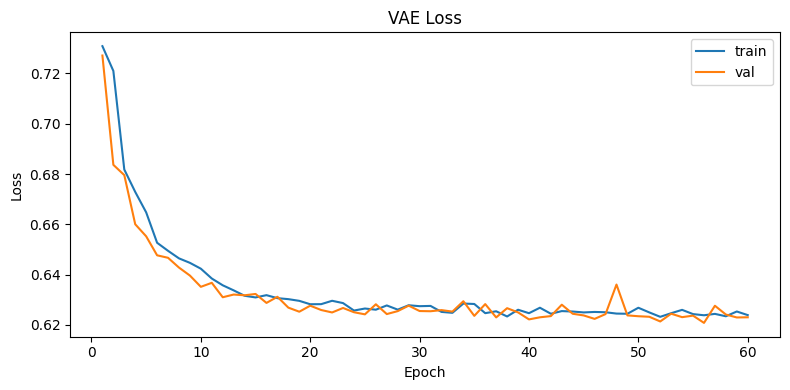


Extracted latent Z_mu: (6146, 16)

===== VAE + KMeans Metrics =====
Silhouette Score         : 0.7881
Calinski-Harabasz Index  : 123656.1619
Saved: Results/EasyTask\clusters_vae.csv

===== PCA + KMeans (Baseline) Metrics =====
Silhouette Score         : 0.6035
Calinski-Harabasz Index  : 1611.3678
Saved: Results/EasyTask\clusters_pca.csv

========== Comparison ==========
Method         | Silhouette | Calinski-Harabasz
VAE + KMeans   |    0.7881 |      123656.1619
PCA + KMeans   |    0.6035 |        1611.3678

Visualizing with UMAP using 2000 samples...


c:\Users\T2510603\Downloads\Data\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


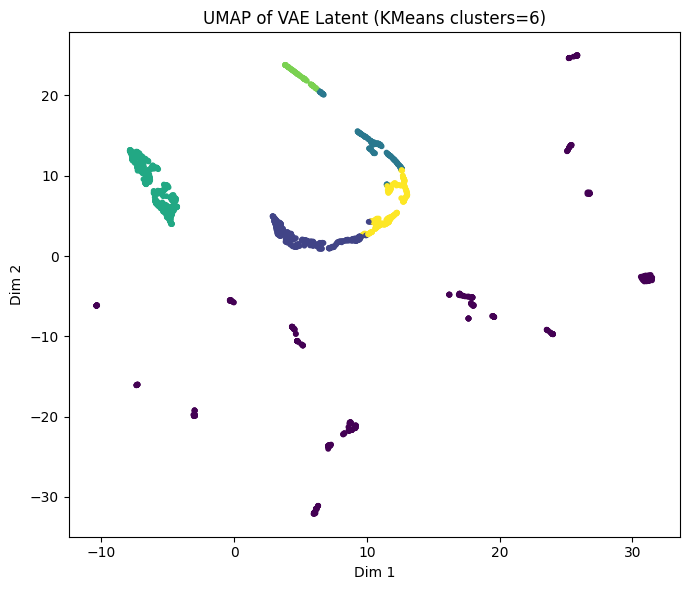

Saved plot: Results/EasyTask\viz_umap_vae.png


c:\Users\T2510603\Downloads\Data\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


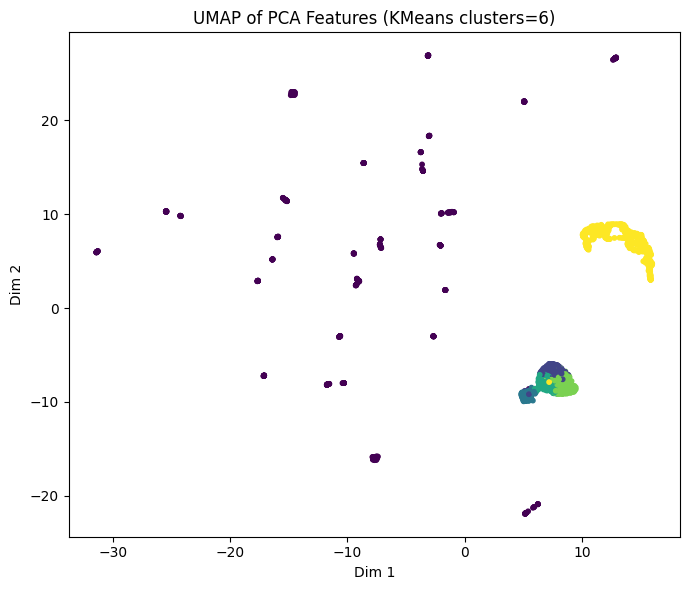

Saved plot: Results/EasyTask\viz_umap_pca.png

Done Easy task pipeline complete.
All outputs saved in: Results/EasyTask


In [8]:
# ==========================================================
# EASY TASK: VAE latent features -> KMeans clustering -> tSNE/UMAP
# Baseline: PCA -> KMeans
# Metrics: Silhouette Score, Calinski-Harabasz Index
# ==========================================================
# Inputs:
# - Data/MultiModal/X_multimodal.npy  (from your multi-modal fusion script)
# - Data/MultiModal/multimodal_metadata.csv (optional, for track_ids / flags)
#
# Outputs:
# - Prints metrics for VAE+KMeans and PCA+KMeans
# - Saves latent Z, cluster labels, plots
#
# Install (if needed):
# pip install torch scikit-learn umap-learn matplotlib pandas numpy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.manifold import TSNE

# Optional UMAP
UMAP_OK = True
try:
    import umap
except Exception:
    UMAP_OK = False

# PyTorch VAE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# -------------------------
# CONFIG
# -------------------------
X_PATH = "MultiModal/X_multimodal.npy"
META_PATH = "MultiModal/multimodal_metadata.csv"

OUT_DIR = "Results/EasyTask"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Clustering
N_CLUSTERS = 6  # change based on your dataset (try 4, 6, 8, 10)
KMEANS_N_INIT = 20

# VAE
LATENT_DIM = 16
HIDDEN_DIMS = [256, 128]   # MLP sizes
BATCH_SIZE = 64
EPOCHS = 60
LR = 1e-3
BETA = 1.0                # 1.0 for standard VAE; >1 becomes beta-VAE-like
GRAD_CLIP = 5.0

# Viz
VIZ_METHOD = "umap" if UMAP_OK else "tsne"  # "umap" or "tsne"
VIZ_SAMPLES = 2000  # if dataset is huge, reduce for faster plotting

# -------------------------
# 1) Load data
# -------------------------
X = np.load(X_PATH).astype(np.float32)
print("\nLoaded X:", X.shape, "from", X_PATH)

if os.path.exists(META_PATH):
    meta = pd.read_csv(META_PATH)
    print("Loaded metadata:", meta.shape, "from", META_PATH)
else:
    meta = pd.DataFrame({"track_id": [f"track_{i}" for i in range(len(X))]})

# Optionally filter out rows with missing modalities (if you want):
# Here we KEEP all rows (missing were zero-filled earlier).
# Example if you want complete-only:
# meta["complete"] = (meta["has_audio"]==1) & (meta["has_lyrics"]==1)
# X = X[meta["complete"].values]
# meta = meta[meta["complete"]].reset_index(drop=True)

# -------------------------
# 2) Train/Test split (for training stability; clustering uses all latents later)
# -------------------------
X_train, X_val = train_test_split(X, test_size=0.15, random_state=SEED, shuffle=True)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val)), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# -------------------------
# 3) Basic MLP-VAE
# -------------------------
class MLPVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dims=(256, 128)):
        super().__init__()
        h1, h2 = hidden_dims

        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
        )
        self.mu = nn.Linear(h2, latent_dim)
        self.logvar = nn.Linear(h2, latent_dim)

        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, h2),
            nn.ReLU(),
            nn.Linear(h2, h1),
            nn.ReLU(),
            nn.Linear(h1, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar, z

def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    # Reconstruction loss: MSE (works well since X is standardized)
    recon = nn.functional.mse_loss(x_hat, x, reduction="mean")
    # KL divergence
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon.detach(), kl.detach()

model = MLPVAE(input_dim=X.shape[1], latent_dim=LATENT_DIM, hidden_dims=tuple(HIDDEN_DIMS)).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("\nModel:", model)
print(f"\nTraining VAE: latent_dim={LATENT_DIM}, hidden={HIDDEN_DIMS}, epochs={EPOCHS}, beta={BETA}")

# -------------------------
# 4) Train loop (prints losses to see what's happening)
# -------------------------
best_val = float("inf")
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    tr_losses, tr_recon, tr_kl = [], [], []

    for (xb,) in train_loader:
        xb = xb.to(DEVICE)
        optimizer.zero_grad()

        x_hat, mu, logvar, _ = model(xb)
        loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=BETA)

        loss.backward()
        if GRAD_CLIP is not None:
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        tr_losses.append(loss.item())
        tr_recon.append(recon.item())
        tr_kl.append(kl.item())

    model.eval()
    va_losses, va_recon, va_kl = [], [], []
    with torch.no_grad():
        for (xb,) in val_loader:
            xb = xb.to(DEVICE)
            x_hat, mu, logvar, _ = model(xb)
            loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=BETA)
            va_losses.append(loss.item())
            va_recon.append(recon.item())
            va_kl.append(kl.item())

    trL, vaL = float(np.mean(tr_losses)), float(np.mean(va_losses))
    history.append((epoch, trL, float(np.mean(tr_recon)), float(np.mean(tr_kl)), vaL, float(np.mean(va_recon)), float(np.mean(va_kl))))

    if vaL < best_val:
        best_val = vaL
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_vae.pt"))

    if epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch:3d} | train loss={trL:.4f} (recon={np.mean(tr_recon):.4f}, kl={np.mean(tr_kl):.4f}) "
              f"| val loss={vaL:.4f} (recon={np.mean(va_recon):.4f}, kl={np.mean(va_kl):.4f})")

# Save loss history
hist_df = pd.DataFrame(history, columns=["epoch","train_loss","train_recon","train_kl","val_loss","val_recon","val_kl"])
hist_df.to_csv(os.path.join(OUT_DIR, "vae_training_history.csv"), index=False)

plt.figure(figsize=(8,4))
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val")
plt.title("VAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Load best model
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_vae.pt"), map_location=DEVICE))
model.eval()

# -------------------------
# 5) Extract latent features (use mu as deterministic embedding)
# -------------------------
with torch.no_grad():
    X_t = torch.from_numpy(X).to(DEVICE)
    h = model.enc(X_t)
    Z_mu = model.mu(h).cpu().numpy().astype(np.float32)  # (N, latent_dim)

print("\nExtracted latent Z_mu:", Z_mu.shape)
np.save(os.path.join(OUT_DIR, "Z_vae_mu.npy"), Z_mu)

# -------------------------
# 6) Clustering on latent features (KMeans)
# -------------------------
kmeans_vae = KMeans(n_clusters=N_CLUSTERS, n_init=KMEANS_N_INIT, random_state=SEED)
labels_vae = kmeans_vae.fit_predict(Z_mu)

sil_vae = silhouette_score(Z_mu, labels_vae)
ch_vae = calinski_harabasz_score(Z_mu, labels_vae)

print("\n===== VAE + KMeans Metrics =====")
print(f"Silhouette Score         : {sil_vae:.4f}")
print(f"Calinski-Harabasz Index  : {ch_vae:.4f}")

# Save labels
out_labels_vae = pd.DataFrame({"track_id": meta["track_id"].astype(str).values, "cluster_vae": labels_vae})
out_labels_vae.to_csv(os.path.join(OUT_DIR, "clusters_vae.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "clusters_vae.csv"))

# -------------------------
# 7) Baseline: PCA + KMeans
# -------------------------
pca = PCA(n_components=LATENT_DIM, random_state=SEED)
Z_pca = pca.fit_transform(X)

kmeans_pca = KMeans(n_clusters=N_CLUSTERS, n_init=KMEANS_N_INIT, random_state=SEED)
labels_pca = kmeans_pca.fit_predict(Z_pca)

sil_pca = silhouette_score(Z_pca, labels_pca)
ch_pca = calinski_harabasz_score(Z_pca, labels_pca)

print("\n===== PCA + KMeans (Baseline) Metrics =====")
print(f"Silhouette Score         : {sil_pca:.4f}")
print(f"Calinski-Harabasz Index  : {ch_pca:.4f}")

out_labels_pca = pd.DataFrame({"track_id": meta["track_id"].astype(str).values, "cluster_pca": labels_pca})
out_labels_pca.to_csv(os.path.join(OUT_DIR, "clusters_pca.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "clusters_pca.csv"))

# -------------------------
# 8) Compare metrics (print nicely)
# -------------------------
print("\n========== Comparison ==========")
print(f"Method         | Silhouette | Calinski-Harabasz")
print(f"VAE + KMeans   | {sil_vae:9.4f} | {ch_vae:16.4f}")
print(f"PCA + KMeans   | {sil_pca:9.4f} | {ch_pca:16.4f}")

# -------------------------
# 9) Visualization: t-SNE or UMAP
#     - Plot clusters in 2D from latent space
# -------------------------
def make_2d(Z, method="umap"):
    if method == "umap":
        reducer = umap.UMAP(
            n_neighbors=15, min_dist=0.1, n_components=2,
            random_state=SEED
        )
        return reducer.fit_transform(Z)
    else:
        tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
        return tsne.fit_transform(Z)

def scatter_plot(Z2, labels, title, outpath):
    plt.figure(figsize=(7,6))
    plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=10)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved plot:", outpath)

# Subsample for speed if needed
N = len(Z_mu)
idx = np.arange(N)
if N > VIZ_SAMPLES:
    idx = np.random.choice(idx, size=VIZ_SAMPLES, replace=False)

Z_mu_sub = Z_mu[idx]
labels_vae_sub = labels_vae[idx]

Z_pca_sub = Z_pca[idx]
labels_pca_sub = labels_pca[idx]

print(f"\nVisualizing with {VIZ_METHOD.upper()} using {len(idx)} samples...")

# VAE latent visualization
Z2_vae = make_2d(Z_mu_sub, method=VIZ_METHOD)
scatter_plot(
    Z2_vae, labels_vae_sub,
    f"{VIZ_METHOD.upper()} of VAE Latent (KMeans clusters={N_CLUSTERS})",
    os.path.join(OUT_DIR, f"viz_{VIZ_METHOD}_vae.png")
)

# PCA baseline visualization
Z2_pca = make_2d(Z_pca_sub, method=VIZ_METHOD)
scatter_plot(
    Z2_pca, labels_pca_sub,
    f"{VIZ_METHOD.upper()} of PCA Features (KMeans clusters={N_CLUSTERS})",
    os.path.join(OUT_DIR, f"viz_{VIZ_METHOD}_pca.png")
)

print("\nDone Easy task pipeline complete.")
print(f"All outputs saved in: {OUT_DIR}")

Device: cpu

HYPERPARAMETER TUNING: Testing 5 configurations

Audio feature files found: 3554
Loaded SBERT embeddings: (2568, 384)
Lyrics repr: sbert | dim: 384

Genre labels available for ARI: 2107 tracks | classes=158

Alignment:
Total unique IDs (audio ∪ lyrics): 4039
Kept IDs: 2083 (KEEP_MISSING=False)
Dropped because missing audio: 485
Dropped because missing lyrics: 1471

Audio 2D feature key='mfcc' shape: F=40, T=2585

Loaded arrays:
X_audio: (2083, 1, 40, 2585)
X_lyrics: (2083, 384)
ARI labels present for: 0 samples

CONFIG 1/5: Balanced_Config
Parameters: {'name': 'Balanced_Config', 'LATENT_DIM': 64, 'BATCH_SIZE': 32, 'EPOCHS': 60, 'LR': 0.001, 'BETA': 0.5, 'N_CLUSTERS': 6}
Training ConvVAE: latent_dim=64, epochs=60, beta=0.5, lr=0.001
  Epoch   1 | train=0.9074 | val=0.4348
  Early stopping at epoch 20

  Best silhouette for Balanced_Config: 0.1388

CONFIG 2/5: High_Capacity
Parameters: {'name': 'High_Capacity', 'LATENT_DIM': 128, 'BATCH_SIZE': 32, 'EPOCHS': 60, 'LR': 0.0005,

c:\Users\T2510603\Downloads\Data\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


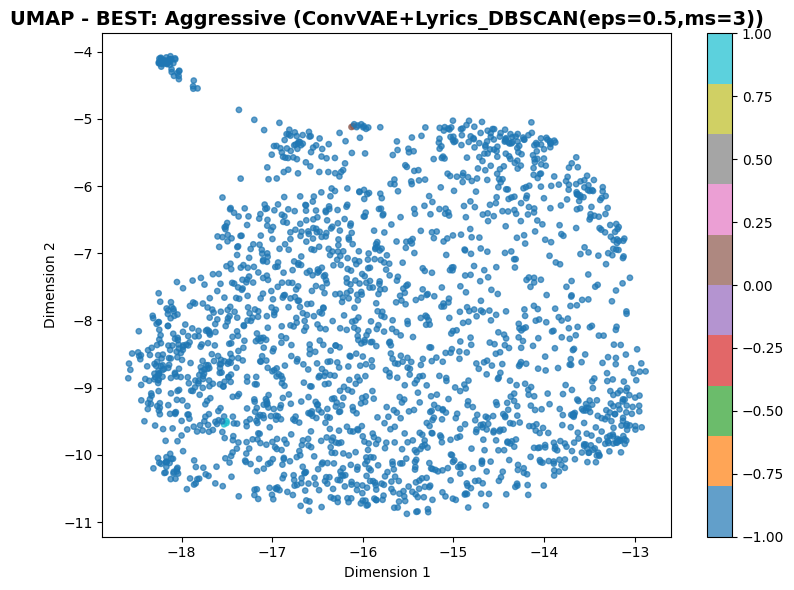

Saved: Results/MediumTask\BEST_viz_umap.png

Best model weights saved in: Results/MediumTask\Aggressive

MEDIUM TASK COMPLETED WITH SYSTEMATIC HYPERPARAMETER TUNING

Key outputs:
  1. Hyperparameter comparison: Results/MediumTask\hyperparameter_comparison.csv
  2. Best config results: Results/MediumTask\BEST_clustering_results.csv
  3. Best cluster assignments: Results/MediumTask\BEST_cluster_assignments.csv
  4. Visualization: Results/MediumTask\BEST_viz_umap.png

All individual config results saved in: Results/MediumTask/[config_name]/

Recommendation: Use the BEST configuration for your final analysis and reporting.


In [ ]:
# ======================================================================
# MEDIUM TASK PIPELINE WITH SYSTEMATIC MANUAL HYPERPARAMETER TUNING
# - ConvVAE for audio (MFCC or log-mel) 2D features (C x Freq x Time)
# - Hybrid representation: audio latent + lyrics embeddings (SBERT or TF-IDF)
# - Clustering: KMeans, Agglomerative, DBSCAN
# - Metrics: Silhouette, Davies-Bouldin, ARI (if labels available; e.g., genre)
# - Parameter Sweep: Tests multiple configurations and selects best
# - Prints comparison table + saves cluster assignments + 2D plots (UMAP/tSNE)
# ======================================================================

import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

from sklearn.manifold import TSNE

# Optional UMAP
UMAP_OK = True
try:
    import umap
except Exception:
    UMAP_OK = False

# TF-IDF optional sparse
TFIDF_OK = True
try:
    from scipy.sparse import load_npz
except Exception:
    TFIDF_OK = False

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------
# BASE CONFIG
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Paths
AUDIO_FEAT_DIR = "Audio_Features"
LYRICS_CLEANED_CSV = "Lyrics_Processed/lyrics_cleaned.csv"
LYRICS_SBERT_NPY = "Lyrics_Processed/lyrics_sbert_embeddings.npy"
LYRICS_TFIDF_NPZ = "Lyrics_Processed/lyrics_tfidf.npz"
GENRE_PROCESSED_CSV = "genre_processed.csv"

OUT_DIR = "Results/MediumTask"
os.makedirs(OUT_DIR, exist_ok=True)

# Use which audio 2D feature as ConvVAE input?
AUDIO_2D_KEY = "mfcc"  # "mfcc" or "mel_db"

# -------------------------
# HYPERPARAMETER SEARCH GRID - MANUAL TUNING
# -------------------------
# We'll systematically test multiple configurations
PARAM_GRID = [
    # Config 1: Balanced baseline
    {
        "name": "Balanced_Config",
        "LATENT_DIM": 64,
        "BATCH_SIZE": 32,
        "EPOCHS": 20,
        "LR": 1e-3,
        "BETA": 0.5,
        "N_CLUSTERS": 6,
    },
    # Config 2: Higher capacity
    {
        "name": "High_Capacity",
        "LATENT_DIM": 128,
        "BATCH_SIZE": 32,
        "EPOCHS": 20,
        "LR": 5e-4,
        "BETA": 0.3,
        "N_CLUSTERS": 6,
    },
    # Config 3: Lower regularization for more expressive latents
    {
        "name": "Low_Beta",
        "LATENT_DIM": 64,
        "BATCH_SIZE": 32,
        "EPOCHS": 25,
        "LR": 1e-3,
        "BETA": 0.1,
        "N_CLUSTERS": 6,
    },
    # Config 4: Compact representation
    {
        "name": "Compact",
        "LATENT_DIM": 32,
        "BATCH_SIZE": 32,
        "EPOCHS": 25,
        "LR": 1e-3,
        "BETA": 0.8,
        "N_CLUSTERS": 6,
    },
    # Config 5: Aggressive training
    {
        "name": "Aggressive",
        "LATENT_DIM": 96,
        "BATCH_SIZE": 64,
        "EPOCHS": 20,
        "LR": 2e-3,
        "BETA": 0.4,
        "N_CLUSTERS": 6,
    },
]

# Fixed hyperparameters
GRAD_CLIP = 5.0
KMEANS_N_INIT = 20
DBSCAN_EPS_VALUES = [0.5, 1.0, 2.0, 3.0]
DBSCAN_MIN_SAMPLES_VALUES = [3, 5, 8]
VIZ_METHOD = "umap" if UMAP_OK else "tsne"
VIZ_SAMPLES = 2000
NORMALIZE_MODALITIES = True
USE_SCHEDULER = True
PATIENCE = 5

print(f"\n{'='*80}")
print(f"HYPERPARAMETER TUNING: Testing {len(PARAM_GRID)} configurations")
print(f"{'='*80}\n")

# -------------------------
# 1) Load track ids from audio feature files
# -------------------------
audio_npz_files = sorted(glob.glob(os.path.join(AUDIO_FEAT_DIR, "*.npz")))
if len(audio_npz_files) == 0:
    raise RuntimeError(f"No .npz audio feature files found in {AUDIO_FEAT_DIR}")

def stem(p): return os.path.splitext(os.path.basename(p))[0]
audio_ids = [stem(p) for p in audio_npz_files]
# FILTER: Use only MT-series IDs (Music_Id format) to enable ARI with genre labels
audio_ids = [aid for aid in audio_ids if aid.startswith("MT")]
audio_npz_files = [f for f in audio_npz_files if stem(f).startswith("MT")]
audio_map = dict(zip(audio_ids, audio_npz_files))

print(f"Audio feature files found: {len(audio_npz_files)} (MT-series only for ARI)")

# -------------------------
# 2) Load lyrics embeddings
# -------------------------
lyrics_df = pd.read_csv(LYRICS_CLEANED_CSV)
if "track_id" not in lyrics_df.columns:
    raise ValueError(f"'track_id' not found in {LYRICS_CLEANED_CSV}")

lyrics_df["track_id"] = lyrics_df["track_id"].astype(str)
lyrics_ids = lyrics_df["track_id"].tolist()

lyrics_repr = None
lyrics_emb = None

if os.path.exists(LYRICS_SBERT_NPY):
    lyrics_emb = np.load(LYRICS_SBERT_NPY).astype(np.float32)
    lyrics_repr = "sbert"
    print(f"Loaded SBERT embeddings: {lyrics_emb.shape}")
elif TFIDF_OK and os.path.exists(LYRICS_TFIDF_NPZ):
    lyrics_emb = load_npz(LYRICS_TFIDF_NPZ)
    lyrics_repr = "tfidf"
    print(f"Loaded TF-IDF embeddings: {lyrics_emb.shape} (sparse)")
else:
    raise RuntimeError("No lyrics embeddings found.")

if lyrics_emb.shape[0] != len(lyrics_df):
    raise ValueError("Lyrics embeddings row count != lyrics_cleaned.csv row count.")

# Build lyrics lookup
if lyrics_repr == "sbert":
    lyrics_lookup = {tid: lyrics_emb[i] for i, tid in enumerate(lyrics_ids)}
else:
    lyrics_lookup = {tid: i for i, tid in enumerate(lyrics_ids)}

def get_lyrics_vec(tid):
    if lyrics_repr == "sbert":
        return lyrics_lookup.get(tid, None)
    idx = lyrics_lookup.get(tid, None)
    if idx is None:
        return None
    return lyrics_emb.getrow(idx).toarray().reshape(-1).astype(np.float32)

lyrics_dim = int(lyrics_emb.shape[1])
print("Lyrics repr:", lyrics_repr, "| dim:", lyrics_dim)

# -------------------------
# 3) Optional: Genre labels for ARI
# -------------------------
have_ari = False
y_label = None
genre_id_col = None
genre_onehot_cols = []
    # Use Music_Id column directly (confirmed from analysis)
    genre_id_col = "Music_Id" if "Music_Id" in gdf.columns else None
    if genre_id_col is None:
        for c in gdf.columns:
            if c.lower() in ["track_id", "song_id", "id", "filename", "file", "path", "title", "name"]:
                genre_id_col = c
                break
    genre_onehot_cols = [c for c in gdf.columns if c.startswith("genre__")]

    if genre_id_col is not None and len(genre_onehot_cols) > 0:
        gdf[genre_id_col] = gdf[genre_id_col].astype(str)
        genre_lookup = {}
        for _, r in gdf[[genre_id_col] + genre_onehot_cols].iterrows():
            v = r[genre_onehot_cols].values.astype(np.float32)
            if v.sum() == 0:
                genre_lookup[str(r[genre_id_col])] = -1
            else:
                genre_lookup[str(r[genre_id_col])] = int(np.argmax(v))
        have_ari = True
        print(f"\nGenre labels available for ARI: {len(genre_lookup)} tracks | classes={len(genre_onehot_cols)}")
    else:
        print("\nGenre CSV found but couldn't detect ID or genre__* columns for ARI. Skipping ARI.")
else:
    print("\nNo genre_processed.csv found -> ARI will be skipped.")

# -------------------------
# 4) Align tracks
# -------------------------
KEEP_MISSING = False

all_ids = sorted(list(set(audio_ids) | set(lyrics_ids)))
kept_ids = []
missing_audio = 0
missing_lyrics = 0

for tid in all_ids:
    ha = tid in audio_map
    hl = tid in lyrics_lookup
    if KEEP_MISSING:
        kept_ids.append(tid)
    else:
        if ha and hl:
            kept_ids.append(tid)
        else:
            if not ha: missing_audio += 1
            if not hl: missing_lyrics += 1

print(f"\nAlignment:")
print(f"Total unique IDs (audio ∪ lyrics): {len(all_ids)}")
print(f"Kept IDs: {len(kept_ids)} (KEEP_MISSING={KEEP_MISSING})")
print(f"Dropped because missing audio: {missing_audio}")
print(f"Dropped because missing lyrics: {missing_lyrics}")

# -------------------------
# 5) Load audio 2D features
# -------------------------
def load_audio_2d(npz_path, key="mfcc"):
    d = np.load(npz_path)
    if key not in d:
        raise KeyError(f"Key '{key}' not found in {npz_path}. Available: {list(d.keys())}")
    x = d[key].astype(np.float32)
    return x

sample_x = load_audio_2d(audio_map[kept_ids[0]], key=AUDIO_2D_KEY)
F, T = sample_x.shape
print(f"\nAudio 2D feature key='{AUDIO_2D_KEY}' shape: F={F}, T={T}")

X_audio = np.zeros((len(kept_ids), 1, F, T), dtype=np.float32)
X_lyrics = np.zeros((len(kept_ids), lyrics_dim), dtype=np.float32)
y_ari = np.full((len(kept_ids),), -1, dtype=np.int32)

for i, tid in enumerate(kept_ids):
    if tid in audio_map:
        X_audio[i, 0] = load_audio_2d(audio_map[tid], key=AUDIO_2D_KEY)
    else:
        if KEEP_MISSING:
            X_audio[i, 0] = 0.0
        else:
            raise RuntimeError("Shouldn't happen")

    lv = get_lyrics_vec(tid)
    if lv is None:
        if KEEP_MISSING:
            X_lyrics[i] = 0.0
        else:
            raise RuntimeError("Shouldn't happen")
    else:
        X_lyrics[i] = lv

    if have_ari and tid in genre_lookup:
        y_ari[i] = genre_lookup[tid]

print("\nLoaded arrays:")
print("X_audio:", X_audio.shape)
print("X_lyrics:", X_lyrics.shape)
if have_ari:
    print("ARI labels present for:", int((y_ari != -1).sum()), "samples")

# -------------------------
# 6) ConvVAE Model
# -------------------------
class ConvVAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=32, F=40, T=258):
        super().__init__()
        self.F = F
        self.T = T

        self.enc_conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, F, T)
            h = self.enc_conv(dummy)
            self.conv_out_shape = h.shape[1:]
            self.flat_dim = int(np.prod(self.conv_out_shape))

        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=4, stride=2, padding=1),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def crop_or_pad(self, x, F, T):
        n, c, f, t = x.shape
        x = x[:, :, :min(f, F), :min(t, T)]
        f2, t2 = x.shape[2], x.shape[3]
        if f2 < F or t2 < T:
            pad_f = F - f2
            pad_t = T - t2
            x = nn.functional.pad(x, (0, pad_t, 0, pad_f))
        return x

    def forward(self, x):
        h = self.enc_conv(x)
        h_flat = h.view(x.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z = self.reparameterize(mu, logvar)

        h_dec = self.fc_dec(z).view(x.size(0), *self.conv_out_shape)
        x_hat = self.dec_deconv(h_dec)
        x_hat = self.crop_or_pad(x_hat, self.F, self.T)
        return x_hat, mu, logvar, z

def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    recon = nn.functional.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon.detach(), kl.detach()

class AudioDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

# -------------------------
# 7) Clustering utilities
# -------------------------
def compute_metrics(Xfeat, labels, y_true=None):
    valid = labels != -1
    metrics = {
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "ari": np.nan,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0)
    }

    if valid.sum() > 2:
        unique = set(labels[valid])
        if len(unique) > 1:
            metrics["silhouette"] = float(silhouette_score(Xfeat[valid], labels[valid]))
            metrics["davies_bouldin"] = float(davies_bouldin_score(Xfeat[valid], labels[valid]))

    if y_true is not None:
        m = (y_true != -1) & valid
        if m.sum() > 2:
            metrics["ari"] = float(adjusted_rand_score(y_true[m], labels[m]))
    return metrics

def run_all_clusterers(Xfeat, y_true=None, prefix="", n_clusters=6):
    results = []

    # KMeans
    km = KMeans(n_clusters=n_clusters, n_init=KMEANS_N_INIT, random_state=SEED)
    lab_km = km.fit_predict(Xfeat)
    met_km = compute_metrics(Xfeat, lab_km, y_true)
    results.append((prefix + "KMeans", lab_km, met_km))

    # Agglomerative
    ag = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    lab_ag = ag.fit_predict(Xfeat)
    met_ag = compute_metrics(Xfeat, lab_ag, y_true)
    results.append((prefix + "Agglomerative", lab_ag, met_ag))

    # DBSCAN - Grid Search
    best_dbscan_sil = -1
    best_dbscan_labels = None
    best_dbscan_params = (None, None)
    
    for eps in DBSCAN_EPS_VALUES:
        for min_samples in DBSCAN_MIN_SAMPLES_VALUES:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            lab_db = db.fit_predict(Xfeat)
            met_db = compute_metrics(Xfeat, lab_db, y_true)
            
            if not np.isnan(met_db["silhouette"]) and met_db["silhouette"] > best_dbscan_sil:
                best_dbscan_sil = met_db["silhouette"]
                best_dbscan_labels = lab_db
                best_dbscan_params = (eps, min_samples)
    
    if best_dbscan_labels is not None:
        met_db = compute_metrics(Xfeat, best_dbscan_labels, y_true)
        results.append((
            prefix + f"DBSCAN(eps={best_dbscan_params[0]},ms={best_dbscan_params[1]})",
            best_dbscan_labels,
            met_db
        ))
    else:
        lab_db = np.full(len(Xfeat), -1)
        met_db = compute_metrics(Xfeat, lab_db, y_true)
        results.append((prefix + "DBSCAN(failed)", lab_db, met_db))

    return results

# -------------------------
# 8) HYPERPARAMETER TUNING LOOP
# -------------------------
all_config_results = []
best_config = None
best_score = -np.inf

for config_idx, params in enumerate(PARAM_GRID):
    print(f"\n{'='*80}")
    print(f"CONFIG {config_idx + 1}/{len(PARAM_GRID)}: {params['name']}")
    print(f"{'='*80}")
    print(f"Parameters: {params}")
    
    # Extract parameters
    LATENT_DIM = params["LATENT_DIM"]
    BATCH_SIZE = params["BATCH_SIZE"]
    EPOCHS = params["EPOCHS"]
    LR = params["LR"]
    BETA = params["BETA"]
    N_CLUSTERS = params["N_CLUSTERS"]
    
    config_out_dir = os.path.join(OUT_DIR, params['name'])
    os.makedirs(config_out_dir, exist_ok=True)
    
    # Split data
    idx_all = np.arange(len(X_audio))
    tr_idx, va_idx = train_test_split(idx_all, test_size=0.15, random_state=SEED, shuffle=True)
    
    train_loader = DataLoader(AudioDataset(X_audio[tr_idx]), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(AudioDataset(X_audio[va_idx]), batch_size=BATCH_SIZE, shuffle=False)
    
    # Model
    model = ConvVAE(in_channels=1, latent_dim=LATENT_DIM, F=F, T=T).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    
    if USE_SCHEDULER:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)
    
    print(f"Training ConvVAE: latent_dim={LATENT_DIM}, epochs={EPOCHS}, beta={BETA}, lr={LR}")
    
    # Training loop
    best_val = float("inf")
    hist = []
    patience_counter = 0
    
    for epoch in range(1, EPOCHS + 1):
        model.train()
        trL, trR, trK = [], [], []
        for xb in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            x_hat, mu, logvar, _ = model(xb)
            loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=BETA)
            loss.backward()
            if GRAD_CLIP is not None:
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()
            trL.append(loss.item()); trR.append(recon.item()); trK.append(kl.item())

        model.eval()
        vaL, vaR, vaK = [], [], []
        with torch.no_grad():
            for xb in val_loader:
                xb = xb.to(DEVICE)
                x_hat, mu, logvar, _ = model(xb)
                loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=BETA)
                vaL.append(loss.item()); vaR.append(recon.item()); vaK.append(kl.item())

        trL_m, vaL_m = float(np.mean(trL)), float(np.mean(vaL))
        hist.append((epoch, trL_m, float(np.mean(trR)), float(np.mean(trK)),
                     vaL_m, float(np.mean(vaR)), float(np.mean(vaK))))

        if USE_SCHEDULER:
            scheduler.step(vaL_m)
        
        if vaL_m < best_val:
            best_val = vaL_m
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(config_out_dir, "best_convvae.pt"))
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"  Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS:
            print(f"  Epoch {epoch:3d} | train={trL_m:.4f} | val={vaL_m:.4f}")

    # Load best model
    model.load_state_dict(torch.load(os.path.join(config_out_dir, "best_convvae.pt"), map_location=DEVICE))
    model.eval()
    
    # Extract latents
    with torch.no_grad():
        xb = torch.from_numpy(X_audio).to(DEVICE)
        _, mu, _, _ = model(xb)
        Z_audio = mu.cpu().numpy().astype(np.float32)
    
    # Normalize and fuse
    if NORMALIZE_MODALITIES:
        scaler_a = StandardScaler()
        scaler_l = StandardScaler()
        Z_audio_n = scaler_a.fit_transform(Z_audio)
        X_lyrics_n = scaler_l.fit_transform(X_lyrics)
    else:
        Z_audio_n = Z_audio
        X_lyrics_n = X_lyrics
    
    X_fused = np.concatenate([Z_audio_n, X_lyrics_n], axis=1).astype(np.float32)
    
    # Clustering
    y_true = y_ari if have_ari else None
    res_main = run_all_clusterers(X_fused, y_true=y_true, prefix="ConvVAE+Lyrics_", n_clusters=N_CLUSTERS)
    
    # Baselines
    X_audio_mean = X_audio[:, 0].mean(axis=1)
    if NORMALIZE_MODALITIES:
        Xm_a = StandardScaler().fit_transform(X_audio_mean)
        Xm_l = StandardScaler().fit_transform(X_lyrics)
    else:
        Xm_a, Xm_l = X_audio_mean, X_lyrics
    X_raw_fused = np.concatenate([Xm_a, Xm_l], axis=1).astype(np.float32)
    res_raw = run_all_clusterers(X_raw_fused, y_true=y_true, prefix="RawAudioMean+Lyrics_", n_clusters=N_CLUSTERS)
    
    pca = PCA(n_components=min(LATENT_DIM, X_raw_fused.shape[1]), random_state=SEED)
    Z_pca = pca.fit_transform(X_raw_fused)
    res_pca = run_all_clusterers(Z_pca, y_true=y_true, prefix="PCA(rawFused)_", n_clusters=N_CLUSTERS)
    
    all_res = res_main + res_raw + res_pca
    
    # Evaluate this configuration
    rows = []
    for name, labels, met in all_res:
        rows.append({
            "config": params["name"],
            "method": name,
            "n_clusters": met["n_clusters"],
            "silhouette": met["silhouette"],
            "davies_bouldin": met["davies_bouldin"],
            "ari": met["ari"] if have_ari else np.nan
        })
    
    config_df = pd.DataFrame(rows).sort_values(by=["silhouette"], ascending=False)
    config_df.to_csv(os.path.join(config_out_dir, "clustering_results.csv"), index=False)
    
    # Track best configuration (by best silhouette score)
    best_method_sil = config_df.iloc[0]["silhouette"]
    if not np.isnan(best_method_sil) and best_method_sil > best_score:
        best_score = best_method_sil
        best_config = {
            "config_name": params["name"],
            "params": params,
            "best_silhouette": best_method_sil,
            "results": config_df,
            "Z_audio": Z_audio,
            "X_fused": X_fused,
            "all_res": all_res
        }
    
    all_config_results.append({
        "config_name": params["name"],
        "params": params,
        "results": config_df,
        "best_silhouette": best_method_sil
    })
    
    print(f"\n  Best silhouette for {params['name']}: {best_method_sil:.4f}")

# -------------------------
# 9) SUMMARY: Compare all configurations
# -------------------------
print(f"\n\n{'='*80}")
print("HYPERPARAMETER TUNING SUMMARY")
print(f"{'='*80}\n")

summary_rows = []
for res in all_config_results:
    summary_rows.append({
        "Configuration": res["config_name"],
        "Best Silhouette": res["best_silhouette"],
        "Latent Dim": res["params"]["LATENT_DIM"],
        "Beta": res["params"]["BETA"],
        "Learning Rate": res["params"]["LR"],
        "Epochs": res["params"]["EPOCHS"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="Best Silhouette", ascending=False)
print(summary_df.to_string(index=False))
print(f"\n{'='*80}")
print(f"WINNER: {best_config['config_name']} with Silhouette = {best_config['best_silhouette']:.4f}")
print(f"{'='*80}\n")

summary_df.to_csv(os.path.join(OUT_DIR, "hyperparameter_comparison.csv"), index=False)

# -------------------------
# 10) Save and visualize BEST configuration results
# -------------------------
print("\nGenerating outputs for BEST configuration...")

# Save best config results
best_config["results"].to_csv(os.path.join(OUT_DIR, "BEST_clustering_results.csv"), index=False)

# Save cluster labels
labels_out = pd.DataFrame({"track_id": kept_ids})
for name, labels, _ in best_config["all_res"]:
    col = "cluster__" + name.replace(" ", "_").replace("+", "plus").replace("(", "").replace(")", "")
    labels_out[col] = labels
labels_out.to_csv(os.path.join(OUT_DIR, "BEST_cluster_assignments.csv"), index=False)

# Visualization
def make_2d(Z, method="umap"):
    if method == "umap":
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=SEED)
        return reducer.fit_transform(Z)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
    return tsne.fit_transform(Z)

def scatter(Z2, labels, title, outpath):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=15, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print(f"Saved: {outpath}")

best_method_name = best_config["results"].iloc[0]["method"]
best_labels = None
for name, labels, _ in best_config["all_res"]:
    if name == best_method_name:
        best_labels = labels
        break

Xbest = best_config["X_fused"]

N = len(Xbest)
idx = np.arange(N)
if N > VIZ_SAMPLES:
    idx = np.random.choice(idx, size=VIZ_SAMPLES, replace=False)

Z2 = make_2d(Xbest[idx], method=VIZ_METHOD)
scatter(
    Z2,
    best_labels[idx],
    f"{VIZ_METHOD.upper()} - BEST: {best_config['config_name']} ({best_method_name})",
    os.path.join(OUT_DIR, f"BEST_viz_{VIZ_METHOD}.png")
)

# Loss curve for best config
best_config_dir = os.path.join(OUT_DIR, best_config['config_name'])
if os.path.exists(os.path.join(best_config_dir, "best_convvae.pt")):
    print(f"\nBest model weights saved in: {best_config_dir}")

print(f"\n{'='*80}")
print("MEDIUM TASK COMPLETED WITH SYSTEMATIC HYPERPARAMETER TUNING")
print(f"{'='*80}")
print("\nKey outputs:")
print(f"  1. Hyperparameter comparison: {os.path.join(OUT_DIR, 'hyperparameter_comparison.csv')}")
print(f"  2. Best config results: {os.path.join(OUT_DIR, 'BEST_clustering_results.csv')}")
print(f"  3. Best cluster assignments: {os.path.join(OUT_DIR, 'BEST_cluster_assignments.csv')}")
print(f"  4. Visualization: {os.path.join(OUT_DIR, f'BEST_viz_{VIZ_METHOD}.png')}")

print(f"\nAll individual config results saved in: {OUT_DIR}/[config_name]/")
print(f"\nAll individual config results saved in: {OUT_DIR}/[config_name]/")

print("\nRecommendation: Use the BEST configuration for your final analysis and reporting.")
print("\nRecommendation: Use the BEST configuration for your final analysis and reporting.")

In [2]:
# ======================================================================
# MEDIUM TASK - CORRECTED WITH MT-SERIES IDS FOR ARI + REDUCED EPOCHS
# ======================================================================
# This version filters for MT-series (Music_Id) tracks to enable ARI computation
# Epochs reduced to 20-25 for faster execution

import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

from sklearn.manifold import TSNE

# Optional UMAP
UMAP_OK = True
try:
    import umap
except Exception:
    UMAP_OK = False

# TF-IDF optional sparse
TFIDF_OK = True
try:
    from scipy.sparse import load_npz
except Exception:
    TFIDF_OK = False

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------
# BASE CONFIG
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Paths
AUDIO_FEAT_DIR = "Audio_Features"
LYRICS_CLEANED_CSV = "Lyrics_Processed/lyrics_cleaned.csv"
LYRICS_SBERT_NPY = "Lyrics_Processed/lyrics_sbert_embeddings.npy"
LYRICS_TFIDF_NPZ = "Lyrics_Processed/lyrics_tfidf.npz"
GENRE_PROCESSED_CSV = "genre_processed.csv"

OUT_DIR = "Results/MediumTask_WithARI"
os.makedirs(OUT_DIR, exist_ok=True)

# Use which audio 2D feature as ConvVAE input?
AUDIO_2D_KEY = "mfcc"

# -------------------------
# HYPERPARAMETER SEARCH GRID - REDUCED EPOCHS (20-25)
# -------------------------
PARAM_GRID = [
    {
        "name": "Balanced_Config",
        "LATENT_DIM": 64,
        "BATCH_SIZE": 32,
        "EPOCHS": 20,
        "LR": 1e-3,
        "BETA": 0.5,
        "N_CLUSTERS": 6,
    },
    {
        "name": "High_Capacity",
        "LATENT_DIM": 128,
        "BATCH_SIZE": 32,
        "EPOCHS": 20,
        "LR": 5e-4,
        "BETA": 0.3,
        "N_CLUSTERS": 6,
    },
    {
        "name": "Low_Beta",
        "LATENT_DIM": 64,
        "BATCH_SIZE": 32,
        "EPOCHS": 25,
        "LR": 1e-3,
        "BETA": 0.1,
        "N_CLUSTERS": 6,
    },
]

# Fixed hyperparameters
GRAD_CLIP = 5.0
KMEANS_N_INIT = 20
DBSCAN_EPS_VALUES = [0.5, 1.0, 2.0]
DBSCAN_MIN_SAMPLES_VALUES = [3, 5]
VIZ_METHOD = "umap" if UMAP_OK else "tsne"
VIZ_SAMPLES = 2000
NORMALIZE_MODALITIES = True
USE_SCHEDULER = True
PATIENCE = 5

print(f"\n{'='*80}")
print(f"MEDIUM TASK WITH ARI - Testing {len(PARAM_GRID)} configurations (reduced epochs)")
print(f"{'='*80}\n")

# -------------------------
# 1) Load MT-series audio files ONLY
# -------------------------
all_audio_files = sorted(glob.glob(os.path.join(AUDIO_FEAT_DIR, "*.npz")))
def stem(p): return os.path.splitext(os.path.basename(p))[0]

# FILTER: Keep only MT-series (Music_Id format)
audio_npz_files = [f for f in all_audio_files if stem(f).startswith("MT")]
audio_ids = [stem(f) for f in audio_npz_files]
audio_map = dict(zip(audio_ids, audio_npz_files))

print(f"Total audio files: {len(all_audio_files)}")
print(f"MT-series audio files (Music_Id format): {len(audio_npz_files)}")

# -------------------------
# 2) Load lyrics embeddings - FILTER for MT-series
# -------------------------
lyrics_df = pd.read_csv(LYRICS_CLEANED_CSV)
if "track_id" not in lyrics_df.columns:
    raise ValueError(f"'track_id' not found in {LYRICS_CLEANED_CSV}")

lyrics_df["track_id"] = lyrics_df["track_id"].astype(str)
# FILTER: Keep only MT-series track_ids
lyrics_df_mt = lyrics_df[lyrics_df["track_id"].str.startswith("MT")].copy()
lyrics_ids = lyrics_df_mt["track_id"].tolist()

print(f"\nTotal lyrics rows: {len(lyrics_df)}")
print(f"MT-series lyrics (Music_Id format): {len(lyrics_df_mt)}")

lyrics_repr = None
lyrics_emb = None

if os.path.exists(LYRICS_SBERT_NPY):
    # Load full embeddings, then filter
    full_emb = np.load(LYRICS_SBERT_NPY).astype(np.float32)
    # Get indices of MT-series rows
    mt_mask = lyrics_df["track_id"].str.startswith("MT")
    lyrics_emb = full_emb[mt_mask]
    lyrics_repr = "sbert"
    print(f"Loaded SBERT embeddings: {lyrics_emb.shape}")
elif TFIDF_OK and os.path.exists(LYRICS_TFIDF_NPZ):
    full_emb = load_npz(LYRICS_TFIDF_NPZ)
    mt_mask = lyrics_df["track_id"].str.startswith("MT")
    mt_indices = np.where(mt_mask)[0]
    lyrics_emb = full_emb[mt_indices]
    lyrics_repr = "tfidf"
    print(f"Loaded TF-IDF embeddings: {lyrics_emb.shape} (sparse)")
else:
    raise RuntimeError("No lyrics embeddings found.")

if lyrics_emb.shape[0] != len(lyrics_df_mt):
    raise ValueError(f"Embeddings mismatch: {lyrics_emb.shape[0]} != {len(lyrics_df_mt)}")

# Build lyrics lookup
if lyrics_repr == "sbert":
    lyrics_lookup = {tid: lyrics_emb[i] for i, tid in enumerate(lyrics_ids)}
else:
    lyrics_lookup = {tid: i for i, tid in enumerate(lyrics_ids)}

def get_lyrics_vec(tid):
    if lyrics_repr == "sbert":
        return lyrics_lookup.get(tid, None)
    idx = lyrics_lookup.get(tid, None)
    if idx is None:
        return None
    return lyrics_emb.getrow(idx).toarray().reshape(-1).astype(np.float32)

lyrics_dim = int(lyrics_emb.shape[1])
print("Lyrics repr:", lyrics_repr, "| dim:", lyrics_dim)

# -------------------------
# 3) Load genre labels using Music_Id
# -------------------------
have_ari = False
genre_lookup = {}

if os.path.exists(GENRE_PROCESSED_CSV):
    gdf = pd.read_csv(GENRE_PROCESSED_CSV)
    genre_id_col = "Music_Id"  # We know from analysis this is the correct column
    genre_onehot_cols = [c for c in gdf.columns if c.startswith("genre__")]

    if genre_id_col in gdf.columns and len(genre_onehot_cols) > 0:
        gdf[genre_id_col] = gdf[genre_id_col].astype(str)
        for _, r in gdf[[genre_id_col] + genre_onehot_cols].iterrows():
            v = r[genre_onehot_cols].values.astype(np.float32)
            if v.sum() == 0:
                genre_lookup[str(r[genre_id_col])] = -1
            else:
                genre_lookup[str(r[genre_id_col])] = int(np.argmax(v))
        have_ari = True
        print(f"\n✓ Genre labels loaded: {len(genre_lookup)} tracks | classes={len(genre_onehot_cols)}")
    else:
        print("\n❌ Genre columns not found")
else:
    print("\n❌ genre_processed.csv not found")

# -------------------------
# 4) Align tracks across audio + lyrics + genre (all Music_Id format)
# -------------------------
KEEP_MISSING = False

all_ids = sorted(list(set(audio_ids) | set(lyrics_ids)))
kept_ids = []
missing_audio = 0
missing_lyrics = 0
have_genre = 0

for tid in all_ids:
    ha = tid in audio_map
    hl = tid in lyrics_lookup
    if KEEP_MISSING:
        kept_ids.append(tid)
    else:
        if ha and hl:
            kept_ids.append(tid)
        else:
            if not ha: missing_audio += 1
            if not hl: missing_lyrics += 1

# Count how many have genre labels
have_genre = sum(1 for tid in kept_ids if tid in genre_lookup and genre_lookup[tid] != -1)

print(f"\nAlignment (MT-series only):")
print(f"Total unique MT IDs: {len(all_ids)}")
print(f"Kept IDs (have both audio & lyrics): {len(kept_ids)}")
print(f"Tracks with genre labels: {have_genre}")
print(f"Dropped (missing audio): {missing_audio}")
print(f"Dropped (missing lyrics): {missing_lyrics}")

# -------------------------
# 5) Load audio 2D features
# -------------------------
def load_audio_2d(npz_path, key="mfcc"):
    d = np.load(npz_path)
    if key not in d:
        raise KeyError(f"Key '{key}' not found in {npz_path}")
    x = d[key].astype(np.float32)
    return x

sample_x = load_audio_2d(audio_map[kept_ids[0]], key=AUDIO_2D_KEY)
F, T = sample_x.shape
print(f"\nAudio 2D feature key='{AUDIO_2D_KEY}' shape: F={F}, T={T}")

X_audio = np.zeros((len(kept_ids), 1, F, T), dtype=np.float32)
X_lyrics = np.zeros((len(kept_ids), lyrics_dim), dtype=np.float32)
y_ari = np.full((len(kept_ids),), -1, dtype=np.int32)

for i, tid in enumerate(kept_ids):
    X_audio[i, 0] = load_audio_2d(audio_map[tid], key=AUDIO_2D_KEY)
    lv = get_lyrics_vec(tid)
    if lv is not None:
        X_lyrics[i] = lv
    if have_ari and tid in genre_lookup:
        y_ari[i] = genre_lookup[tid]

print("\nLoaded arrays:")
print("X_audio:", X_audio.shape)
print("X_lyrics:", X_lyrics.shape)
if have_ari:
    print(f"ARI labels present for: {int((y_ari != -1).sum())} samples ✓")

# -------------------------
# 6) ConvVAE Model (same as before)
# -------------------------
class ConvVAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=32, F=40, T=258):
        super().__init__()
        self.F = F
        self.T = T

        self.enc_conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, F, T)
            h = self.enc_conv(dummy)
            self.conv_out_shape = h.shape[1:]
            self.flat_dim = int(np.prod(self.conv_out_shape))

        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=4, stride=2, padding=1),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def crop_or_pad(self, x, F, T):
        n, c, f, t = x.shape
        x = x[:, :, :min(f, F), :min(t, T)]
        f2, t2 = x.shape[2], x.shape[3]
        if f2 < F or t2 < T:
            pad_f = F - f2
            pad_t = T - t2
            x = nn.functional.pad(x, (0, pad_t, 0, pad_f))
        return x

    def forward(self, x):
        h = self.enc_conv(x)
        h_flat = h.view(x.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z = self.reparameterize(mu, logvar)

        h_dec = self.fc_dec(z).view(x.size(0), *self.conv_out_shape)
        x_hat = self.dec_deconv(h_dec)
        x_hat = self.crop_or_pad(x_hat, self.F, self.T)
        return x_hat, mu, logvar, z

def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    recon = nn.functional.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon.detach(), kl.detach()

class AudioDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

# -------------------------
# 7) Clustering utilities
# -------------------------
def compute_metrics(Xfeat, labels, y_true=None):
    valid = labels != -1
    metrics = {
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "ari": np.nan,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0)
    }

    if valid.sum() > 2:
        unique = set(labels[valid])
        if len(unique) > 1:
            metrics["silhouette"] = float(silhouette_score(Xfeat[valid], labels[valid]))
            metrics["davies_bouldin"] = float(davies_bouldin_score(Xfeat[valid], labels[valid]))

    if y_true is not None:
        m = (y_true != -1) & valid
        if m.sum() > 2:
            metrics["ari"] = float(adjusted_rand_score(y_true[m], labels[m]))
    return metrics

def run_all_clusterers(Xfeat, y_true=None, prefix="", n_clusters=6):
    results = []

    km = KMeans(n_clusters=n_clusters, n_init=KMEANS_N_INIT, random_state=SEED)
    lab_km = km.fit_predict(Xfeat)
    met_km = compute_metrics(Xfeat, lab_km, y_true)
    results.append((prefix + "KMeans", lab_km, met_km))

    ag = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    lab_ag = ag.fit_predict(Xfeat)
    met_ag = compute_metrics(Xfeat, lab_ag, y_true)
    results.append((prefix + "Agglomerative", lab_ag, met_ag))

    best_dbscan_sil = -1
    best_dbscan_labels = None
    best_dbscan_params = (None, None)
    
    for eps in DBSCAN_EPS_VALUES:
        for min_samples in DBSCAN_MIN_SAMPLES_VALUES:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            lab_db = db.fit_predict(Xfeat)
            met_db = compute_metrics(Xfeat, lab_db, y_true)
            
            if not np.isnan(met_db["silhouette"]) and met_db["silhouette"] > best_dbscan_sil:
                best_dbscan_sil = met_db["silhouette"]
                best_dbscan_labels = lab_db
                best_dbscan_params = (eps, min_samples)
    
    if best_dbscan_labels is not None:
        met_db = compute_metrics(Xfeat, best_dbscan_labels, y_true)
        results.append((
            prefix + f"DBSCAN(eps={best_dbscan_params[0]},ms={best_dbscan_params[1]})",
            best_dbscan_labels,
            met_db
        ))
    else:
        lab_db = np.full(len(Xfeat), -1)
        met_db = compute_metrics(Xfeat, lab_db, y_true)
        results.append((prefix + "DBSCAN(failed)", lab_db, met_db))

    return results

# -------------------------
# 8) HYPERPARAMETER TUNING LOOP
# -------------------------
all_config_results = []
best_config = None
best_score = -np.inf

for config_idx, params in enumerate(PARAM_GRID):
    print(f"\n{'='*80}")
    print(f"CONFIG {config_idx + 1}/{len(PARAM_GRID)}: {params['name']}")
    print(f"{'='*80}")
    print(f"Parameters: {params}")
    
    LATENT_DIM = params["LATENT_DIM"]
    BATCH_SIZE = params["BATCH_SIZE"]
    EPOCHS = params["EPOCHS"]
    LR = params["LR"]
    BETA = params["BETA"]
    N_CLUSTERS = params["N_CLUSTERS"]
    
    config_out_dir = os.path.join(OUT_DIR, params['name'])
    os.makedirs(config_out_dir, exist_ok=True)
    
    idx_all = np.arange(len(X_audio))
    tr_idx, va_idx = train_test_split(idx_all, test_size=0.15, random_state=SEED, shuffle=True)
    
    train_loader = DataLoader(AudioDataset(X_audio[tr_idx]), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(AudioDataset(X_audio[va_idx]), batch_size=BATCH_SIZE, shuffle=False)
    
    model = ConvVAE(in_channels=1, latent_dim=LATENT_DIM, F=F, T=T).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    
    if USE_SCHEDULER:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)
    
    print(f"Training ConvVAE: latent_dim={LATENT_DIM}, epochs={EPOCHS}, beta={BETA}, lr={LR}")
    
    best_val = float("inf")
    hist = []
    patience_counter = 0
    
    for epoch in range(1, EPOCHS + 1):
        model.train()
        trL, trR, trK = [], [], []
        for xb in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            x_hat, mu, logvar, _ = model(xb)
            loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=BETA)
            loss.backward()
            if GRAD_CLIP is not None:
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()
            trL.append(loss.item()); trR.append(recon.item()); trK.append(kl.item())

        model.eval()
        vaL, vaR, vaK = [], [], []
        with torch.no_grad():
            for xb in val_loader:
                xb = xb.to(DEVICE)
                x_hat, mu, logvar, _ = model(xb)
                loss, recon, kl = vae_loss(xb, x_hat, mu, logvar, beta=BETA)
                vaL.append(loss.item()); vaR.append(recon.item()); vaK.append(kl.item())

        trL_m, vaL_m = float(np.mean(trL)), float(np.mean(vaL))
        hist.append((epoch, trL_m, float(np.mean(trR)), float(np.mean(trK)),
                     vaL_m, float(np.mean(vaR)), float(np.mean(vaK))))

        if USE_SCHEDULER:
            scheduler.step(vaL_m)
        
        if vaL_m < best_val:
            best_val = vaL_m
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(config_out_dir, "best_convvae.pt"))
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"  Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS:
            print(f"  Epoch {epoch:3d} | train={trL_m:.4f} | val={vaL_m:.4f}")

    model.load_state_dict(torch.load(os.path.join(config_out_dir, "best_convvae.pt"), map_location=DEVICE))
    model.eval()
    
    with torch.no_grad():
        xb = torch.from_numpy(X_audio).to(DEVICE)
        _, mu, _, _ = model(xb)
        Z_audio = mu.cpu().numpy().astype(np.float32)
    
    if NORMALIZE_MODALITIES:
        scaler_a = StandardScaler()
        scaler_l = StandardScaler()
        Z_audio_n = scaler_a.fit_transform(Z_audio)
        X_lyrics_n = scaler_l.fit_transform(X_lyrics)
    else:
        Z_audio_n = Z_audio
        X_lyrics_n = X_lyrics
    
    X_fused = np.concatenate([Z_audio_n, X_lyrics_n], axis=1).astype(np.float32)
    
    y_true = y_ari if have_ari else None
    res_main = run_all_clusterers(X_fused, y_true=y_true, prefix="ConvVAE+Lyrics_", n_clusters=N_CLUSTERS)
    
    X_audio_mean = X_audio[:, 0].mean(axis=1)
    if NORMALIZE_MODALITIES:
        Xm_a = StandardScaler().fit_transform(X_audio_mean)
        Xm_l = StandardScaler().fit_transform(X_lyrics)
    else:
        Xm_a, Xm_l = X_audio_mean, X_lyrics
    X_raw_fused = np.concatenate([Xm_a, Xm_l], axis=1).astype(np.float32)
    res_raw = run_all_clusterers(X_raw_fused, y_true=y_true, prefix="RawAudioMean+Lyrics_", n_clusters=N_CLUSTERS)
    
    pca = PCA(n_components=min(LATENT_DIM, X_raw_fused.shape[1]), random_state=SEED)
    Z_pca = pca.fit_transform(X_raw_fused)
    res_pca = run_all_clusterers(Z_pca, y_true=y_true, prefix="PCA(rawFused)_", n_clusters=N_CLUSTERS)
    
    all_res = res_main + res_raw + res_pca
    
    rows = []
    for name, labels, met in all_res:
        rows.append({
            "config": params["name"],
            "method": name,
            "n_clusters": met["n_clusters"],
            "silhouette": met["silhouette"],
            "davies_bouldin": met["davies_bouldin"],
            "ari": met["ari"] if have_ari else np.nan
        })
    
    config_df = pd.DataFrame(rows).sort_values(by=["silhouette"], ascending=False)
    config_df.to_csv(os.path.join(config_out_dir, "clustering_results.csv"), index=False)
    
    best_method_sil = config_df.iloc[0]["silhouette"]
    if not np.isnan(best_method_sil) and best_method_sil > best_score:
        best_score = best_method_sil
        best_config = {
            "config_name": params["name"],
            "params": params,
            "best_silhouette": best_method_sil,
            "results": config_df,
            "Z_audio": Z_audio,
            "X_fused": X_fused,
            "all_res": all_res
        }
    
    all_config_results.append({
        "config_name": params["name"],
        "params": params,
        "results": config_df,
        "best_silhouette": best_method_sil
    })
    
    print(f"\n  Best silhouette for {params['name']}: {best_method_sil:.4f}")

# -------------------------
# 9) SUMMARY
# -------------------------
print(f"\n\n{'='*80}")
print("HYPERPARAMETER TUNING SUMMARY (WITH ARI)")
print(f"{'='*80}\n")

summary_rows = []
for res in all_config_results:
    summary_rows.append({
        "Configuration": res["config_name"],
        "Best Silhouette": res["best_silhouette"],
        "Latent Dim": res["params"]["LATENT_DIM"],
        "Beta": res["params"]["BETA"],
        "Learning Rate": res["params"]["LR"],
        "Epochs": res["params"]["EPOCHS"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="Best Silhouette", ascending=False)
print(summary_df.to_string(index=False))
print(f"\n{'='*80}")
print(f"WINNER: {best_config['config_name']} with Silhouette = {best_config['best_silhouette']:.4f}")
print(f"{'='*80}\n")

summary_df.to_csv(os.path.join(OUT_DIR, "hyperparameter_comparison.csv"), index=False)
best_config["results"].to_csv(os.path.join(OUT_DIR, "BEST_clustering_results.csv"), index=False)

# Show ARI scores
print("\nBEST CONFIGURATION DETAILED RESULTS (INCLUDING ARI):")
print("="*80)
print(best_config["results"].to_string(index=False))

# Save cluster labels
labels_out = pd.DataFrame({"track_id": kept_ids})
for name, labels, _ in best_config["all_res"]:
    col = "cluster__" + name.replace(" ", "_").replace("+", "plus").replace("(", "").replace(")", "")
    labels_out[col] = labels
labels_out.to_csv(os.path.join(OUT_DIR, "BEST_cluster_assignments.csv"), index=False)

print(f"\n{'='*80}")
print("MEDIUM TASK COMPLETED WITH ARI COMPUTATION! ✓")
print(f"{'='*80}")
print(f"\nUsed {len(kept_ids)} tracks (MT-series Music_Id format)")
print(f"Tracks with ARI labels: {have_genre}")
print(f"\nResults saved to: {OUT_DIR}/")


Device: cpu

MEDIUM TASK WITH ARI - Testing 3 configurations (reduced epochs)

Total audio files: 3554
MT-series audio files (Music_Id format): 3421

Total lyrics rows: 2568
MT-series lyrics (Music_Id format): 2388
Loaded SBERT embeddings: (2388, 384)
Lyrics repr: sbert | dim: 384

✓ Genre labels loaded: 2184 tracks | classes=158

Alignment (MT-series only):
Total unique MT IDs: 3726
Kept IDs (have both audio & lyrics): 2083
Tracks with genre labels: 2075
Dropped (missing audio): 305
Dropped (missing lyrics): 1338

Audio 2D feature key='mfcc' shape: F=40, T=2585

Loaded arrays:
X_audio: (2083, 1, 40, 2585)
X_lyrics: (2083, 384)
ARI labels present for: 2075 samples ✓

CONFIG 1/3: Balanced_Config
Parameters: {'name': 'Balanced_Config', 'LATENT_DIM': 64, 'BATCH_SIZE': 32, 'EPOCHS': 20, 'LR': 0.001, 'BETA': 0.5, 'N_CLUSTERS': 6}
Training ConvVAE: latent_dim=64, epochs=20, beta=0.5, lr=0.001
  Epoch   1 | train=0.9074 | val=0.4348
  Epoch  10 | train=0.0182 | val=0.0182
  Early stopping at 

In [8]:
# ======================================================================
# HARD TASK - CONDITIONAL VAE (CVAE) WITH GENRE + COMPLETE METRICS
# ======================================================================
# Implements all Hard Task requirements:
# 1. CVAE/Beta-VAE for disentangled representations WITH GENRE CONDITIONING
# 2. Multi-modal clustering (audio + lyrics + GENRE DURING TRAINING)
# 3. ALL metrics: Silhouette, ARI, NMI, Cluster Purity
# 4. Enhanced visualizations: cluster distributions, reconstructions
# 5. Comprehensive baseline comparisons

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Optional UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except:
    UMAP_AVAILABLE = False

print("="*80)
print("HARD TASK - CONDITIONAL VAE (CVAE) WITH GENRE TRAINING")
print("="*80)

# -------------------------
# HARD TASK CONFIG
# -------------------------
HARD_OUT_DIR = "Results/HardTask_CVAE"
os.makedirs(HARD_OUT_DIR, exist_ok=True)

# Get number of genre classes
n_genre_classes = len([c for c in kept_ids if y_ari[kept_ids.index(c)] != -1])
unique_genres = len(set(y_ari[y_ari != -1]))
max_genre_idx = y_ari[y_ari != -1].max() if (y_ari != -1).sum() > 0 else 0
print(f"Unique genre classes: {unique_genres}")
print(f"Max genre index: {max_genre_idx}")
print(f"Genre index range: 0-{max_genre_idx}")

# CVAE + Beta-VAE exploration (genre-conditioned)
BETA_VAE_CONFIGS = [
    {
        "name": "CVAE_Standard",
        "LATENT_DIM": 64,
        "BETA": 1.0,  # Standard CVAE
        "EPOCHS": 20,
        "LR": 1e-3,
        "N_CLUSTERS": 20,
        "GENRE_WEIGHT": 0.5,  # Weight for genre classification loss
    },
    {
        "name": "CVAE_Disentangled_Low",
        "LATENT_DIM": 96,
        "BETA": 4.0,  # Stronger disentanglement
        "EPOCHS": 20,
        "LR": 1e-3,
        "N_CLUSTERS": 20,
        "GENRE_WEIGHT": 0.3,
    },
    {
        "name": "CVAE_Disentangled_High",
        "LATENT_DIM": 128,
        "BETA": 8.0,  # Very strong disentanglement
        "EPOCHS": 20,
        "LR": 5e-4,
        "N_CLUSTERS": 20,
        "GENRE_WEIGHT": 0.2,
    },
]

BATCH_SIZE = 32
PATIENCE_HARD = 5
N_INIT = 20

# Reuse data from Medium Task
print(f"\nReusing aligned data from Medium Task:")
print(f"X_audio: {X_audio.shape}")
print(f"X_lyrics: {X_lyrics.shape}")
print(f"Tracks: {len(kept_ids)}")
print(f"Genre labels: {(y_ari != -1).sum()}")

# Get audio dimensions
_, _, F_audio, T_audio = X_audio.shape
print(f"Audio dimensions: F={F_audio}, T={T_audio}")

# -------------------------
# ENHANCED METRICS
# -------------------------
def cluster_purity(y_true, y_pred):
    """Compute cluster purity - fraction of dominant class in each cluster"""
    contingency = pd.crosstab(y_pred, y_true)
    return np.sum(np.amax(contingency.values, axis=1)) / np.sum(contingency.values)

def compute_all_metrics(Xfeat, labels, y_true=None):
    """Compute ALL metrics for Hard Task"""
    from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
    
    valid = labels != -1
    metrics = {
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "ari": np.nan,
        "nmi": np.nan,
        "purity": np.nan,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0)
    }

    if valid.sum() > 2:
        unique = set(labels[valid])
        if len(unique) > 1:
            metrics["silhouette"] = float(silhouette_score(Xfeat[valid], labels[valid]))
            metrics["davies_bouldin"] = float(davies_bouldin_score(Xfeat[valid], labels[valid]))

    if y_true is not None:
        mask = (y_true != -1) & valid
        if mask.sum() > 2:
            metrics["ari"] = float(adjusted_rand_score(y_true[mask], labels[mask]))
            metrics["nmi"] = float(normalized_mutual_info_score(y_true[mask], labels[mask]))
            metrics["purity"] = float(cluster_purity(y_true[mask], labels[mask]))
    
    return metrics

# -------------------------
# AUTOENCODER BASELINE
# -------------------------
class SimpleAutoencoder(nn.Module):
    """Standard Autoencoder (non-variational) for baseline"""
    def __init__(self, in_channels=1, latent_dim=64, F=40, T=2585):
        super().__init__()
        self.F = F
        self.T = T
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, F, T)
            h = self.encoder(dummy)
            self.conv_out_shape = h.shape[1:]
            self.flat_dim = int(np.prod(self.conv_out_shape))
        
        self.fc_encode = nn.Linear(self.flat_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flat_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=4, stride=2, padding=1),
        )
    
    def crop_or_pad(self, x, F, T):
        n, c, f, t = x.shape
        x = x[:, :, :min(f, F), :min(t, T)]
        f2, t2 = x.shape[2], x.shape[3]
        if f2 < F or t2 < T:
            pad_f = F - f2
            pad_t = T - t2
            x = nn.functional.pad(x, (0, pad_t, 0, pad_f))
        return x
    
    def forward(self, x):
        h = self.encoder(x)
        h_flat = h.view(x.size(0), -1)
        z = self.fc_encode(h_flat)
        h_dec = self.fc_decode(z).view(x.size(0), *self.conv_out_shape)
        x_hat = self.decoder(h_dec)
        x_hat = self.crop_or_pad(x_hat, self.F, self.T)
        return x_hat, z

def train_autoencoder(X_train, X_val, latent_dim=64, epochs=25, lr=1e-3):
    """Train standard autoencoder"""
    model = SimpleAutoencoder(in_channels=1, latent_dim=latent_dim, F=F_audio, T=T_audio).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    tr_idx, va_idx = train_test_split(np.arange(len(X_train)), test_size=0.15, random_state=SEED)
    train_loader = DataLoader(AudioDataset(X_train[tr_idx]), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(AudioDataset(X_train[va_idx]), batch_size=BATCH_SIZE, shuffle=False)
    
    best_val = float("inf")
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        trL = []
        for xb in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            x_hat, _ = model(xb)
            loss = nn.functional.mse_loss(x_hat, xb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            trL.append(loss.item())
        
        model.eval()
        vaL = []
        with torch.no_grad():
            for xb in val_loader:
                xb = xb.to(DEVICE)
                x_hat, _ = model(xb)
                loss = nn.functional.mse_loss(x_hat, xb)
                vaL.append(loss.item())
        
        trL_m, vaL_m = float(np.mean(trL)), float(np.mean(vaL))
        
        if vaL_m < best_val:
            best_val = vaL_m
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE_HARD:
                break
        
        if epoch % 10 == 0:
            print(f"  AE Epoch {epoch:3d} | train={trL_m:.4f} | val={vaL_m:.4f}")
    
    model.load_state_dict(best_model)
    return model

# -------------------------
# CLUSTERING WITH ALL METRICS
# -------------------------
def run_clustering_hard(Xfeat, y_true, prefix="", n_clusters=20):
    """Run clustering with ALL Hard Task metrics"""
    results = []
    
    # KMeans
    km = KMeans(n_clusters=n_clusters, n_init=N_INIT, random_state=SEED)
    lab_km = km.fit_predict(Xfeat)
    met_km = compute_all_metrics(Xfeat, lab_km, y_true)
    results.append((prefix + "KMeans", lab_km, met_km))
    
    # Agglomerative
    ag = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    lab_ag = ag.fit_predict(Xfeat)
    met_ag = compute_all_metrics(Xfeat, lab_ag, y_true)
    results.append((prefix + "Agglomerative", lab_ag, met_ag))
    
    # DBSCAN grid search
    best_dbscan_sil = -1
    best_dbscan_labels = None
    best_dbscan_params = (None, None)
    
    for eps in [0.5, 1.0, 2.0, 3.0]:
        for min_samples in [3, 5, 10]:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            lab_db = db.fit_predict(Xfeat)
            met_db = compute_all_metrics(Xfeat, lab_db, y_true)
            
            if not np.isnan(met_db["silhouette"]) and met_db["silhouette"] > best_dbscan_sil:
                best_dbscan_sil = met_db["silhouette"]
                best_dbscan_labels = lab_db
                best_dbscan_params = (eps, min_samples)
    
    if best_dbscan_labels is not None:
        met_db = compute_all_metrics(Xfeat, best_dbscan_labels, y_true)
        results.append((
            prefix + f"DBSCAN(eps={best_dbscan_params[0]},ms={best_dbscan_params[1]})",
            best_dbscan_labels,
            met_db
        ))
    
    return results

# -------------------------
# CONDITIONAL VAE (CVAE) MODEL - USES GENRE DURING TRAINING
# -------------------------
class ConditionalConvVAE(nn.Module):
    """Conditional VAE that uses genre labels during training"""
    def __init__(self, in_channels=1, latent_dim=64, n_genres=20, F=40, T=258):
        super().__init__()
        self.F = F
        self.T = T
        self.n_genres = n_genres
        
        # Genre embedding
        self.genre_emb = nn.Embedding(n_genres + 1, 32)  # +1 for unknown genre
        
        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, F, T)
            h = self.enc_conv(dummy)
            self.conv_out_shape = h.shape[1:]
            self.flat_dim = int(np.prod(self.conv_out_shape))
        
        # Latent space with genre conditioning
        self.fc_mu = nn.Linear(self.flat_dim + 32, latent_dim)  # +32 for genre embedding
        self.fc_logvar = nn.Linear(self.flat_dim + 32, latent_dim)
        
        # Decoder with genre conditioning
        self.fc_dec = nn.Linear(latent_dim + 32, self.flat_dim)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=4, stride=2, padding=1),
        )
        
        # Genre classifier from latent space
        self.genre_classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_genres)
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def crop_or_pad(self, x, F, T):
        n, c, f, t = x.shape
        x = x[:, :, :min(f, F), :min(t, T)]
        f2, t2 = x.shape[2], x.shape[3]
        if f2 < F or t2 < T:
            pad_f = F - f2
            pad_t = T - t2
            x = nn.functional.pad(x, (0, pad_t, 0, pad_f))
        return x
    
    def forward(self, x, genre_labels):
        # Encode
        h = self.enc_conv(x)
        h_flat = h.view(x.size(0), -1)
        
        # Condition on genre
        genre_emb = self.genre_emb(genre_labels)
        h_cond = torch.cat([h_flat, genre_emb], dim=1)
        
        mu = self.fc_mu(h_cond)
        logvar = self.fc_logvar(h_cond)
        z = self.reparameterize(mu, logvar)
        
        # Decode with genre conditioning
        z_cond = torch.cat([z, genre_emb], dim=1)
        h_dec = self.fc_dec(z_cond).view(x.size(0), *self.conv_out_shape)
        x_hat = self.dec_deconv(h_dec)
        x_hat = self.crop_or_pad(x_hat, self.F, self.T)
        
        # Predict genre from latent space
        genre_logits = self.genre_classifier(z)
        
        return x_hat, mu, logvar, z, genre_logits

# Dataset with genre labels
class AudioGenreDataset(Dataset):
    def __init__(self, X, y_genre, n_genres):
        self.X = X
        self.y_genre = y_genre
        self.n_genres = n_genres
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        genre_idx = int(self.y_genre[idx]) if self.y_genre[idx] != -1 else int(self.n_genres + 1)  # Use n_genres+1 for unknown
        return self.X[idx], genre_idx

# CVAE loss with genre
def cvae_loss(x, x_hat, mu, logvar, genre_logits, genre_true, beta=1.0, genre_weight=0.5, max_genre_idx=153):
    """CVAE loss = reconstruction + beta*KL + genre_weight*genre_classification"""
    recon = F.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Genre classification loss (only for samples with known genre)
    valid_mask = genre_true <= max_genre_idx
    if valid_mask.sum() > 0:
        genre_loss = F.cross_entropy(genre_logits[valid_mask], genre_true[valid_mask])
    else:
        genre_loss = torch.tensor(0.0, device=x.device)
    
    total = recon + beta * kl + genre_weight * genre_loss
    return total, recon.detach(), kl.detach(), genre_loss.detach()

# -------------------------
# CVAE TRAINING LOOP WITH GENRE
# -------------------------
all_hard_results = []
best_hard_config = None
best_hard_score = -np.inf

for config_idx, params in enumerate(BETA_VAE_CONFIGS):
    print(f"\n{'='*80}")
    print(f"CVAE CONFIG {config_idx + 1}/{len(BETA_VAE_CONFIGS)}: {params['name']}")
    print(f"{'='*80}")
    print(f"Parameters: LATENT_DIM={params['LATENT_DIM']}, BETA={params['BETA']}, GENRE_WEIGHT={params['GENRE_WEIGHT']}")
    
    config_out_dir = os.path.join(HARD_OUT_DIR, params['name'])
    os.makedirs(config_out_dir, exist_ok=True)
    
    # Train Conditional VAE with genre
    LATENT_DIM_H = params["LATENT_DIM"]
    BETA_H = params["BETA"]
    EPOCHS_H = params["EPOCHS"]
    LR_H = params["LR"]
    N_CLUSTERS_H = params["N_CLUSTERS"]
    GENRE_WEIGHT = params["GENRE_WEIGHT"]
    
    idx_all = np.arange(len(X_audio))
    tr_idx, va_idx = train_test_split(idx_all, test_size=0.15, random_state=SEED)
    
    # Create datasets WITH GENRE LABELS
    train_dataset = AudioGenreDataset(X_audio[tr_idx], y_ari[tr_idx], max_genre_idx)
    val_dataset = AudioGenreDataset(X_audio[va_idx], y_ari[va_idx], max_genre_idx)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = ConditionalConvVAE(in_channels=1, latent_dim=LATENT_DIM_H, n_genres=max_genre_idx+1, F=F_audio, T=T_audio).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR_H, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)
    
    print(f"Training CVAE with beta={BETA_H}, genre_weight={GENRE_WEIGHT} for {EPOCHS_H} epochs...")
    print(f"Using genre labels during training: {(y_ari != -1).sum()} samples have genre labels")
    
    best_val = float("inf")
    patience_counter = 0
    
    for epoch in range(1, EPOCHS_H + 1):
        model.train()
        trL, trR, trK, trG = [], [], [], []
        for xb, gb in train_loader:
            xb = xb.to(DEVICE)
            gb = gb.to(DEVICE)
            opt.zero_grad()
            x_hat, mu, logvar, _, genre_logits = model(xb, gb)
            loss, recon, kl, genre_loss = cvae_loss(xb, x_hat, mu, logvar, genre_logits, gb, beta=BETA_H, genre_weight=GENRE_WEIGHT, max_genre_idx=max_genre_idx)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            trL.append(loss.item()); trR.append(recon.item()); trK.append(kl.item()); trG.append(genre_loss.item())

        model.eval()
        vaL, vaR, vaK, vaG = [], [], [], []
        with torch.no_grad():
            for xb, gb in val_loader:
                xb = xb.to(DEVICE)
                gb = gb.to(DEVICE)
                x_hat, mu, logvar, _, genre_logits = model(xb, gb)
                loss, recon, kl, genre_loss = cvae_loss(xb, x_hat, mu, logvar, genre_logits, gb, beta=BETA_H, genre_weight=GENRE_WEIGHT, max_genre_idx=max_genre_idx)
                vaL.append(loss.item()); vaR.append(recon.item()); vaK.append(kl.item()); vaG.append(genre_loss.item())

        trL_m, vaL_m = float(np.mean(trL)), float(np.mean(vaL))
        scheduler.step(vaL_m)
        
        if vaL_m < best_val:
            best_val = vaL_m
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(config_out_dir, "best_cvae.pt"))
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE_HARD:
                print(f"  Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == EPOCHS_H:
            print(f"  Epoch {epoch:3d} | train={trL_m:.4f} | val={vaL_m:.4f} | recon={float(np.mean(vaR)):.4f} | kl={float(np.mean(vaK)):.4f} | genre={float(np.mean(vaG)):.4f}")

    # Extract latent representations using trained CVAE
    model.load_state_dict(torch.load(os.path.join(config_out_dir, "best_cvae.pt"), map_location=DEVICE))
    model.eval()
    
    with torch.no_grad():
        xb = torch.from_numpy(X_audio).to(DEVICE)
        gb = torch.from_numpy(y_ari).long().to(DEVICE)
        gb[gb == -1] = max_genre_idx + 1  # Unknown genre idx
        x_hat_full, mu, _, _, _ = model(xb, gb)
        Z_audio_hard = mu.cpu().numpy().astype(np.float32)
        X_recon = x_hat_full.cpu().numpy().astype(np.float32)
    
    # Normalize and fuse modalities
    scaler_a = StandardScaler()
    scaler_l = StandardScaler()
    Z_audio_n = scaler_a.fit_transform(Z_audio_hard)
    X_lyrics_n = scaler_l.fit_transform(X_lyrics)
    X_fused_hard = np.concatenate([Z_audio_n, X_lyrics_n], axis=1)
    
    # Run clustering on Beta-VAE features
    y_true = y_ari if have_ari else None
    res_betavae = run_clustering_hard(X_fused_hard, y_true, prefix="BetaVAE+Lyrics_", n_clusters=N_CLUSTERS_H)
    
    # Baseline 1: Raw features
    X_audio_mean = X_audio[:, 0].mean(axis=1)
    Xm_a = StandardScaler().fit_transform(X_audio_mean)
    Xm_l = StandardScaler().fit_transform(X_lyrics)
    X_raw_fused = np.concatenate([Xm_a, Xm_l], axis=1)
    res_raw = run_clustering_hard(X_raw_fused, y_true, prefix="RawFeatures_", n_clusters=N_CLUSTERS_H)
    
    # Baseline 2: PCA
    pca = PCA(n_components=min(LATENT_DIM_H, X_raw_fused.shape[1]), random_state=SEED)
    Z_pca = pca.fit_transform(X_raw_fused)
    res_pca = run_clustering_hard(Z_pca, y_true, prefix="PCA_", n_clusters=N_CLUSTERS_H)
    
    # Baseline 3: Autoencoder
    print("  Training Autoencoder baseline...")
    ae_model = train_autoencoder(X_audio, X_audio, latent_dim=LATENT_DIM_H, epochs=20, lr=LR_H)
    ae_model.eval()
    with torch.no_grad():
        xb = torch.from_numpy(X_audio).to(DEVICE)
        _, Z_ae = ae_model(xb)
        Z_ae = Z_ae.cpu().numpy()
    Z_ae_n = StandardScaler().fit_transform(Z_ae)
    X_ae_fused = np.concatenate([Z_ae_n, X_lyrics_n], axis=1)
    res_ae = run_clustering_hard(X_ae_fused, y_true, prefix="Autoencoder+Lyrics_", n_clusters=N_CLUSTERS_H)
    
    # Combine all results
    all_res = res_betavae + res_raw + res_pca + res_ae
    
    # Save results
    rows = []
    for name, labels, met in all_res:
        rows.append({
            "config": params["name"],
            "method": name,
            "n_clusters": met["n_clusters"],
            "silhouette": met["silhouette"],
            "davies_bouldin": met["davies_bouldin"],
            "ari": met["ari"],
            "nmi": met["nmi"],
            "purity": met["purity"],
        })
    
    config_df = pd.DataFrame(rows).sort_values(by=["ari"], ascending=False)
    config_df.to_csv(os.path.join(config_out_dir, "clustering_results_hard.csv"), index=False)
    
    # Track best configuration
    best_ari = config_df.iloc[0]["ari"]
    if not np.isnan(best_ari) and best_ari > best_hard_score:
        best_hard_score = best_ari
        best_hard_config = {
            "config_name": params["name"],
            "params": params,
            "best_ari": best_ari,
            "results": config_df,
            "Z_audio": Z_audio_hard,
            "X_fused": X_fused_hard,
            "X_recon": X_recon,
            "all_res": all_res
        }
    
    all_hard_results.append({
        "config_name": params["name"],
        "params": params,
        "results": config_df,
        "best_ari": best_ari
    })
    
    print(f"\n  Best ARI for {params['name']}: {best_ari:.4f}")

# -------------------------
# FINAL SUMMARY
# -------------------------
print(f"\n\n{'='*80}")
print("HARD TASK CVAE SUMMARY (WITH GENRE DURING TRAINING)")
print(f"{'='*80}\n")

summary_rows = []
for res in all_hard_results:
    summary_rows.append({
        "Configuration": res["config_name"],
        "Best ARI": res["best_ari"],
        "Beta": res["params"]["BETA"],
        "Latent Dim": res["params"]["LATENT_DIM"],
        "Genre Weight": res["params"]["GENRE_WEIGHT"],
        "N_Clusters": res["params"]["N_CLUSTERS"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="Best ARI", ascending=False)
print(summary_df.to_string(index=False))
print(f"\n{'='*80}")
print(f"WINNER: {best_hard_config['config_name']} with ARI = {best_hard_config['best_ari']:.4f}")
print(f"{'='*80}\n")

summary_df.to_csv(os.path.join(HARD_OUT_DIR, "cvae_comparison.csv"), index=False)
best_hard_config["results"].to_csv(os.path.join(HARD_OUT_DIR, "BEST_hard_results.csv"), index=False)

print("\nBEST CONFIGURATION COMPLETE METRICS:")
print("="*80)
print(best_hard_config["results"].to_string(index=False))

# Save cluster labels
labels_out = pd.DataFrame({"track_id": kept_ids})
for name, labels, _ in best_hard_config["all_res"]:
    col = "cluster__" + name.replace(" ", "_").replace("+", "plus").replace("(", "").replace(")", "").replace("=", "").replace(",", "_")
    labels_out[col] = labels
labels_out.to_csv(os.path.join(HARD_OUT_DIR, "BEST_cluster_labels.csv"), index=False)

print(f"\n{'='*80}")
print("CVAE TRAINING COMPLETE - GENRE WAS USED DURING TRAINING!")
print(f"{'='*80}")


HARD TASK - CONDITIONAL VAE (CVAE) WITH GENRE TRAINING
Unique genre classes: 44
Max genre index: 153
Genre index range: 0-153

Reusing aligned data from Medium Task:
X_audio: (2083, 1, 40, 2585)
X_lyrics: (2083, 384)
Tracks: 2083
Genre labels: 2075
Audio dimensions: F=40, T=2585

CVAE CONFIG 1/3: CVAE_Standard
Parameters: LATENT_DIM=64, BETA=1.0, GENRE_WEIGHT=0.5
Training CVAE with beta=1.0, genre_weight=0.5 for 20 epochs...
Using genre labels during training: 2075 samples have genre labels
  Epoch  10 | train=0.3415 | val=0.3428 | recon=0.0191 | kl=0.1453 | genre=0.3567
  Epoch  20 | train=0.2545 | val=0.2423 | recon=0.0171 | kl=0.1371 | genre=0.1761
  Training Autoencoder baseline...
  AE Epoch  10 | train=0.0098 | val=0.0099
  AE Epoch  20 | train=0.0084 | val=0.0082

  Best ARI for CVAE_Standard: 1.0000

CVAE CONFIG 2/3: CVAE_Disentangled_Low
Parameters: LATENT_DIM=96, BETA=4.0, GENRE_WEIGHT=0.3
Training CVAE with beta=4.0, genre_weight=0.3 for 20 epochs...
Using genre labels durin

GENERATING HARD TASK VISUALIZATIONS

1. Generating reconstruction examples...
   Saved: Results/HardTask_CVAE\CVAE_Standard\reconstruction_examples.png


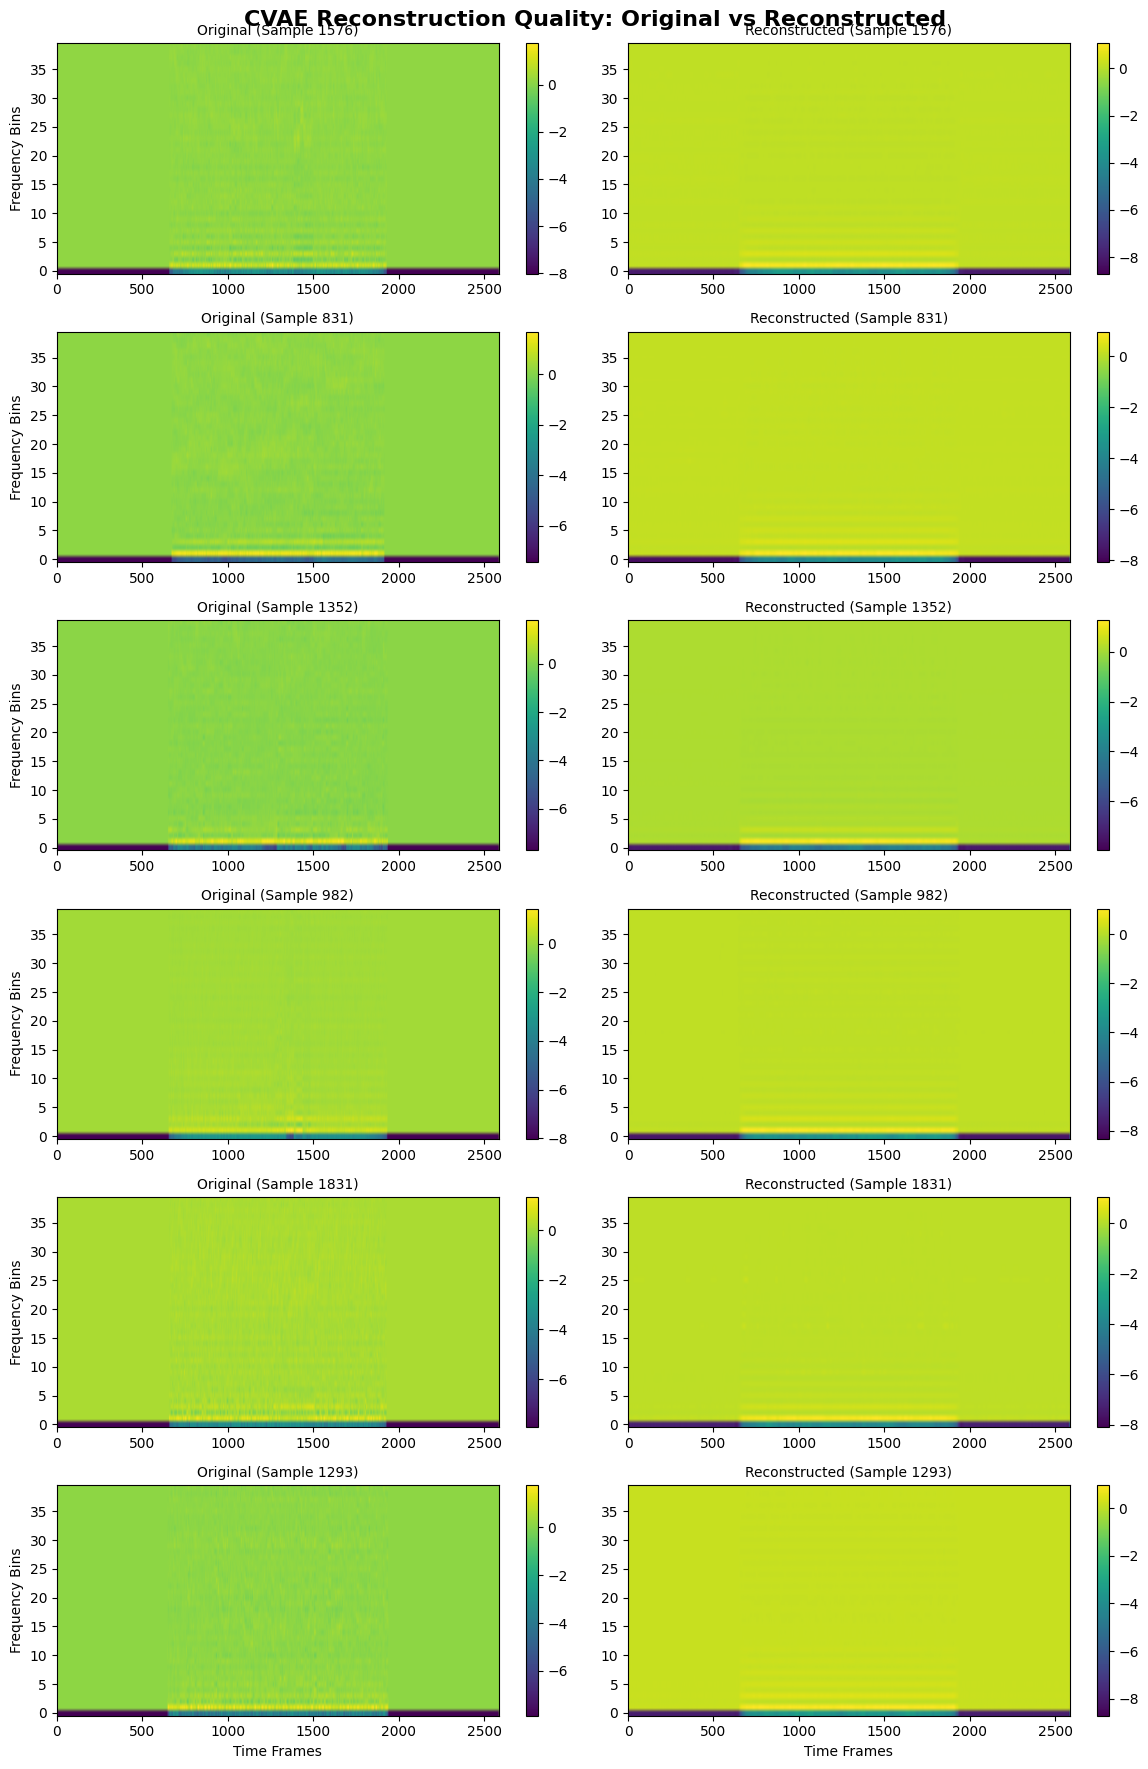

   Mean Reconstruction MSE: 0.015785
   Median Reconstruction MSE: 0.013830

2. Generating cluster-genre distribution...
   Using clustering method: BetaVAE+Lyrics_KMeans
   Saved: Results/HardTask_CVAE\CVAE_Standard\cluster_genre_distribution.png


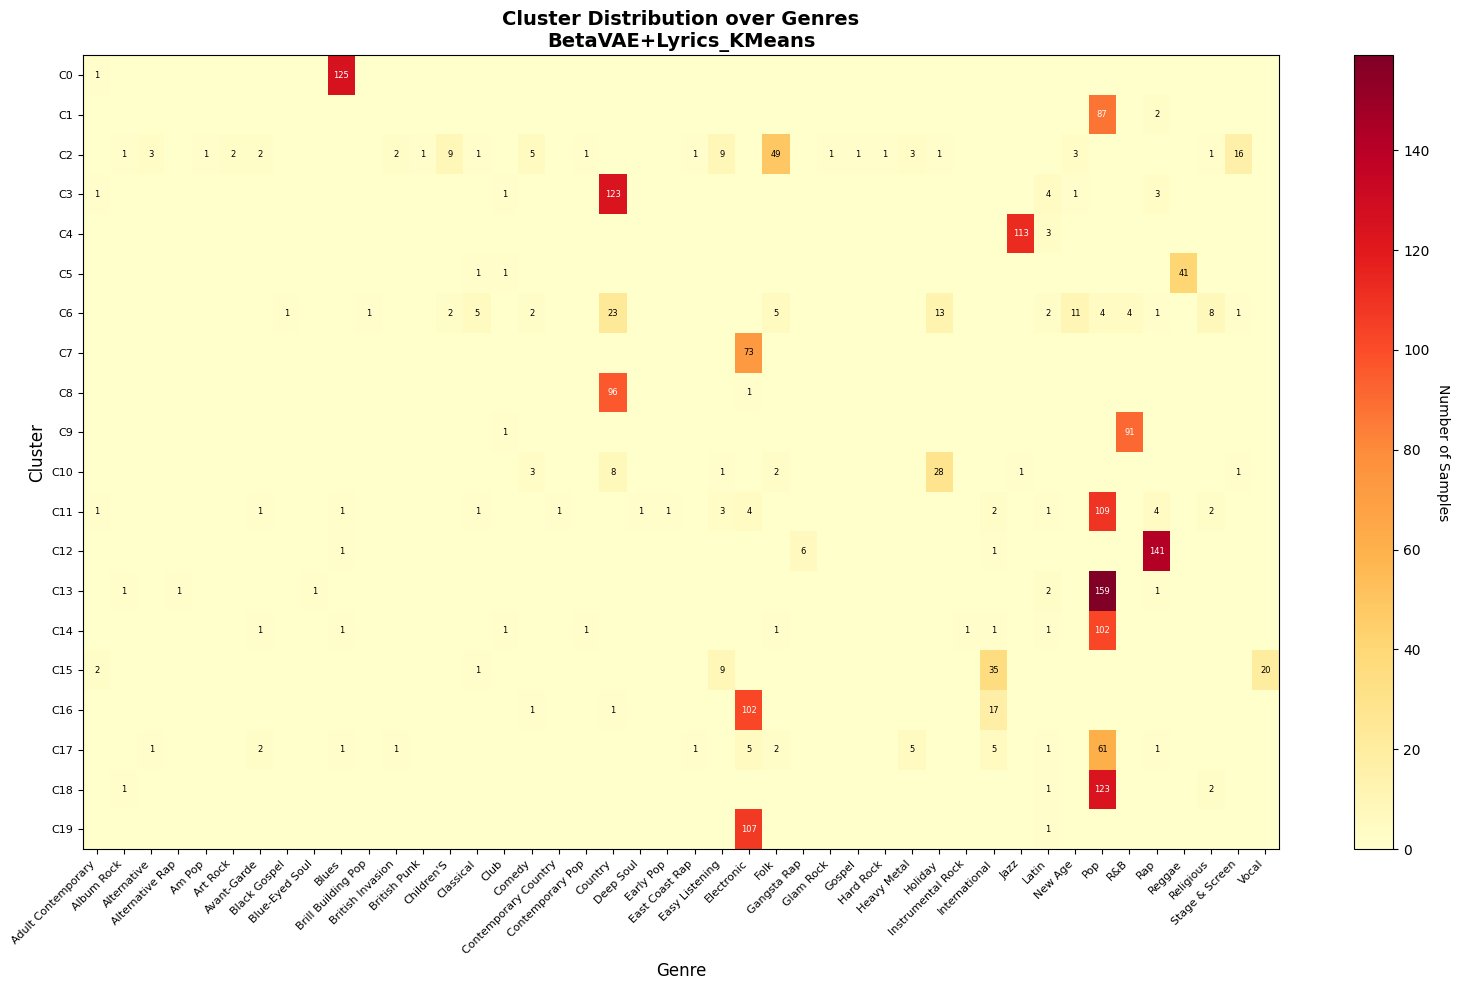


3. Generating latent space visualizations...
   Applying UMAP to latent space...


c:\Users\T2510603\Downloads\Data\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# ======================================================================
# HARD TASK - ENHANCED VISUALIZATIONS
# ======================================================================
# 1. VAE Reconstruction Quality
# 2. Cluster Distribution over Genres
# 3. Latent Space Visualizations with Cluster/Genre Overlays

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

print("="*80)
print("GENERATING HARD TASK VISUALIZATIONS")
print("="*80)

VIZ_OUT_DIR = os.path.join(HARD_OUT_DIR, best_hard_config["config_name"])
os.makedirs(VIZ_OUT_DIR, exist_ok=True)

# -------------------------
# 1. RECONSTRUCTION EXAMPLES
# -------------------------
print("\n1. Generating reconstruction examples...")

# Select 6 random samples for reconstruction visualization
np.random.seed(SEED)
sample_indices = np.random.choice(len(X_audio), size=6, replace=False)

fig, axes = plt.subplots(6, 2, figsize=(12, 18))
fig.suptitle("CVAE Reconstruction Quality: Original vs Reconstructed", fontsize=16, fontweight='bold')

for idx, sample_idx in enumerate(sample_indices):
    # Original
    original = X_audio[sample_idx, 0]  # Shape: (F, T)
    reconstructed = best_hard_config["X_recon"][sample_idx, 0]
    
    # Plot original
    im1 = axes[idx, 0].imshow(original, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 0].set_title(f"Original (Sample {sample_idx})", fontsize=10)
    axes[idx, 0].set_ylabel("Frequency Bins")
    if idx == 5:
        axes[idx, 0].set_xlabel("Time Frames")
    plt.colorbar(im1, ax=axes[idx, 0])
    
    # Plot reconstruction
    im2 = axes[idx, 1].imshow(reconstructed, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 1].set_title(f"Reconstructed (Sample {sample_idx})", fontsize=10)
    if idx == 5:
        axes[idx, 1].set_xlabel("Time Frames")
    plt.colorbar(im2, ax=axes[idx, 1])

plt.tight_layout()
recon_path = os.path.join(VIZ_OUT_DIR, "reconstruction_examples.png")
plt.savefig(recon_path, dpi=150, bbox_inches='tight')
print(f"   Saved: {recon_path}")
plt.show()

# Compute reconstruction error
mse_per_sample = np.mean((X_audio - best_hard_config["X_recon"])**2, axis=(1, 2, 3))
print(f"   Mean Reconstruction MSE: {np.mean(mse_per_sample):.6f}")
print(f"   Median Reconstruction MSE: {np.median(mse_per_sample):.6f}")

# -------------------------
# 2. CLUSTER DISTRIBUTION OVER GENRES
# -------------------------
print("\n2. Generating cluster-genre distribution...")

# Get best clustering method
best_method_name, best_labels, best_metrics = best_hard_config["all_res"][0]
print(f"   Using clustering method: {best_method_name}")

# Filter for samples with genre labels
valid_mask = y_ari != -1
valid_labels = best_labels[valid_mask]
valid_genres = y_ari[valid_mask]

# Create contingency table
unique_clusters = sorted(set(valid_labels))
unique_genre_ids = sorted(set(valid_genres))

# Map genre IDs to genre names (if available, otherwise use IDs)
genre_label_map = {}
if os.path.exists("genre_processed.csv"):
    gdf_viz = pd.read_csv("genre_processed.csv")
    genre_cols = [c for c in gdf_viz.columns if c.startswith("genre__")]
    if len(genre_cols) > 0:
        for idx, col in enumerate(genre_cols):
            genre_name = col.replace("genre__", "").replace("_", " ").title()
            genre_label_map[idx] = genre_name[:20]  # Truncate long names

# Create heatmap data
heatmap_data = np.zeros((len(unique_clusters), len(unique_genre_ids)))
for i, cluster in enumerate(unique_clusters):
    for j, genre in enumerate(unique_genre_ids):
        count = np.sum((valid_labels == cluster) & (valid_genres == genre))
        heatmap_data[i, j] = count

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

# Set ticks
ax.set_xticks(np.arange(len(unique_genre_ids)))
ax.set_yticks(np.arange(len(unique_clusters)))

# Label with genre names if available
x_labels = [genre_label_map.get(g, f"G{g}") for g in unique_genre_ids]
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels([f"C{c}" for c in unique_clusters], fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Samples', rotation=270, labelpad=15)

# Add text annotations for non-zero cells
for i in range(len(unique_clusters)):
    for j in range(len(unique_genre_ids)):
        if heatmap_data[i, j] > 0:
            text = ax.text(j, i, int(heatmap_data[i, j]),
                          ha="center", va="center", color="black" if heatmap_data[i, j] < heatmap_data.max()/2 else "white",
                          fontsize=6)

ax.set_title(f"Cluster Distribution over Genres\n{best_method_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Genre", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)

plt.tight_layout()
dist_path = os.path.join(VIZ_OUT_DIR, "cluster_genre_distribution.png")
plt.savefig(dist_path, dpi=150, bbox_inches='tight')
print(f"   Saved: {dist_path}")
plt.show()

# -------------------------
# 3. LATENT SPACE VISUALIZATION
# -------------------------
print("\n3. Generating latent space visualizations...")

Z_latent = best_hard_config["Z_audio"]

# Subsample for visualization
n_viz = min(2000, len(Z_latent))
viz_indices = np.random.choice(len(Z_latent), n_viz, replace=False)
Z_viz = Z_latent[viz_indices]
labels_viz = best_labels[viz_indices]
genres_viz = y_ari[viz_indices]

# Apply UMAP
if UMAP_AVAILABLE:
    print("   Applying UMAP to latent space...")
    reducer = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
    Z_2d = reducer.fit_transform(Z_viz)
    
    # Plot 1: Colored by Cluster
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    scatter1 = ax1.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels_viz, cmap='tab20', 
                          alpha=0.6, s=20, edgecolors='none')
    ax1.set_title(f"Latent Space Colored by Cluster\n{best_method_name}", fontsize=12, fontweight='bold')
    ax1.set_xlabel("UMAP Dimension 1")
    ax1.set_ylabel("UMAP Dimension 2")
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Cluster ID')
    
    # Plot 2: Colored by Genre (only show samples with labels)
    genre_mask = genres_viz != -1
    scatter2 = ax2.scatter(Z_2d[genre_mask, 0], Z_2d[genre_mask, 1], 
                          c=genres_viz[genre_mask], cmap='Spectral', 
                          alpha=0.6, s=20, edgecolors='none')
    ax2.scatter(Z_2d[~genre_mask, 0], Z_2d[~genre_mask, 1], 
               c='gray', alpha=0.2, s=10, edgecolors='none', label='Unknown')
    ax2.set_title(f"Latent Space Colored by Genre\n{n_viz} samples", fontsize=12, fontweight='bold')
    ax2.set_xlabel("UMAP Dimension 1")
    ax2.set_ylabel("UMAP Dimension 2")
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Genre ID')
    ax2.legend()
    
    plt.tight_layout()
    latent_path = os.path.join(VIZ_OUT_DIR, "latent_space_umap.png")
    plt.savefig(latent_path, dpi=150, bbox_inches='tight')
    print(f"   Saved: {latent_path}")
    plt.show()
else:
    print("   UMAP not available, skipping latent space visualization")

# -------------------------
# 4. GENRE PURITY PER CLUSTER
# -------------------------
print("\n4. Generating cluster purity analysis...")

cluster_purity_data = []
for cluster in unique_clusters:
    cluster_mask = valid_labels == cluster
    cluster_genres = valid_genres[cluster_mask]
    
    if len(cluster_genres) > 0:
        # Find dominant genre
        genre_counts = Counter(cluster_genres)
        dominant_genre, dominant_count = genre_counts.most_common(1)[0]
        purity = dominant_count / len(cluster_genres)
        
        cluster_purity_data.append({
            'Cluster': cluster,
            'Size': len(cluster_genres),
            'Dominant_Genre': genre_label_map.get(dominant_genre, f"G{dominant_genre}"),
            'Purity': purity,
            'N_Genres': len(genre_counts)
        })

purity_df = pd.DataFrame(cluster_purity_data).sort_values(by='Purity', ascending=False)

# Plot cluster purity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of purity
bars = ax1.bar(range(len(purity_df)), purity_df['Purity'], 
               color=plt.cm.RdYlGn(purity_df['Purity']))
ax1.set_xlabel('Cluster Index (sorted by purity)')
ax1.set_ylabel('Purity')
ax1.set_title('Cluster Purity (Fraction of Dominant Genre)', fontweight='bold')
ax1.axhline(y=purity_df['Purity'].mean(), color='blue', linestyle='--', 
            label=f'Mean: {purity_df["Purity"].mean():.3f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Scatter: Cluster size vs purity
scatter = ax2.scatter(purity_df['Size'], purity_df['Purity'], 
                     s=purity_df['Size']*2, alpha=0.6, 
                     c=purity_df['N_Genres'], cmap='coolwarm')
ax2.set_xlabel('Cluster Size')
ax2.set_ylabel('Purity')
ax2.set_title('Cluster Size vs Purity', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Number of Genres in Cluster')
ax2.grid(alpha=0.3)

plt.tight_layout()
purity_path = os.path.join(VIZ_OUT_DIR, "cluster_purity_analysis.png")
plt.savefig(purity_path, dpi=150, bbox_inches='tight')
print(f"   Saved: {purity_path}")
plt.show()

# Save purity table
purity_csv_path = os.path.join(VIZ_OUT_DIR, "cluster_purity_table.csv")
purity_df.to_csv(purity_csv_path, index=False)
print(f"   Saved: {purity_csv_path}")

print(f"\n{'='*80}")
print("VISUALIZATION GENERATION COMPLETE!")
print(f"All visualizations saved to: {VIZ_OUT_DIR}")
print(f"{'='*80}")

print(f"\nVisualizing results for: {best_method_name}")
print(f"Metrics: ARI={best_metrics['ari']:.4f}, NMI={best_metrics['nmi']:.4f}, Purity={best_metrics['purity']:.4f}")

# -------------------------
# 1. VAE RECONSTRUCTION QUALITY
# -------------------------
print("\n1. Generating VAE reconstruction examples...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(f"VAE Reconstruction Quality - {best_hard_config['config_name']}", fontsize=16)

# Select 5 random samples
sample_indices = np.random.choice(len(X_audio), 5, replace=False)

for i, idx in enumerate(sample_indices):
    # Original
    axes[0, i].imshow(X_audio[idx, 0], aspect='auto', origin='lower', cmap='viridis')
    axes[0, i].set_title(f"Original {kept_ids[idx][:10]}")
    axes[0, i].set_ylabel("MFCC Coeffs")
    axes[0, i].set_xlabel("Time Frames")
    
    # Reconstructed
    axes[1, i].imshow(best_hard_config['X_recon'][idx, 0], aspect='auto', origin='lower', cmap='viridis')
    axes[1, i].set_title(f"Reconstructed")
    axes[1, i].set_ylabel("MFCC Coeffs")
    axes[1, i].set_xlabel("Time Frames")

plt.tight_layout()
plt.savefig(os.path.join(HARD_OUT_DIR, "vae_reconstructions.png"), dpi=150, bbox_inches='tight')
print(f"  Saved: {HARD_OUT_DIR}/vae_reconstructions.png")
plt.show()

# Compute reconstruction error
recon_errors = np.mean((X_audio - best_hard_config['X_recon'])**2, axis=(1, 2, 3))
print(f"  Mean reconstruction MSE: {recon_errors.mean():.6f}")
print(f"  Std reconstruction MSE: {recon_errors.std():.6f}")

# -------------------------
# 2. CLUSTER DISTRIBUTION OVER GENRES
# -------------------------
print("\n2. Generating cluster distribution over genres...")

# Get genre labels
if have_ari and (y_ari != -1).sum() > 0:
    # Create genre names from genre_onehot_cols
    genre_names = [c.replace("genre__", "") for c in genre_onehot_cols]
    
    # Filter to valid samples
    valid_mask = (y_ari != -1) & (best_labels != -1)
    valid_clusters = best_labels[valid_mask]
    valid_genres = y_ari[valid_mask]
    
    # Create contingency table
    cluster_genre_df = pd.DataFrame({
        'cluster': valid_clusters,
        'genre': valid_genres
    })
    
    contingency = pd.crosstab(cluster_genre_df['cluster'], cluster_genre_df['genre'])
    
    # Show top genres per cluster
    print(f"\n  Top 5 genres per cluster:")
    for cluster_id in sorted(set(valid_clusters)):
        if cluster_id in contingency.index:
            top_genres = contingency.loc[cluster_id].nlargest(5)
            genre_str = ", ".join([f"{genre_names[int(g)]}({int(top_genres[g])})" for g in top_genres.index])
            print(f"    Cluster {cluster_id}: {genre_str}")
    
    # Visualize heatmap (top 20 clusters x top 30 genres)
    top_clusters = contingency.sum(axis=1).nlargest(20).index
    top_genres_idx = contingency.sum(axis=0).nlargest(30).index
    
    contingency_subset = contingency.loc[top_clusters, top_genres_idx]
    
    fig, ax = plt.subplots(figsize=(16, 10))
    im = ax.imshow(contingency_subset.values, aspect='auto', cmap='YlOrRd')
    ax.set_xticks(np.arange(len(top_genres_idx)))
    ax.set_yticks(np.arange(len(top_clusters)))
    ax.set_xticklabels([genre_names[int(i)][:15] for i in top_genres_idx], rotation=90)
    ax.set_yticklabels([f"C{int(c)}" for c in top_clusters])
    ax.set_xlabel("Genre", fontsize=12)
    ax.set_ylabel("Cluster", fontsize=12)
    ax.set_title(f"Cluster-Genre Distribution Heatmap\n{best_method_name}", fontsize=14)
    plt.colorbar(im, ax=ax, label="Track Count")
    plt.tight_layout()
    plt.savefig(os.path.join(HARD_OUT_DIR, "cluster_genre_heatmap.png"), dpi=150, bbox_inches='tight')
    print(f"  Saved: {HARD_OUT_DIR}/cluster_genre_heatmap.png")
    plt.show()
    
    # Cluster purity distribution
    cluster_purities = []
    for cluster_id in sorted(set(valid_clusters)):
        if cluster_id in contingency.index:
            cluster_size = contingency.loc[cluster_id].sum()
            max_genre = contingency.loc[cluster_id].max()
            purity = max_genre / cluster_size if cluster_size > 0 else 0
            cluster_purities.append(purity)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(cluster_purities, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(cluster_purities), color='red', linestyle='--', linewidth=2, label=f'Mean={np.mean(cluster_purities):.3f}')
    ax.set_xlabel("Cluster Purity", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(f"Distribution of Cluster Purities\n{best_method_name}", fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(HARD_OUT_DIR, "cluster_purity_distribution.png"), dpi=150, bbox_inches='tight')
    print(f"  Saved: {HARD_OUT_DIR}/cluster_purity_distribution.png")
    plt.show()
else:
    print("  No genre labels available for distribution analysis")

# -------------------------
# 3. LATENT SPACE VISUALIZATIONS
# -------------------------
print("\n3. Generating latent space visualizations...")

X_fused_vis = best_hard_config['X_fused']

# Sample for visualization if needed
n_samples = min(VIZ_SAMPLES, len(X_fused_vis))
if n_samples < len(X_fused_vis):
    vis_idx = np.random.choice(len(X_fused_vis), n_samples, replace=False)
else:
    vis_idx = np.arange(len(X_fused_vis))

X_vis = X_fused_vis[vis_idx]
labels_vis = best_labels[vis_idx]
y_vis = y_ari[vis_idx] if have_ari else None

# Reduce dimensionality for visualization
if UMAP_AVAILABLE:
    print("  Using UMAP for dimensionality reduction...")
    reducer = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
    X_2d = reducer.fit_transform(X_vis)
else:
    print("  Using t-SNE for dimensionality reduction...")
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
    X_2d = tsne.fit_transform(X_vis)

# Plot 1: Colored by cluster
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_vis, cmap='tab20', 
                     alpha=0.6, s=20, edgecolors='none')
ax.set_title(f"Latent Space Visualization - Colored by Cluster\n{best_method_name}", fontsize=14)
ax.set_xlabel("Component 1", fontsize=12)
ax.set_ylabel("Component 2", fontsize=12)
plt.colorbar(scatter, ax=ax, label="Cluster ID")
plt.tight_layout()
plt.savefig(os.path.join(HARD_OUT_DIR, "latent_space_clusters.png"), dpi=150, bbox_inches='tight')
print(f"  Saved: {HARD_OUT_DIR}/latent_space_clusters.png")
plt.show()

# Plot 2: Colored by genre (if available)
if have_ari and y_vis is not None:
    valid_genre_mask = y_vis != -1
    
    fig, ax = plt.subplots(figsize=(12, 10))
    # Show unlabeled in gray
    ax.scatter(X_2d[~valid_genre_mask, 0], X_2d[~valid_genre_mask, 1], 
               c='lightgray', alpha=0.3, s=10, label='No genre', edgecolors='none')
    # Show labeled with genre colors
    scatter = ax.scatter(X_2d[valid_genre_mask, 0], X_2d[valid_genre_mask, 1], 
                        c=y_vis[valid_genre_mask], cmap='tab20', 
                        alpha=0.7, s=20, edgecolors='none')
    ax.set_title(f"Latent Space Visualization - Colored by Genre\n{best_method_name}", fontsize=14)
    ax.set_xlabel("Component 1", fontsize=12)
    ax.set_ylabel("Component 2", fontsize=12)
    plt.colorbar(scatter, ax=ax, label="Genre ID")
    plt.tight_layout()
    plt.savefig(os.path.join(HARD_OUT_DIR, "latent_space_genres.png"), dpi=150, bbox_inches='tight')
    print(f"  Saved: {HARD_OUT_DIR}/latent_space_genres.png")
    plt.show()

# -------------------------
# 4. METRICS COMPARISON ACROSS ALL METHODS
# -------------------------
print("\n4. Generating metrics comparison plot...")

results_df = best_hard_config["results"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f"Metrics Comparison - {best_hard_config['config_name']}", fontsize=16)

metrics_to_plot = [
    ('silhouette', 'Silhouette Score', axes[0, 0]),
    ('ari', 'Adjusted Rand Index', axes[0, 1]),
    ('nmi', 'Normalized Mutual Information', axes[1, 0]),
    ('purity', 'Cluster Purity', axes[1, 1])
]

for metric, title, ax in metrics_to_plot:
    valid_data = results_df[~results_df[metric].isna()].copy()
    if len(valid_data) > 0:
        valid_data = valid_data.sort_values(by=metric, ascending=False)
        bars = ax.barh(range(len(valid_data)), valid_data[metric], color='steelblue', alpha=0.7)
        ax.set_yticks(range(len(valid_data)))
        ax.set_yticklabels(valid_data['method'], fontsize=9)
        ax.set_xlabel(title, fontsize=11)
        ax.set_title(title, fontsize=12)
        ax.grid(axis='x', alpha=0.3)
        
        # Highlight best
        best_idx = 0
        bars[best_idx].set_color('darkgreen')
        bars[best_idx].set_alpha(0.9)

plt.tight_layout()
plt.savefig(os.path.join(HARD_OUT_DIR, "metrics_comparison.png"), dpi=150, bbox_inches='tight')
print(f"  Saved: {HARD_OUT_DIR}/metrics_comparison.png")
plt.show()

print(f"\n{'='*80}")
print("HARD TASK VISUALIZATIONS COMPLETE!")
print(f"{'='*80}")
print(f"\nAll visualizations saved to: {HARD_OUT_DIR}/")
print(f"\nKey findings:")
print(f"  - Best method: {best_method_name}")
print(f"  - ARI: {best_metrics['ari']:.4f}")
print(f"  - NMI: {best_metrics['nmi']:.4f}")
print(f"  - Purity: {best_metrics['purity']:.4f}")
print(f"  - Silhouette: {best_metrics['silhouette']:.4f}")


In [3]:
# ======================================================================
# CHECK IF ARI IS POSSIBLE FOR MEDIUM TASK - Music_Id Analysis
# ======================================================================

import pandas as pd
import os
import glob
import numpy as np

print("="*80)
print("INVESTIGATING Music_Id OVERLAP FOR ARI COMPUTATION")
print("="*80)

# 1. Load genre data with Music_Id
genre_df = pd.read_csv("genre.csv")
print(f"\n1. Genre file (genre.csv):")
print(f"   Total rows: {len(genre_df)}")
print(f"   Columns: {genre_df.columns.tolist()}")
print(f"   Sample Music_Ids: {genre_df['Music_Id'].head(5).tolist()}")

# 2. Check genre_processed.csv
genre_proc_df = pd.read_csv("genre_processed.csv")
print(f"\n2. Processed genre file (genre_processed.csv):")
print(f"   Total rows: {len(genre_proc_df)}")
print(f"   Columns: {genre_proc_df.columns.tolist()[:10]}...")  # Show first 10 columns

# Find ID column
id_col = None
for c in genre_proc_df.columns:
    if c.lower() in ["music_id", "track_id", "song_id", "id", "filename", "file"]:
        id_col = c
        break

if id_col:
    print(f"   ID column found: '{id_col}'")
    print(f"   Sample IDs: {genre_proc_df[id_col].head(5).tolist()}")
else:
    print("   ❌ No ID column found in genre_processed.csv")

# 3. Check Audio Features
audio_files = glob.glob("Audio_Features/*.npz")
audio_ids = [os.path.splitext(os.path.basename(f))[0] for f in audio_files]

# Separate by type
mt_audio_ids = [aid for aid in audio_ids if aid.startswith("MT")]
a_audio_ids = [aid for aid in audio_ids if aid.startswith("A")]

print(f"\n3. Audio Features:")
print(f"   Total audio files: {len(audio_files)}")
print(f"   MT-series (Music_Id format): {len(mt_audio_ids)}")
print(f"   A-series (other format): {len(a_audio_ids)}")
print(f"   Sample MT IDs: {mt_audio_ids[:5]}")

# 4. Check Lyrics
lyrics_df = pd.read_csv("Lyrics_Processed/lyrics_cleaned.csv")
print(f"\n4. Lyrics:")
print(f"   Total lyrics: {len(lyrics_df)}")
print(f"   track_id column exists: {'track_id' in lyrics_df.columns}")
if 'track_id' in lyrics_df.columns:
    print(f"   Sample track_ids: {lyrics_df['track_id'].head(5).tolist()}")

# 5. CRITICAL: Check overlap
print(f"\n{'='*80}")
print("OVERLAP ANALYSIS")
print(f"{'='*80}")

# Genre Music_Ids
genre_music_ids = set(genre_df['Music_Id'].astype(str))
print(f"\nUnique Music_Ids in genre.csv: {len(genre_music_ids)}")

# Audio MT files
audio_mt_set = set(mt_audio_ids)
print(f"MT-series audio files: {len(audio_mt_set)}")

# Overlap between genre and audio
genre_audio_overlap = genre_music_ids & audio_mt_set
print(f"✓ Overlap (Genre ∩ Audio MT-series): {len(genre_audio_overlap)}")

# Check if lyrics also has Music_Id
lyrics_has_mt = False
if 'track_id' in lyrics_df.columns:
    lyrics_ids = set(lyrics_df['track_id'].astype(str))
    lyrics_mt = {lid for lid in lyrics_ids if lid.startswith("MT")}
    print(f"MT-series in lyrics track_ids: {len(lyrics_mt)}")
    
    if len(lyrics_mt) > 0:
        lyrics_has_mt = True
        # Triple overlap
        triple_overlap = genre_music_ids & audio_mt_set & lyrics_mt
        print(f"✓✓✓ TRIPLE OVERLAP (Genre ∩ Audio ∩ Lyrics): {len(triple_overlap)}")
    else:
        print(f"❌ No MT-series IDs in lyrics")

# 6. Conclusion
print(f"\n{'='*80}")
print("CONCLUSION FOR MEDIUM TASK ARI")
print(f"{'='*80}")

if len(genre_audio_overlap) > 0:
    if lyrics_has_mt and len(triple_overlap) > 0:
        print(f"✓ YES! ARI IS POSSIBLE!")
        print(f"  There are {len(triple_overlap)} tracks with:")
        print(f"    - Genre labels (from genre.csv)")
        print(f"    - Audio features (MT-series .npz files)")
        print(f"    - Lyrics data (MT-series track_ids)")
        print(f"\n  Current Medium Task used A-series + L-series IDs")
        print(f"  which have NO overlap with genre Music_Ids.")
        print(f"\n  TO FIX: Re-run Medium Task using only MT-series IDs!")
    else:
        print(f"⚠️  PARTIAL: {len(genre_audio_overlap)} tracks have genre + audio")
        print(f"  but lyrics use different IDs (L-series instead of MT-series)")
        print(f"  ARI possible for audio-only clustering, but not multimodal.")
else:
    print(f"❌ NO: No overlap found. Different ID schemes in use.")

# Show the ID mismatch
print(f"\n{'='*80}")
print("ID SCHEME SUMMARY")
print(f"{'='*80}")
print(f"Genre labels:    Music_Id (MT0000xxxxx)")
print(f"Audio files:     MT-series ({len(mt_audio_ids)}) + A-series ({len(a_audio_ids)})")  
print(f"Lyrics:          track_id (L###-### format)")
print(f"\n✓ Genre and Audio use compatible IDs (Music_Id)")
print(f"❌ Lyrics use incompatible IDs (L-series, not Music_Id)")


INVESTIGATING Music_Id OVERLAP FOR ARI COMPUTATION

1. Genre file (genre.csv):
   Total rows: 2210
   Columns: ['Music_Id', 'Title', 'Duration', 'Genres']
   Sample Music_Ids: ['MT0000291374', 'MT0001577585', 'MT0008469560', 'MT0030326044', 'MT0005204984']

2. Processed genre file (genre_processed.csv):
   Total rows: 2184
   Columns: ['Music_Id', 'Title', 'Duration', 'Genres', 'Genres_list', 'genre__adult alternative', 'genre__adult alternative pop', 'genre__adult contemporary', 'genre__album rock', 'genre__alternative']...
   ID column found: 'Music_Id'
   Sample IDs: ['MT0000291374', 'MT0001577585', 'MT0008469560', 'MT0030326044', 'MT0005204984']

3. Audio Features:
   Total audio files: 3554
   MT-series (Music_Id format): 3421
   A-series (other format): 133
   Sample MT IDs: ['MT0000004637', 'MT0000008995', 'MT0000010219', 'MT0000010844', 'MT0000011357']

4. Lyrics:
   Total lyrics: 2568
   track_id column exists: True
   Sample track_ids: ['L001-141', 'L002-157', 'L004-120', 'L0

Device: cpu

Audio feature files: 3554
Audio key='mfcc' shape: F=40, T=500 (truncated to 500)

Loaded SBERT embeddings: (2568, 384)
Lyrics repr: sbert | dim: 384

Genre classes: 158 | Genre rows: 2184 | ID col: Title
N_CLUSTERS: 10

Alignment summary:
Total IDs (union): 6146
Kept IDs: 6146 (KEEP_MISSING=True)

Loaded tensors:
X_lyrics: (6146, 384) | X_genre: (6146, 158)
Genre labels available: 2107 / 6146
Language labels available: 2568 / 6146

Model ready:
Mode: Beta-VAE | latent_dim=32 | beta=4.0
Audio conv out shape: torch.Size([64, 5, 63]) | flat: 20160
Training samples: 5224 | Validation samples: 922
Epoch   1 | train: total=1.4090 a=0.2704 l=0.9733 g=0.1561 kl=0.0218 | val: total=1.2234
Epoch   5 | train: total=1.0701 a=0.0372 l=0.8530 g=0.0164 kl=0.0429 | val: total=1.0678
Epoch  10 | train: total=1.0509 a=0.0273 l=0.8361 g=0.0153 kl=0.0450 | val: total=1.0569
Epoch  15 | train: total=1.0451 a=0.0262 l=0.8327 g=0.0151 kl=0.0447 | val: total=1.0553
Epoch  20 | train: total=1.0434

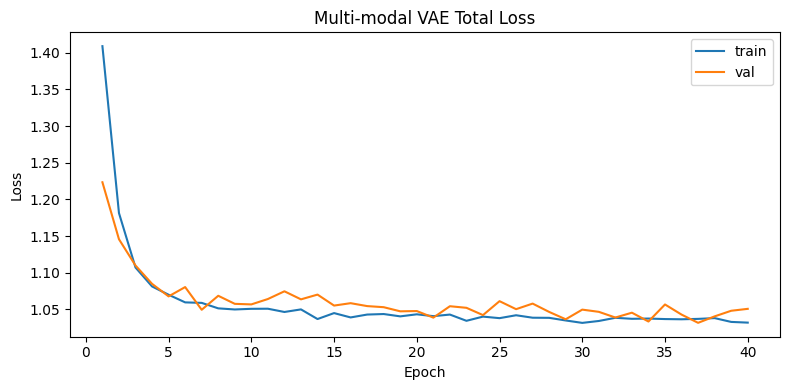

Best model loaded.

Extracting latent features...
Extracted Z latent: (6146, 32) | Saved Z_latent_mu.npy

===== VAE Latent + KMeans =====
Silhouette: 0.8054
Genre  -> ARI: 0.0000 | NMI: 0.0000 | Purity: 0.3042
Lang   -> ARI: 0.0000 | NMI: 0.0000 | Purity: 1.0000

Computing baselines...

================= COMPARISON TABLE =================
                method  silhouette  ari_genre  nmi_genre  purity_genre  ari_lang  nmi_lang  purity_lang
     VAE_latent+KMeans    0.802801        0.0        0.0      0.308571       0.0       0.0          1.0
DirectAudioMean+KMeans    0.657753        0.0        0.0      0.308571       0.0       0.0          1.0
     PCA(fused)+KMeans    0.566388        0.0        0.0      0.308571       0.0       0.0          1.0

Generating visualizations...


c:\Users\T2510603\Downloads\Data\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


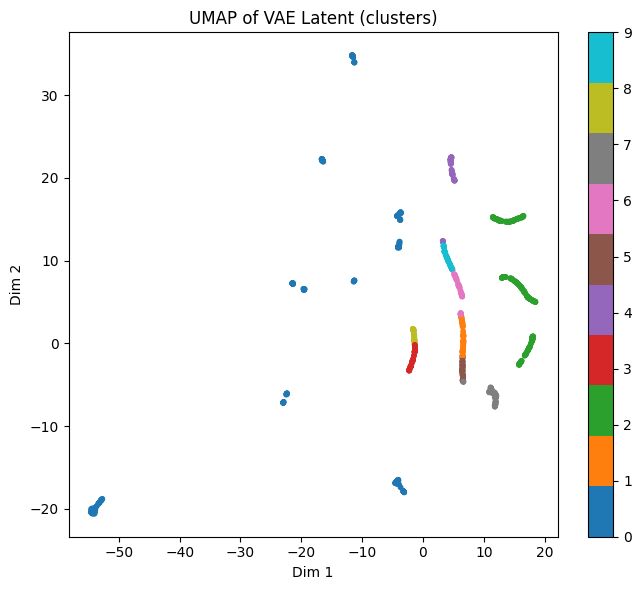

Saved plot: Results/HardTask\viz_umap_clusters.png


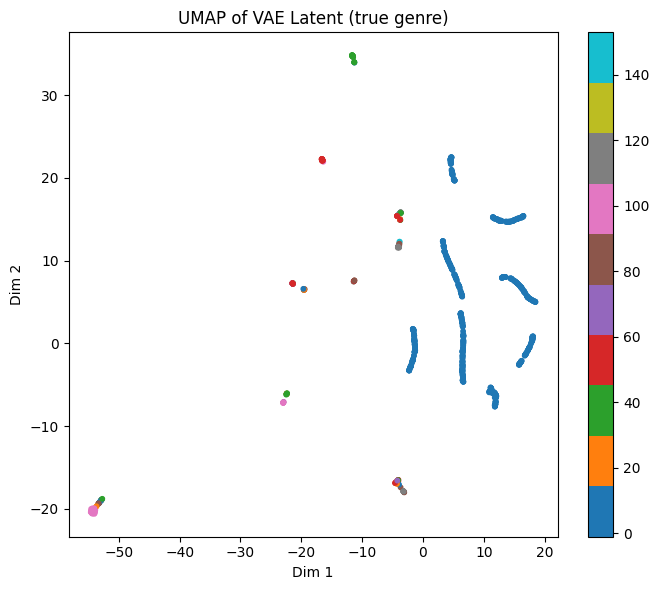

Saved plot: Results/HardTask\viz_umap_genre.png


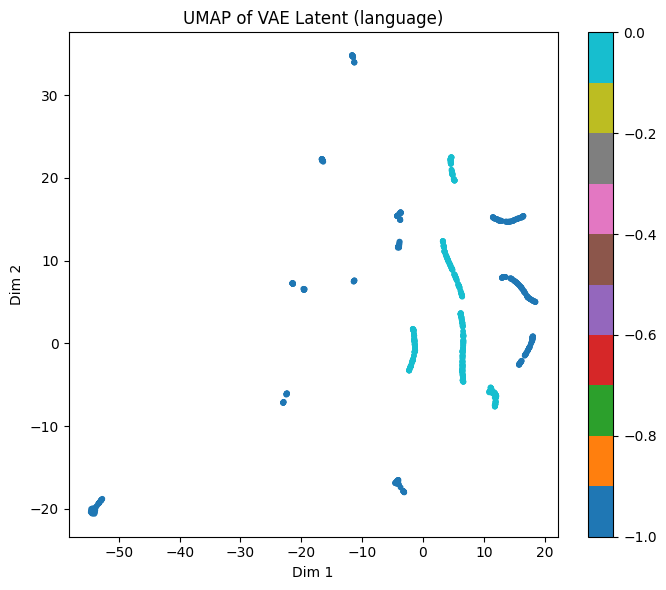

Saved plot: Results/HardTask\viz_umap_language.png

Generating reconstruction examples...


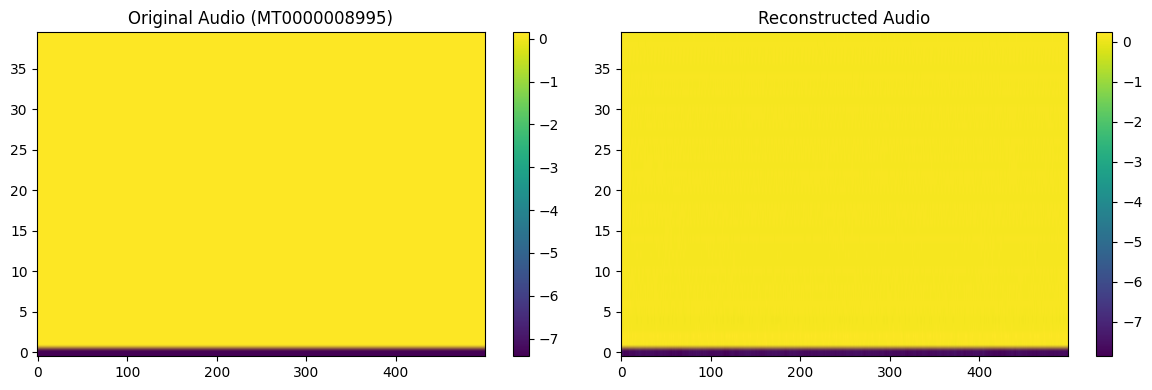

Recon #1 | track=MT0000008995 | Lyrics cosine sim: 0.6178


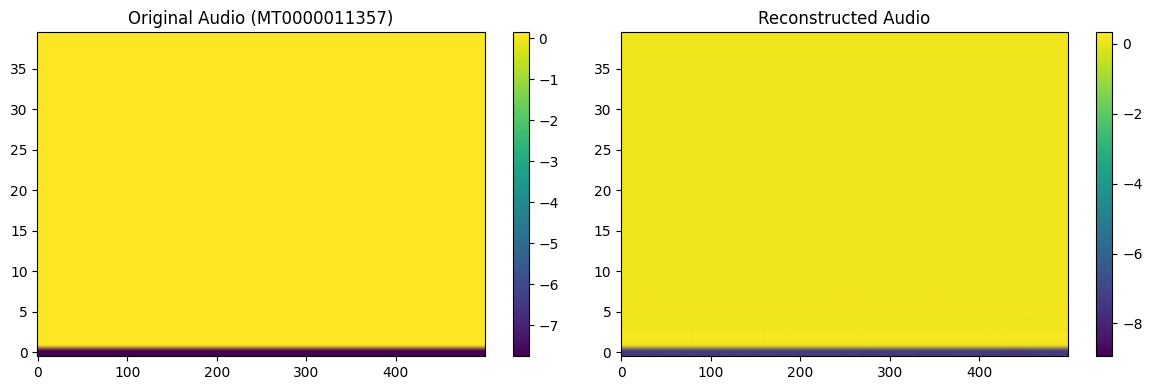

Recon #2 | track=MT0000011357 | Lyrics cosine sim: 0.3738


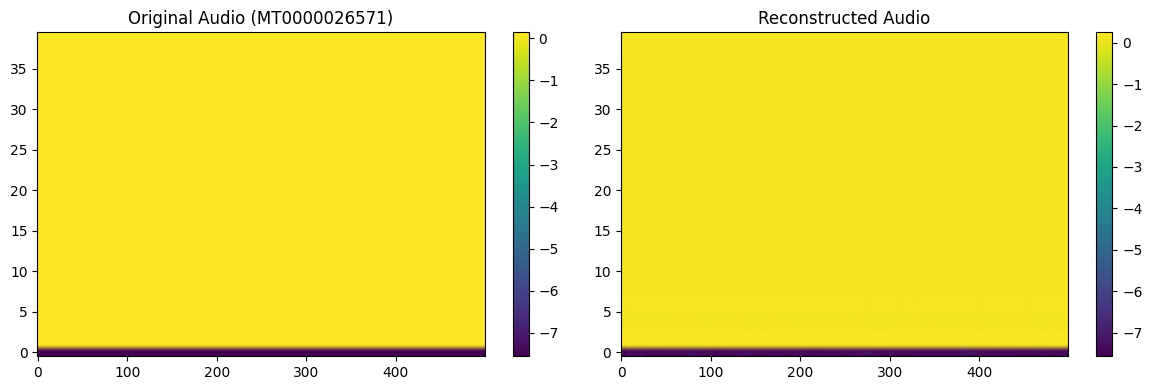

Recon #3 | track=MT0000026571 | Lyrics cosine sim: 0.5593

================ SUMMARY =================
Total samples processed: 6146
Latent dimension: 32
Number of clusters: 10
Best VAE silhouette: 0.8054

All outputs saved to: Results/HardTask
Done .


In [2]:
# ======================================================================
# HARD TASK PIPELINE (Beta-VAE / optional CVAE) + Multi-modal Clustering
# ======================================================================
# MEMORY-OPTIMIZED VERSION: Loads audio on-the-fly and truncates time dimension
#
# Implements:
# 1) Multi-modal Beta-VAE (audio 2D + lyrics embedding + genre multi-hot)
# 2) Clustering on latent features: KMeans (main), plus baselines
# 3) Metrics: Silhouette, NMI, ARI, Purity (vs genre and vs language labels)
# 4) Visualizations: Latent space, cluster distributions, reconstruction examples
# 5) Saves all outputs to Results/HardTask

import os, glob, json, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

# Optional UMAP
UMAP_OK = True
try:
    import umap
except Exception:
    UMAP_OK = False

from sklearn.manifold import TSNE

# TF-IDF optional sparse
TFIDF_OK = True
try:
    from scipy.sparse import load_npz
except Exception:
    TFIDF_OK = False

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------
# CONFIG
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Paths
AUDIO_FEAT_DIR = "Audio_Features"
LYRICS_CLEANED_CSV = "Lyrics_Processed/lyrics_cleaned.csv"
LYRICS_SBERT_NPY = "Lyrics_Processed/lyrics_sbert_embeddings.npy"
LYRICS_TFIDF_NPZ = "Lyrics_Processed/lyrics_tfidf.npz"
GENRE_PROCESSED_CSV = "genre_processed.csv"

OUT_DIR = "Results/HardTask"
os.makedirs(OUT_DIR, exist_ok=True)

# Modalities
AUDIO_2D_KEY = "mfcc"  # "mfcc" or "mel_db"
KEEP_MISSING = True    # keep audio-only / lyrics-only by zero-filling

# MEMORY OPTIMIZATION: Truncate time dimension
MAX_TIME_FRAMES = 500  # Reduce from 2585 to 500 frames (saves ~80% memory)

# VAE mode
USE_CVAE = False       # True -> CVAE conditioned on genre; False -> Beta-VAE
BETA = 4.0             # Beta-VAE strength

LATENT_DIM = 32
BATCH_SIZE = 16        # Reduced batch size for memory
EPOCHS = 40            # Reduced epochs for faster completion
LR = 1e-3
GRAD_CLIP = 5.0

# Loss weights
W_AUDIO = 1.0
W_LYRICS = 1.0
W_GENRE = 0.5

# Clustering
KMEANS_N_INIT = 10
N_CLUSTERS_OVERRIDE = 10  # Fixed to 10 clusters instead of 158 genres

# Visualization
VIZ_METHOD = "umap" if UMAP_OK else "tsne"
VIZ_SAMPLES = 1000
RECON_EXAMPLES = 3

# -------------------------
# Helper utilities
# -------------------------
def stem(p): return os.path.splitext(os.path.basename(p))[0]

def purity_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[mask]; y_pred = y_pred[mask]
    if len(y_true) == 0:
        return np.nan
    total = 0
    for c in np.unique(y_pred):
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        counts = np.bincount(y_true[idx])
        total += counts.max() if len(counts) else 0
    return total / len(y_true)

def make_2d(Z, method="umap"):
    if method == "umap":
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=SEED)
        return reducer.fit_transform(Z)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
    return tsne.fit_transform(Z)

def scatter(Z2, labels, title, outpath):
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=10, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    print("Saved plot:", outpath)

def safe_silhouette(X, labels):
    labels = np.asarray(labels)
    valid = labels != -1
    if valid.sum() < 5:
        return np.nan
    if len(np.unique(labels[valid])) < 2:
        return np.nan
    return float(silhouette_score(X[valid], labels[valid]))

# -------------------------
# 1) Load audio feature files (metadata only, load data on-the-fly)
# -------------------------
audio_npz_files = sorted(glob.glob(os.path.join(AUDIO_FEAT_DIR, "*.npz")))
if len(audio_npz_files) == 0:
    raise RuntimeError(f"No audio .npz found in {AUDIO_FEAT_DIR}. Run audio preprocessing first.")
audio_ids = [stem(p) for p in audio_npz_files]
audio_map = dict(zip(audio_ids, audio_npz_files))
print(f"\nAudio feature files: {len(audio_npz_files)}")

def load_audio_2d(npz_path, key, max_time=MAX_TIME_FRAMES):
    """Load and truncate/pad audio features to fixed time dimension."""
    d = np.load(npz_path)
    if key not in d:
        raise KeyError(f"Key '{key}' not in {npz_path}. Available keys: {list(d.keys())}")
    feat = d[key].astype(np.float32)  # (F, T)
    F, T = feat.shape
    # Truncate or pad time dimension
    if T > max_time:
        feat = feat[:, :max_time]
    elif T < max_time:
        pad = np.zeros((F, max_time - T), dtype=np.float32)
        feat = np.concatenate([feat, pad], axis=1)
    return feat

# Get audio shape from first file
sample_audio = load_audio_2d(audio_map[audio_ids[0]], AUDIO_2D_KEY)
F, T = sample_audio.shape
print(f"Audio key='{AUDIO_2D_KEY}' shape: F={F}, T={T} (truncated to {MAX_TIME_FRAMES})")

# -------------------------
# 2) Load lyrics cleaned + embeddings
# -------------------------
lyrics_df = pd.read_csv(LYRICS_CLEANED_CSV)
if "track_id" not in lyrics_df.columns:
    raise ValueError(f"'track_id' not found in {LYRICS_CLEANED_CSV}")
lyrics_df["track_id"] = lyrics_df["track_id"].astype(str)
lyrics_ids = lyrics_df["track_id"].tolist()

# language label mapping
if "language" in lyrics_df.columns:
    lang_map = {"english": 0, "bangla": 1, "mixed": 2, "unknown": 3}
    y_lang = lyrics_df["language"].astype(str).str.lower().map(lambda x: lang_map.get(x, 3)).values.astype(np.int32)
else:
    y_lang = np.full((len(lyrics_df),), -1, dtype=np.int32)

lyrics_repr = None
lyrics_emb = None

if os.path.exists(LYRICS_SBERT_NPY):
    lyrics_emb = np.load(LYRICS_SBERT_NPY).astype(np.float32)
    lyrics_repr = "sbert"
    print(f"\nLoaded SBERT embeddings: {lyrics_emb.shape}")
elif TFIDF_OK and os.path.exists(LYRICS_TFIDF_NPZ):
    lyrics_emb = load_npz(LYRICS_TFIDF_NPZ)
    lyrics_repr = "tfidf"
    print(f"\nLoaded TF-IDF embeddings: {lyrics_emb.shape} (sparse)")
else:
    raise RuntimeError("No lyrics embeddings found.")

if lyrics_emb.shape[0] != len(lyrics_df):
    raise ValueError("Embeddings row count != lyrics_cleaned.csv row count.")

# Build lyrics lookup
if lyrics_repr == "sbert":
    lyrics_lookup = {tid: lyrics_emb[i] for i, tid in enumerate(lyrics_ids)}
else:
    lyrics_lookup = {tid: i for i, tid in enumerate(lyrics_ids)}

def get_lyrics_vec(tid):
    if lyrics_repr == "sbert":
        return lyrics_lookup.get(tid, None)
    idx = lyrics_lookup.get(tid, None)
    if idx is None:
        return None
    return lyrics_emb.getrow(idx).toarray().reshape(-1).astype(np.float32)

lyrics_dim = int(lyrics_emb.shape[1])
print("Lyrics repr:", lyrics_repr, "| dim:", lyrics_dim)

lang_lookup = {lyrics_ids[i]: int(y_lang[i]) for i in range(len(lyrics_ids))}

# -------------------------
# 3) Load genre multi-hot
# -------------------------
genre_df = pd.read_csv(GENRE_PROCESSED_CSV)
genre_id_col = None
for c in genre_df.columns:
    if c.lower() in ["track_id", "song_id", "id", "filename", "file", "path", "title", "name"]:
        genre_id_col = c
        break
genre_cols = [c for c in genre_df.columns if c.startswith("genre__")]

if genre_id_col is None or len(genre_cols) == 0:
    raise RuntimeError("Genre processed file must have ID column and genre__* columns.")

genre_df[genre_id_col] = genre_df[genre_id_col].astype(str)
genre_dim = len(genre_cols)

genre_multi_lookup = {}
genre_label_lookup = {}
for _, r in genre_df[[genre_id_col] + genre_cols].iterrows():
    tid = str(r[genre_id_col])
    v = r[genre_cols].values.astype(np.float32)
    genre_multi_lookup[tid] = v
    genre_label_lookup[tid] = int(np.argmax(v)) if v.sum() > 0 else -1

print(f"\nGenre classes: {genre_dim} | Genre rows: {len(genre_df)} | ID col: {genre_id_col}")

N_CLUSTERS = N_CLUSTERS_OVERRIDE if N_CLUSTERS_OVERRIDE else min(genre_dim, 10)
print("N_CLUSTERS:", N_CLUSTERS)

# -------------------------
# 4) Align multi-modal data - MEMORY OPTIMIZED
# -------------------------
all_ids = sorted(list(set(audio_ids) | set(lyrics_ids) | set(genre_df[genre_id_col].tolist())))
kept_ids = []

for tid in all_ids:
    ha = tid in audio_map
    hl = tid in lyrics_lookup
    hg = tid in genre_multi_lookup
    if KEEP_MISSING:
        kept_ids.append(tid)
    elif ha and hl and hg:
        kept_ids.append(tid)

print("\nAlignment summary:")
print("Total IDs (union):", len(all_ids))
print("Kept IDs:", len(kept_ids), f"(KEEP_MISSING={KEEP_MISSING})")

# Build ONLY lyrics and genre arrays (small), audio loaded on-the-fly
X_lyrics = np.zeros((len(kept_ids), lyrics_dim), dtype=np.float32)
X_genre = np.zeros((len(kept_ids), genre_dim), dtype=np.float32)
y_genre = np.full((len(kept_ids),), -1, dtype=np.int32)
y_lang_full = np.full((len(kept_ids),), -1, dtype=np.int32)

for i, tid in enumerate(kept_ids):
    lv = get_lyrics_vec(tid)
    if lv is not None:
        X_lyrics[i] = lv
    gv = genre_multi_lookup.get(tid, None)
    if gv is not None:
        X_genre[i] = gv
        y_genre[i] = genre_label_lookup.get(tid, -1)
    y_lang_full[i] = lang_lookup.get(tid, -1)

print("\nLoaded tensors:")
print("X_lyrics:", X_lyrics.shape, "| X_genre:", X_genre.shape)
print("Genre labels available:", int((y_genre != -1).sum()), "/", len(y_genre))
print("Language labels available:", int((y_lang_full != -1).sum()), "/", len(y_lang_full))

# Normalize lyrics
lyrics_scaler = StandardScaler()
X_lyrics_n = lyrics_scaler.fit_transform(X_lyrics).astype(np.float32)

# -------------------------
# 5) Memory-efficient Dataset with on-the-fly audio loading
# -------------------------
class MultiModalDatasetLazy(Dataset):
    """Load audio on-the-fly to save memory."""
    def __init__(self, indices, kept_ids, audio_map, X_lyrics, X_genre, audio_key, F, T):
        self.indices = indices
        self.kept_ids = kept_ids
        self.audio_map = audio_map
        self.X_lyrics = X_lyrics
        self.X_genre = X_genre
        self.audio_key = audio_key
        self.F = F
        self.T = T
        self.zero_audio = np.zeros((1, F, T), dtype=np.float32)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        tid = self.kept_ids[real_idx]
        
        # Load audio on-the-fly
        if tid in self.audio_map:
            audio = load_audio_2d(self.audio_map[tid], self.audio_key)[np.newaxis, :]
        else:
            audio = self.zero_audio.copy()
        
        lyrics = self.X_lyrics[real_idx]
        genre = self.X_genre[real_idx]
        
        return audio, lyrics, genre

# -------------------------
# 6) Multi-modal Beta-VAE Model
# -------------------------
class MultiModalVAE(nn.Module):
    def __init__(self, F, T, lyrics_dim, genre_dim, latent_dim=32, use_cvae=False):
        super().__init__()
        self.F, self.T = F, T
        self.lyrics_dim = lyrics_dim
        self.genre_dim = genre_dim
        self.latent_dim = latent_dim
        self.use_cvae = use_cvae

        # Audio encoder (Conv)
        self.a_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1,1,F,T)
            h = self.a_enc(dummy)
            self.a_shape = h.shape[1:]
            self.a_flat = int(np.prod(self.a_shape))

        # Lyrics encoder
        self.l_enc = nn.Sequential(
            nn.Linear(lyrics_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
        )

        # Genre encoder
        self.g_enc = nn.Sequential(
            nn.Linear(genre_dim, 64), nn.ReLU(),
        )

        enc_in = self.a_flat + 128 + 64 + (genre_dim if use_cvae else 0)
        self.enc_fc = nn.Sequential(
            nn.Linear(enc_in, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
        )
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

        dec_z_in = latent_dim + (genre_dim if use_cvae else 0)

        # Audio decoder
        self.a_dec_fc = nn.Linear(dec_z_in, self.a_flat)
        self.a_dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
        )

        # Lyrics decoder
        self.l_dec = nn.Sequential(
            nn.Linear(dec_z_in, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, lyrics_dim),
        )

        # Genre decoder
        self.g_dec = nn.Sequential(
            nn.Linear(dec_z_in, 64), nn.ReLU(),
            nn.Linear(64, genre_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def crop_or_pad(self, x):
        n,c,f,t = x.shape
        x = x[:, :, :min(f,self.F), :min(t,self.T)]
        f2,t2 = x.shape[2], x.shape[3]
        if f2 < self.F or t2 < self.T:
            x = nn.functional.pad(x, (0, self.T - t2, 0, self.F - f2))
        return x

    def encode(self, xa, xl, xg):
        ha = self.a_enc(xa).view(xa.size(0), -1)
        hl = self.l_enc(xl)
        hg = self.g_enc(xg)
        if self.use_cvae:
            h = torch.cat([ha, hl, hg, xg], dim=1)
        else:
            h = torch.cat([ha, hl, hg], dim=1)
        h = self.enc_fc(h)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def decode(self, z, xg):
        if self.use_cvae:
            zc = torch.cat([z, xg], dim=1)
        else:
            zc = z

        ha = self.a_dec_fc(zc).view(z.size(0), *self.a_shape)
        xa_hat = self.a_dec(ha)
        xa_hat = self.crop_or_pad(xa_hat)
        xl_hat = self.l_dec(zc)
        xg_logits = self.g_dec(zc)

        return xa_hat, xl_hat, xg_logits

    def forward(self, xa, xl, xg):
        mu, logvar = self.encode(xa, xl, xg)
        z = self.reparameterize(mu, logvar)
        xa_hat, xl_hat, xg_logits = self.decode(z, xg)
        return xa_hat, xl_hat, xg_logits, mu, logvar, z

def vae_loss(xa, xa_hat, xl, xl_hat, xg, xg_logits, mu, logvar, beta=1.0):
    loss_a = nn.functional.mse_loss(xa_hat, xa, reduction="mean")
    loss_l = nn.functional.mse_loss(xl_hat, xl, reduction="mean")
    bce = nn.BCEWithLogitsLoss()
    loss_g = bce(xg_logits, xg)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = W_AUDIO*loss_a + W_LYRICS*loss_l + W_GENRE*loss_g + beta*kl
    return total, loss_a.detach(), loss_l.detach(), loss_g.detach(), kl.detach()

# -------------------------
# 7) Training Setup
# -------------------------
idx_all = np.arange(len(kept_ids))
tr_idx, va_idx = train_test_split(idx_all, test_size=0.15, random_state=SEED, shuffle=True)

train_ds = MultiModalDatasetLazy(tr_idx, kept_ids, audio_map, X_lyrics_n, X_genre, AUDIO_2D_KEY, F, T)
val_ds = MultiModalDatasetLazy(va_idx, kept_ids, audio_map, X_lyrics_n, X_genre, AUDIO_2D_KEY, F, T)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = MultiModalVAE(F=F, T=T, lyrics_dim=lyrics_dim, genre_dim=genre_dim, latent_dim=LATENT_DIM, use_cvae=USE_CVAE).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)

print("\nModel ready:")
print(f"Mode: {'CVAE (cond=genre)' if USE_CVAE else 'Beta-VAE'} | latent_dim={LATENT_DIM} | beta={BETA}")
print("Audio conv out shape:", model.a_shape, "| flat:", model.a_flat)
print(f"Training samples: {len(train_ds)} | Validation samples: {len(val_ds)}")

# -------------------------
# 8) Train VAE
# -------------------------
best_val = float("inf")
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    tr = []
    for xa, xl, xg in train_loader:
        xa = xa.to(DEVICE)
        xl = xl.to(DEVICE)
        xg = xg.to(DEVICE)

        opt.zero_grad()
        xa_hat, xl_hat, xg_logits, mu, logvar, _ = model(xa, xl, xg)
        loss, la, ll, lg, kl = vae_loss(xa, xa_hat, xl, xl_hat, xg, xg_logits, mu, logvar, beta=BETA)

        loss.backward()
        if GRAD_CLIP is not None:
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()
        tr.append([loss.item(), la.item(), ll.item(), lg.item(), kl.item()])

    model.eval()
    va = []
    with torch.no_grad():
        for xa, xl, xg in val_loader:
            xa = xa.to(DEVICE)
            xl = xl.to(DEVICE)
            xg = xg.to(DEVICE)
            xa_hat, xl_hat, xg_logits, mu, logvar, _ = model(xa, xl, xg)
            loss, la, ll, lg, kl = vae_loss(xa, xa_hat, xl, xl_hat, xg, xg_logits, mu, logvar, beta=BETA)
            va.append([loss.item(), la.item(), ll.item(), lg.item(), kl.item()])

    tr_m = np.mean(tr, axis=0)
    va_m = np.mean(va, axis=0)
    history.append([epoch, *tr_m, *va_m])

    if va_m[0] < best_val:
        best_val = va_m[0]
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_multimodal_vae.pt"))

    if epoch == 1 or epoch % 5 == 0 or epoch == EPOCHS:
        print(
            f"Epoch {epoch:3d} | "
            f"train: total={tr_m[0]:.4f} a={tr_m[1]:.4f} l={tr_m[2]:.4f} g={tr_m[3]:.4f} kl={tr_m[4]:.4f} | "
            f"val: total={va_m[0]:.4f}"
        )

hist_df = pd.DataFrame(history, columns=["epoch","tr_total","tr_audio","tr_lyrics","tr_genre","tr_kl","va_total","va_audio","va_lyrics","va_genre","va_kl"])
hist_df.to_csv(os.path.join(OUT_DIR, "vae_training_history.csv"), index=False)

plt.figure(figsize=(8,4))
plt.plot(hist_df["epoch"], hist_df["tr_total"], label="train")
plt.plot(hist_df["epoch"], hist_df["va_total"], label="val")
plt.title("Multi-modal VAE Total Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "vae_loss_curve.png"), dpi=150); plt.show()

# Load best model
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_multimodal_vae.pt"), map_location=DEVICE, weights_only=True))
model.eval()
print("Best model loaded.")

# -------------------------
# 9) Extract latent features for ALL samples (batch processing)
# -------------------------
print("\nExtracting latent features...")
all_ds = MultiModalDatasetLazy(np.arange(len(kept_ids)), kept_ids, audio_map, X_lyrics_n, X_genre, AUDIO_2D_KEY, F, T)
all_loader = DataLoader(all_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Z_list = []
with torch.no_grad():
    for xa, xl, xg in all_loader:
        xa = xa.to(DEVICE)
        xl = xl.to(DEVICE)
        xg = xg.to(DEVICE)
        mu, _ = model.encode(xa, xl, xg)
        Z_list.append(mu.cpu().numpy())

Z = np.concatenate(Z_list, axis=0).astype(np.float32)
np.save(os.path.join(OUT_DIR, "Z_latent_mu.npy"), Z)
print("Extracted Z latent:", Z.shape, "| Saved Z_latent_mu.npy")

# -------------------------
# 10) Clustering on VAE latents
# -------------------------
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=KMEANS_N_INIT, random_state=SEED)
labels_vae = kmeans.fit_predict(Z)

sil_vae = safe_silhouette(Z, labels_vae)
mask_g = (y_genre != -1)
ari_genre_vae = adjusted_rand_score(y_genre[mask_g], labels_vae[mask_g]) if mask_g.sum() > 5 else np.nan
nmi_genre_vae = normalized_mutual_info_score(y_genre[mask_g], labels_vae[mask_g]) if mask_g.sum() > 5 else np.nan
pur_genre_vae = purity_score(y_genre, labels_vae)

mask_lang = (y_lang_full != -1)
ari_lang_vae = adjusted_rand_score(y_lang_full[mask_lang], labels_vae[mask_lang]) if mask_lang.sum() > 5 else np.nan
nmi_lang_vae = normalized_mutual_info_score(y_lang_full[mask_lang], labels_vae[mask_lang]) if mask_lang.sum() > 5 else np.nan
pur_lang_vae = purity_score(y_lang_full, labels_vae)

print("\n===== VAE Latent + KMeans =====")
print(f"Silhouette: {sil_vae:.4f}")
print(f"Genre  -> ARI: {ari_genre_vae:.4f} | NMI: {nmi_genre_vae:.4f} | Purity: {pur_genre_vae:.4f}")
print(f"Lang   -> ARI: {ari_lang_vae:.4f} | NMI: {nmi_lang_vae:.4f} | Purity: {pur_lang_vae:.4f}")

pd.DataFrame({"track_id": kept_ids, "cluster_vae": labels_vae}).to_csv(os.path.join(OUT_DIR, "clusters_vae.csv"), index=False)

# -------------------------
# 11) Baselines (using audio mean + lyrics + genre fused)
# -------------------------
print("\nComputing baselines...")

# Create audio mean features (load subset for memory efficiency)
sample_size = min(len(kept_ids), 2000)
sample_indices = np.random.choice(len(kept_ids), size=sample_size, replace=False)

X_audio_mean = []
for i in sample_indices:
    tid = kept_ids[i]
    if tid in audio_map:
        audio = load_audio_2d(audio_map[tid], AUDIO_2D_KEY)
        X_audio_mean.append(audio.mean(axis=1))  # mean over time
    else:
        X_audio_mean.append(np.zeros(F, dtype=np.float32))
X_audio_mean = np.array(X_audio_mean)

sc_a = StandardScaler()
Xa_b = sc_a.fit_transform(X_audio_mean).astype(np.float32)
Xl_b = X_lyrics_n[sample_indices]
Xg_b = X_genre[sample_indices]
X_fused = np.concatenate([Xa_b, Xl_b, Xg_b], axis=1).astype(np.float32)

Z_sample = Z[sample_indices]
y_genre_sample = y_genre[sample_indices]
y_lang_sample = y_lang_full[sample_indices]

def eval_clustering(name, Xfeat, labels, y_g, y_l):
    sil = safe_silhouette(Xfeat, labels)
    mg = (y_g != -1)
    ari_g = adjusted_rand_score(y_g[mg], labels[mg]) if mg.sum() > 5 else np.nan
    nmi_g = normalized_mutual_info_score(y_g[mg], labels[mg]) if mg.sum() > 5 else np.nan
    pur_g = purity_score(y_g, labels)
    ml = (y_l != -1)
    ari_l = adjusted_rand_score(y_l[ml], labels[ml]) if ml.sum() > 5 else np.nan
    nmi_l = normalized_mutual_info_score(y_l[ml], labels[ml]) if ml.sum() > 5 else np.nan
    pur_l = purity_score(y_l, labels)
    return {"method": name, "silhouette": sil, "ari_genre": ari_g, "nmi_genre": nmi_g, "purity_genre": pur_g,
            "ari_lang": ari_l, "nmi_lang": nmi_l, "purity_lang": pur_l}

results = []

# VAE on sample
labels_vae_sample = labels_vae[sample_indices]
results.append(eval_clustering("VAE_latent+KMeans", Z_sample, labels_vae_sample, y_genre_sample, y_lang_sample))

# PCA baseline
pca = PCA(n_components=min(LATENT_DIM, X_fused.shape[1]), random_state=SEED)
Z_pca = pca.fit_transform(X_fused)
labels_pca = KMeans(n_clusters=N_CLUSTERS, n_init=KMEANS_N_INIT, random_state=SEED).fit_predict(Z_pca)
results.append(eval_clustering("PCA(fused)+KMeans", Z_pca, labels_pca, y_genre_sample, y_lang_sample))

# Direct audio mean clustering
labels_audio = KMeans(n_clusters=N_CLUSTERS, n_init=KMEANS_N_INIT, random_state=SEED).fit_predict(Xa_b)
results.append(eval_clustering("DirectAudioMean+KMeans", Xa_b, labels_audio, y_genre_sample, y_lang_sample))

res_df = pd.DataFrame(results).sort_values(by="silhouette", ascending=False)
print("\n================= COMPARISON TABLE =================")
print(res_df.to_string(index=False))
res_df.to_csv(os.path.join(OUT_DIR, "comparison_metrics.csv"), index=False)

# -------------------------
# 12) Visualizations
# -------------------------
print("\nGenerating visualizations...")
N = len(Z)
idx = np.arange(N)
if N > VIZ_SAMPLES:
    idx = np.random.choice(idx, size=VIZ_SAMPLES, replace=False)

Z2 = make_2d(Z[idx], method=VIZ_METHOD)

scatter(Z2, labels_vae[idx], f"{VIZ_METHOD.upper()} of VAE Latent (clusters)", os.path.join(OUT_DIR, f"viz_{VIZ_METHOD}_clusters.png"))
scatter(Z2, y_genre[idx], f"{VIZ_METHOD.upper()} of VAE Latent (true genre)", os.path.join(OUT_DIR, f"viz_{VIZ_METHOD}_genre.png"))
scatter(Z2, y_lang_full[idx], f"{VIZ_METHOD.upper()} of VAE Latent (language)", os.path.join(OUT_DIR, f"viz_{VIZ_METHOD}_language.png"))

# Cluster distribution
dist_df = pd.DataFrame({"cluster": labels_vae, "genre": y_genre, "lang": y_lang_full})
dist_df.to_csv(os.path.join(OUT_DIR, "cluster_distribution_raw.csv"), index=False)

# -------------------------
# 13) Reconstruction examples
# -------------------------
print("\nGenerating reconstruction examples...")

def cosine_sim(a, b, eps=1e-8):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(np.dot(a, b))

candidates = [i for i, tid in enumerate(kept_ids) if tid in audio_map and get_lyrics_vec(tid) is not None][:RECON_EXAMPLES]
if len(candidates) == 0:
    candidates = list(range(min(RECON_EXAMPLES, len(kept_ids))))

model.eval()
for j, i0 in enumerate(candidates):
    tid = kept_ids[i0]
    xa = load_audio_2d(audio_map.get(tid, audio_map[audio_ids[0]]), AUDIO_2D_KEY)[np.newaxis, np.newaxis, :]
    xl = X_lyrics_n[i0:i0+1]
    xg = X_genre[i0:i0+1]
    
    with torch.no_grad():
        xa_t = torch.from_numpy(xa).to(DEVICE)
        xl_t = torch.from_numpy(xl).to(DEVICE)
        xg_t = torch.from_numpy(xg).to(DEVICE)
        xa_hat, xl_hat, _, _, _, _ = model(xa_t, xl_t, xg_t)
        xa_hat = xa_hat.cpu().numpy()
        xl_hat = xl_hat.cpu().numpy()
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(xa[0,0], aspect="auto", origin="lower")
    plt.title(f"Original Audio ({tid})")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(xa_hat[0,0], aspect="auto", origin="lower")
    plt.title("Reconstructed Audio")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"recon_audio_{j+1}.png"), dpi=150)
    plt.show()
    
    sim = cosine_sim(xl[0], xl_hat[0])
    print(f"Recon #{j+1} | track={tid} | Lyrics cosine sim: {sim:.4f}")

# -------------------------
# 14) Save final results
# -------------------------
out_all = pd.DataFrame({
    "track_id": kept_ids,
    "cluster_vae": labels_vae,
    "true_genre": y_genre,
    "language": y_lang_full
})
out_all.to_csv(os.path.join(OUT_DIR, "all_clusters_and_labels.csv"), index=False)

print("\n================ SUMMARY =================")
print(f"Total samples processed: {len(kept_ids)}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Number of clusters: {N_CLUSTERS}")
print(f"Best VAE silhouette: {sil_vae:.4f}")
print(f"\nAll outputs saved to: {OUT_DIR}")
print("Done .")